In [49]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/root/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [50]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [51]:
data = pd.read_csv("from_dgx/TS_datasets/AirQuality/AirQualityUCI.csv", sep=';', decimal=',')

In [52]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [53]:
cols = ['CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

In [54]:
target = 'CO(GT)'

In [55]:
for name in data.columns:
    data[name] = data[name].interpolate().fillna(method='bfill').fillna(method='ffill')

In [56]:
from tqdm import tqdm_notebook
from PyEMD import EEMD

In [57]:
eemd = EEMD()

In [58]:
imf = eemd(data[target].values)

In [59]:
imf.shape

(15, 9471)

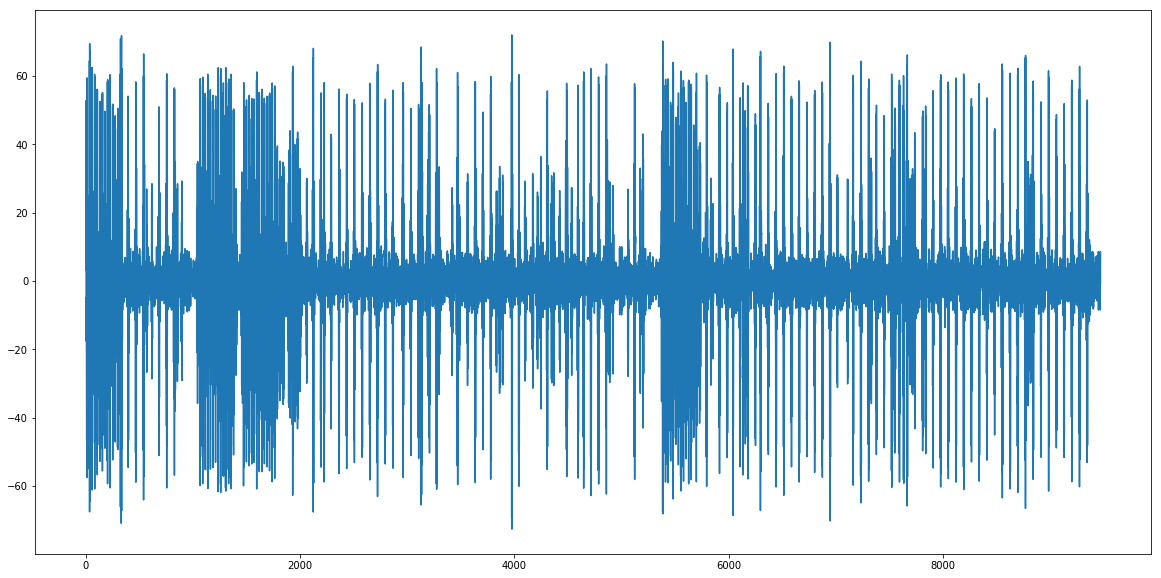

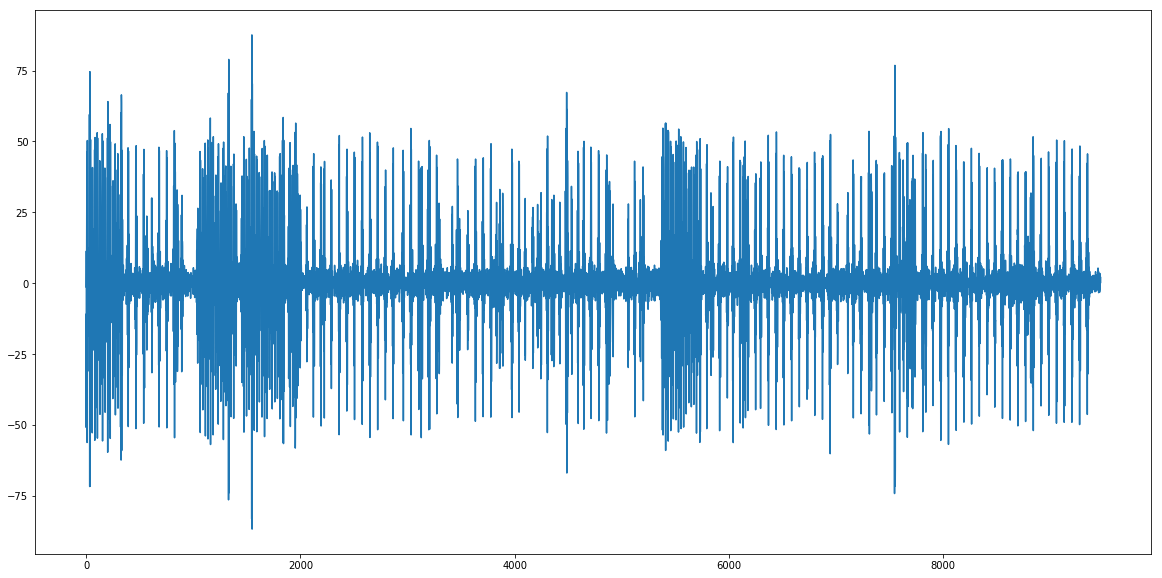

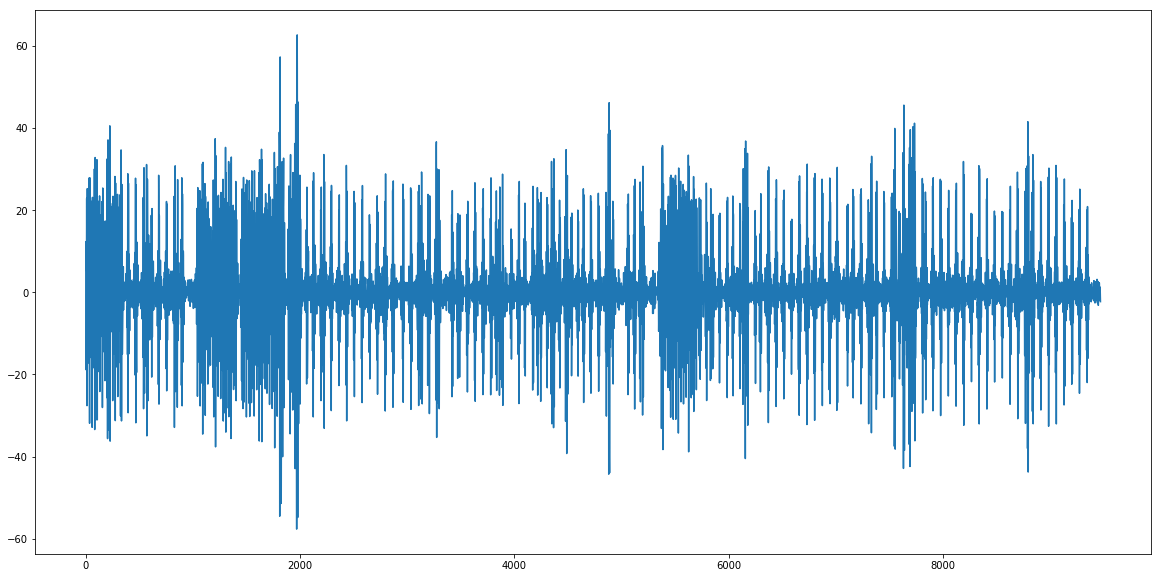

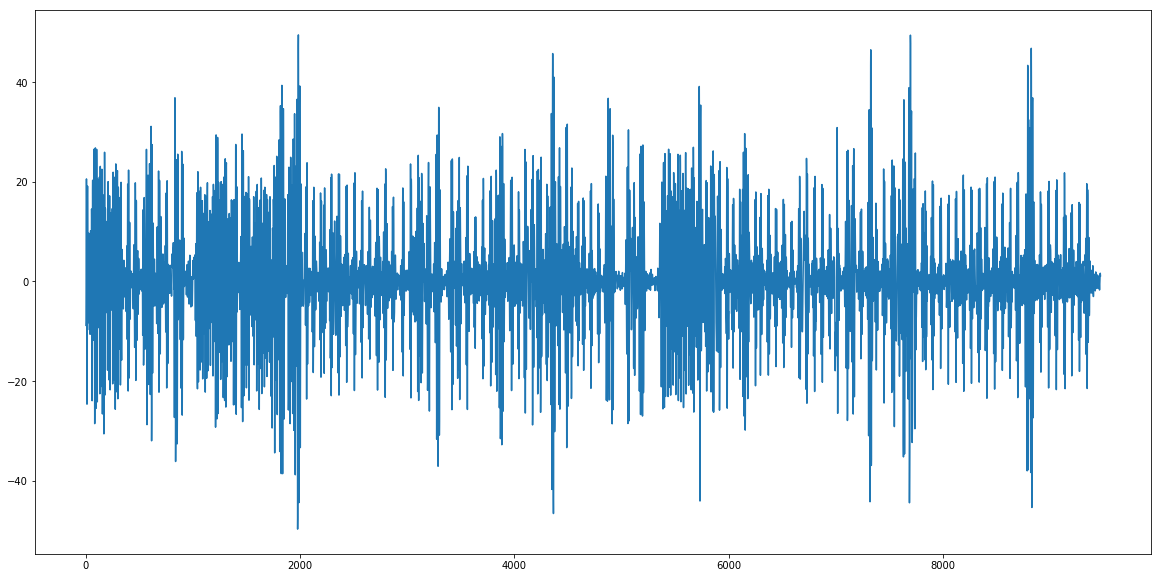

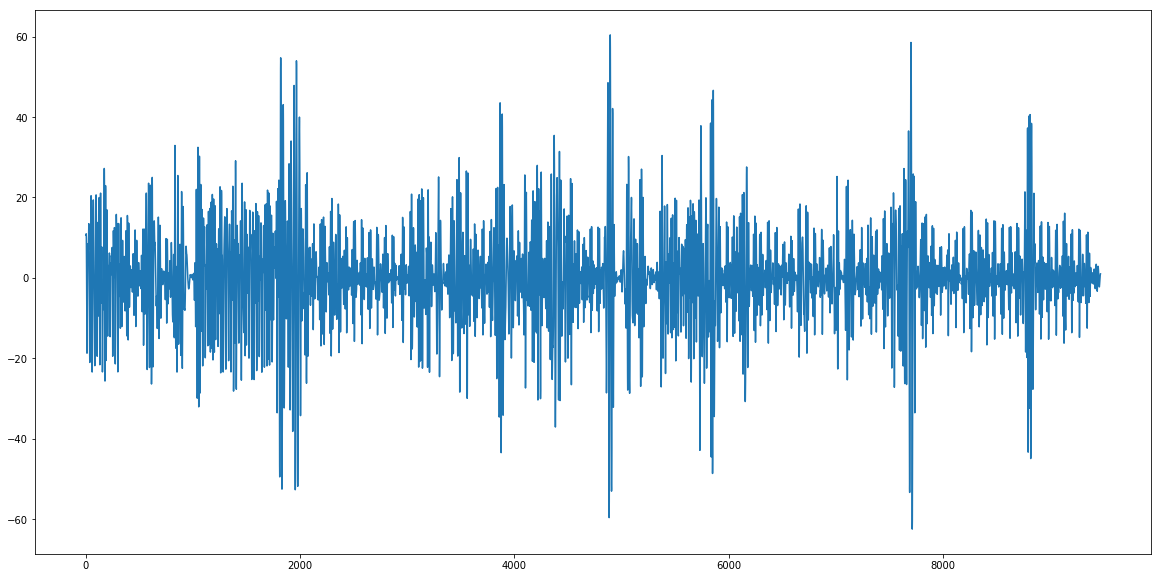

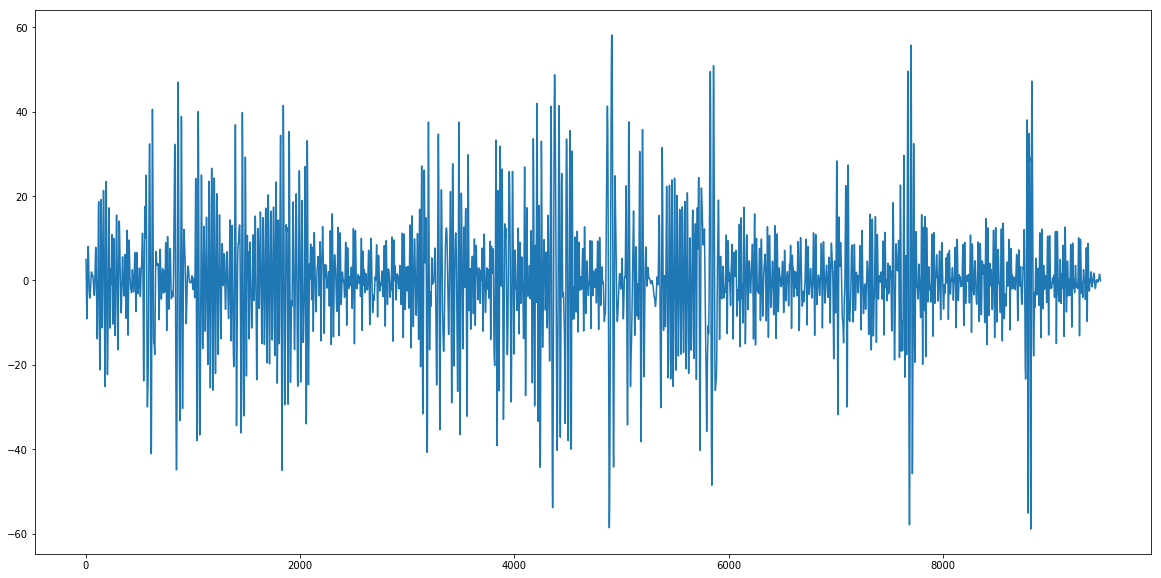

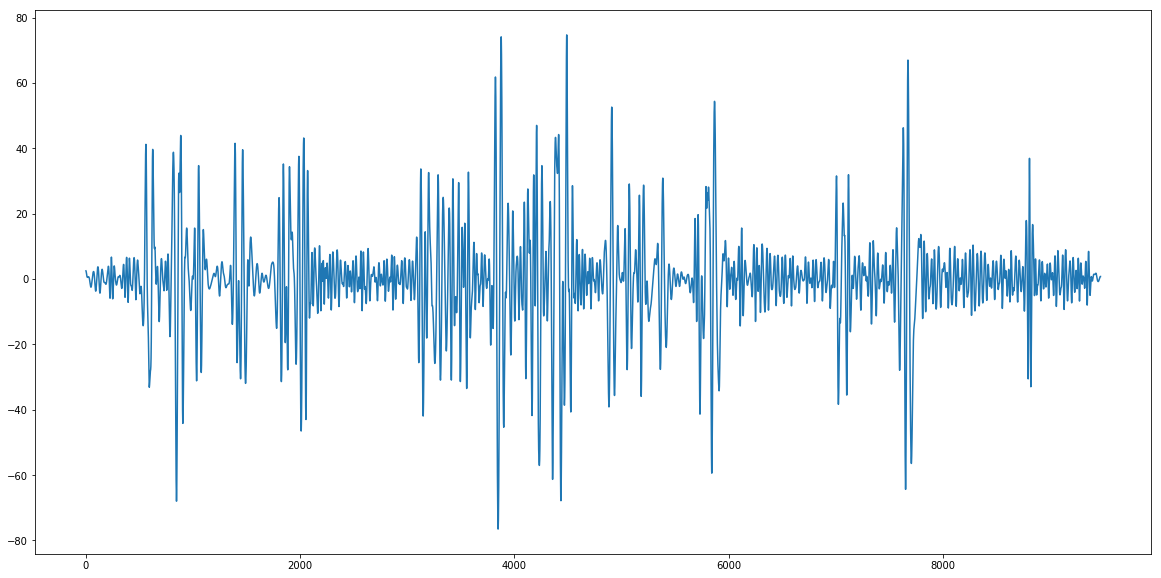

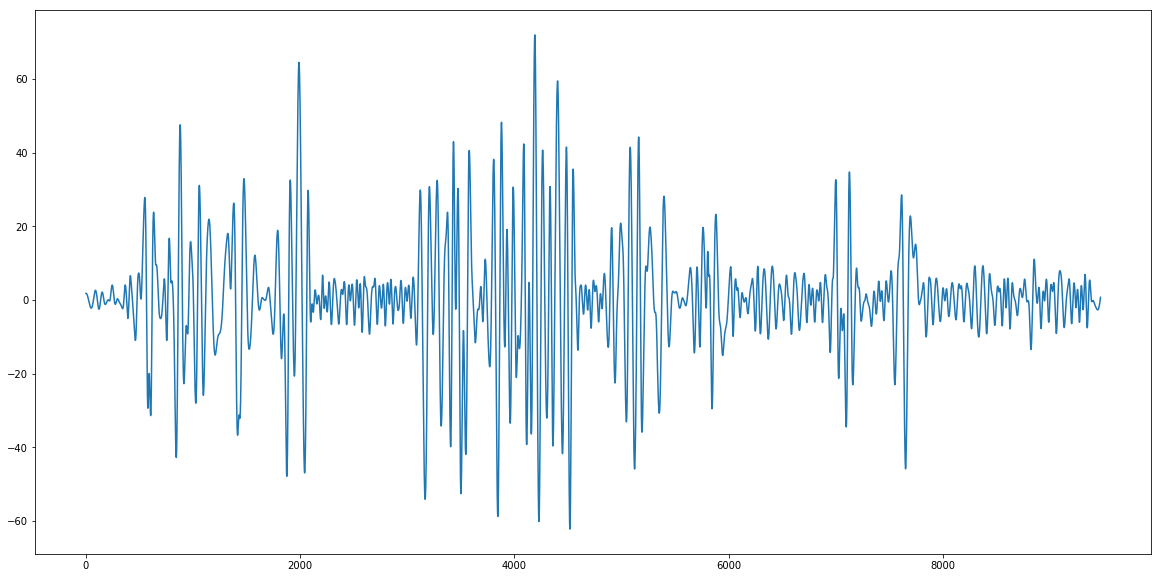

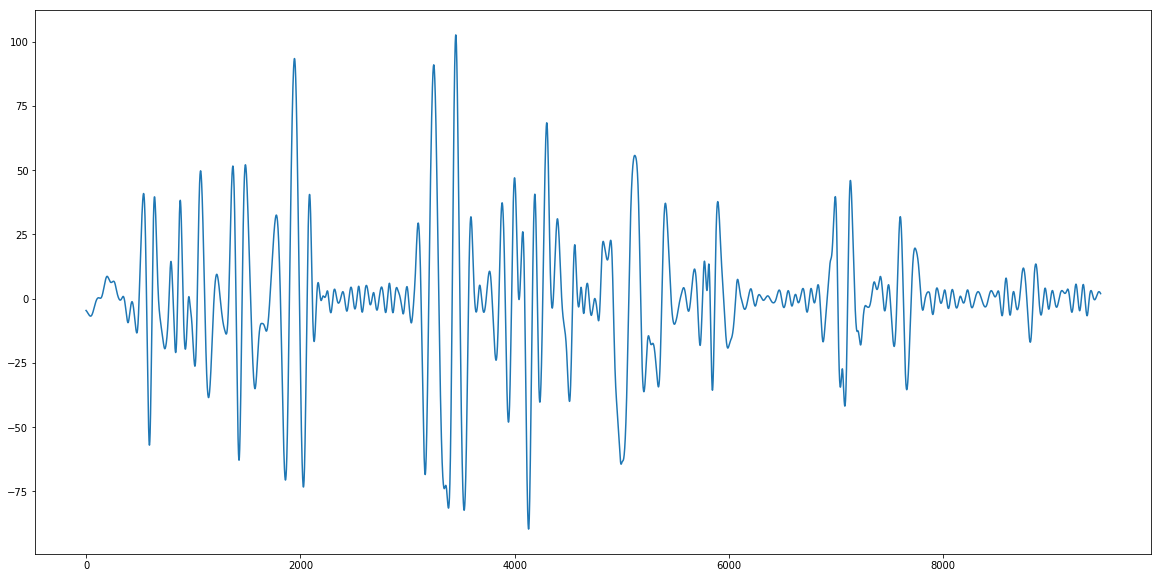

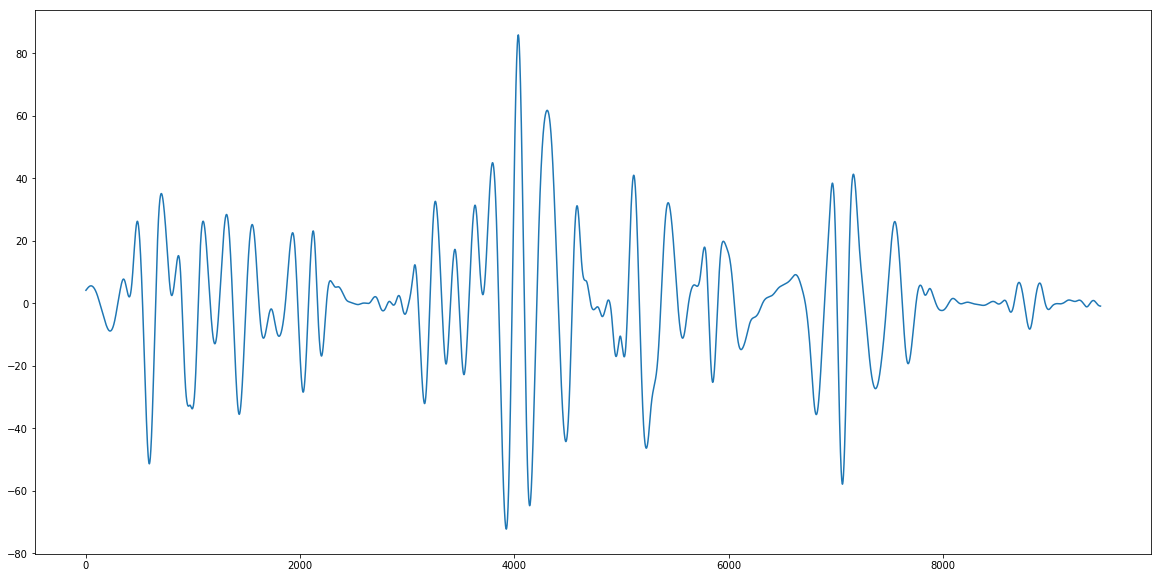

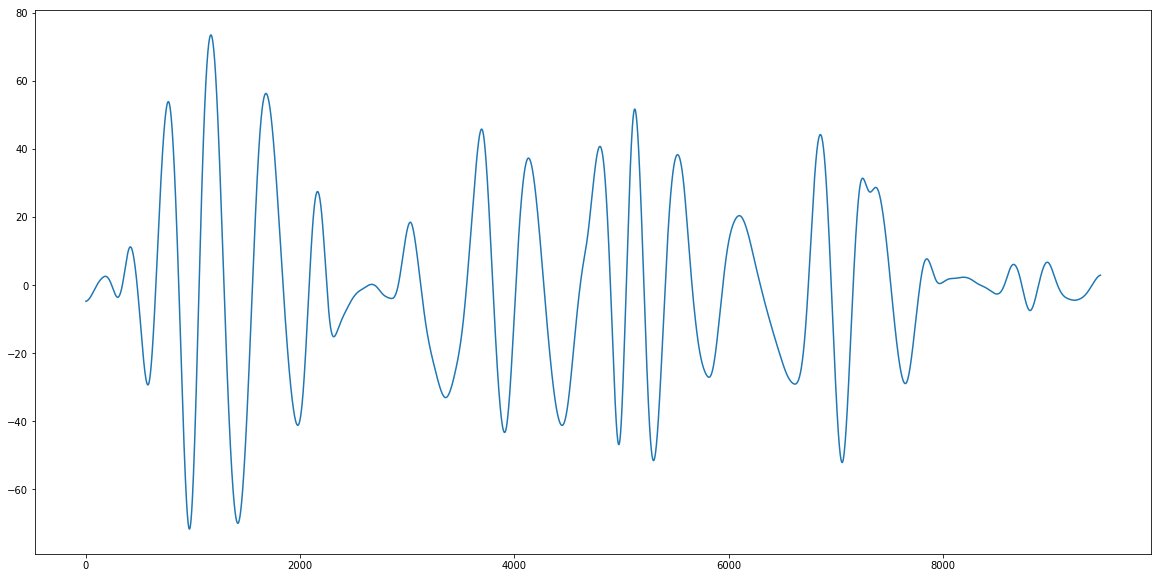

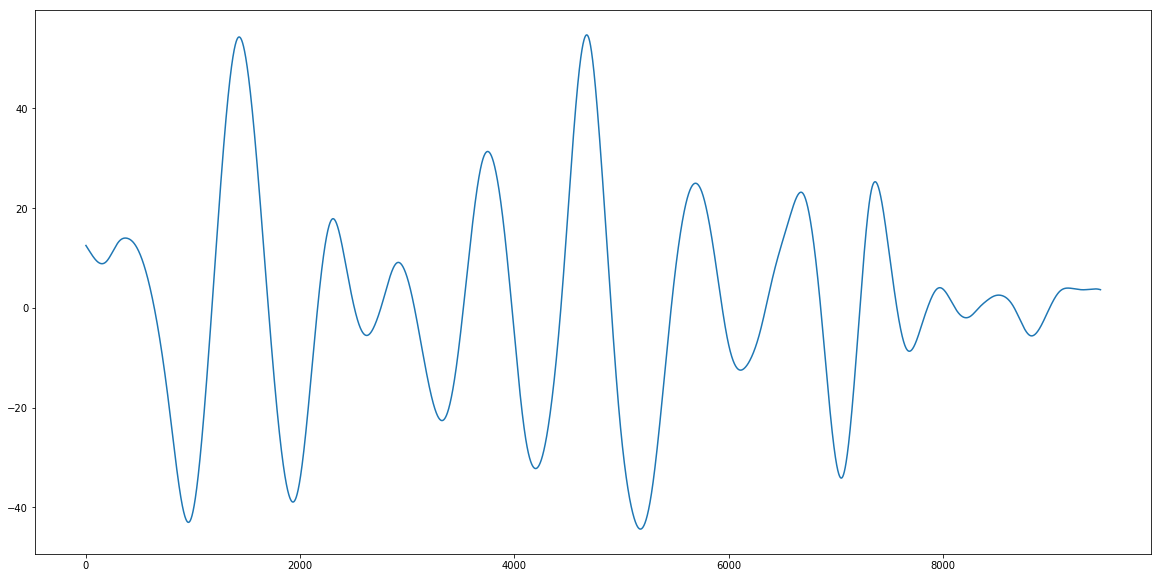

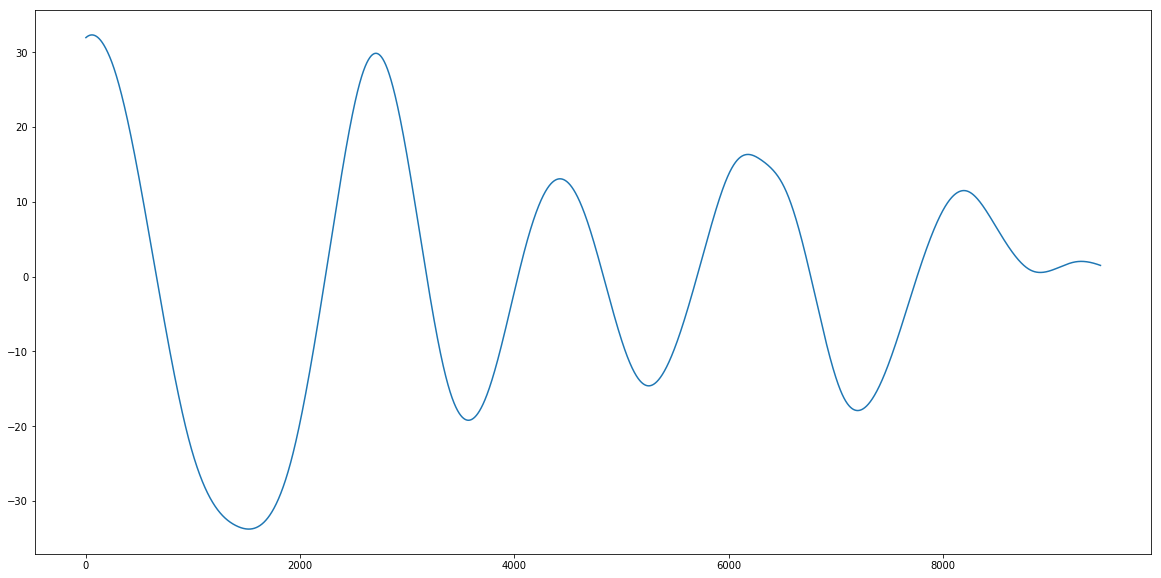

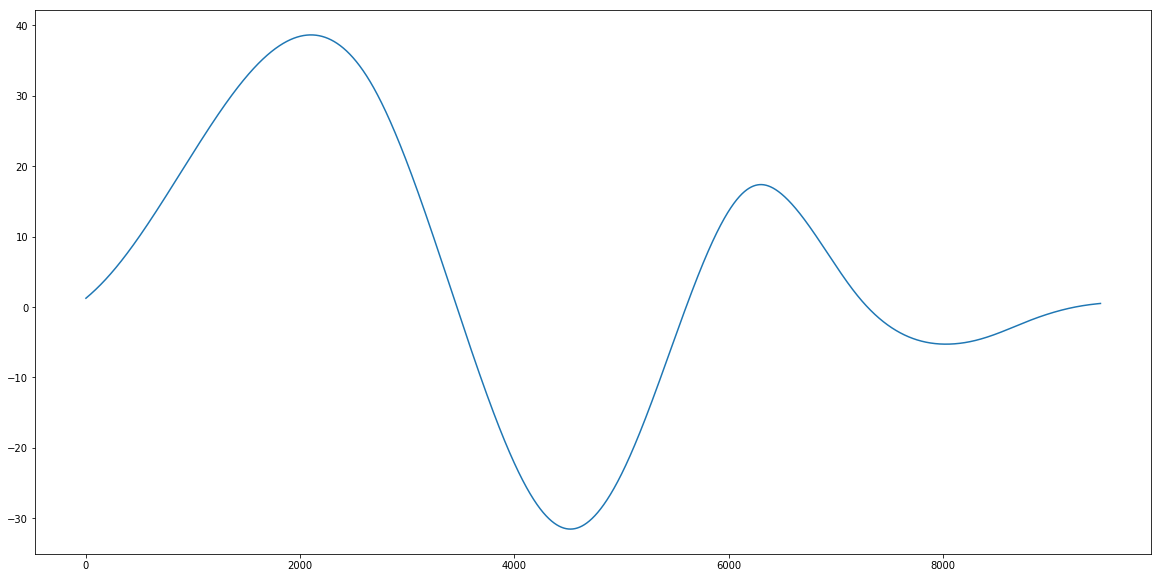

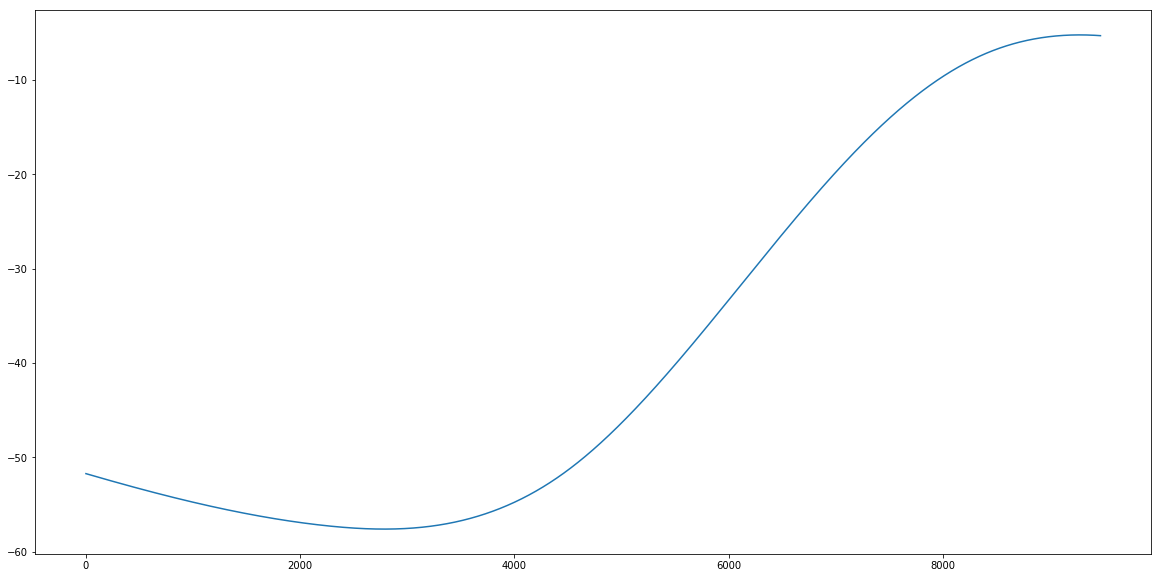

In [60]:
for i in range(15):
    plt.figure(figsize=(20, 10))
    plt.plot(imf[i])
    plt.show()

In [141]:
class SelfBoostedNet(nn.Module):
    def __init__(self, input_dim, aux_outputs, n_conv_channels, conv_kernel_size, n_gru_units):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, n_conv_channels, conv_kernel_size)
        self.conv2 = nn.Conv1d(n_conv_channels, n_conv_channels, conv_kernel_size)
        self.conv3 = nn.Conv1d(n_conv_channels, n_conv_channels, conv_kernel_size)
        self.maxpool = nn.MaxPool1d(2, 2)
        self.gru = nn.GRU(n_conv_channels, n_gru_units, num_layers=2, batch_first=True)
        self.aux_output = nn.Linear(n_gru_units, aux_outputs)
        self.main_output = nn.Linear(n_gru_units, 1)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)
        output, h = self.gru(x)
        main_output = self.main_output(h[-1])
        aux_output = self.aux_output(h[-1])
        return main_output.squeeze(1), aux_output

In [142]:
depth = 20
alpha = 0.1

In [143]:
imf_cols = ['imf_{}'.format(i) for i in range(imf.shape[0])]

In [144]:
for i, name in enumerate(imf_cols):
    data[name] = imf[i]

In [145]:
train_length = int(0.6*len(data))
val_length = int(0.2*len(data))

In [146]:
y = data[target].shift(-1).fillna(method='ffill').values

#### Test with imf features and with multitask learning

In [150]:
res = {}
for i in range(1, imf.shape[0]+1):
    print("Step: ", i)
    X = np.zeros((len(data), depth, len(cols) + len(imf_cols[:i])))
    for j, name in enumerate(cols + imf_cols[:i]):
        for k in range(depth):
            X[:, k, j] = data[name].shift(depth - k - 1).fillna(method='bfill')
    y_aux = data[imf_cols[:i]].shift(-1).fillna(method='ffill').values
    
    X_train = X[:train_length]
    X_val = X[train_length:train_length+val_length]
    X_test = X[-val_length:]
    
    y_train = y[:train_length]
    y_val = y[train_length:train_length+val_length]
    y_test = y[-val_length:]
    
    y_aux_train = y_aux[:train_length]
    y_aux_val = y_aux[train_length:train_length+val_length]
    y_aux_test = y_aux[-val_length:]
    
    X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
    X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
    X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
    X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)
    
    y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)
    y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
    y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
    y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)
    
    y_aux_train_min, y_aux_train_max = y_aux_train.min(axis=0), y_aux_train.max(axis=0)
    y_aux_train = (y_aux_train - y_aux_train_min)/(y_aux_train_max - y_aux_train_min + 1e-9)
    y_aux_val = (y_aux_val - y_aux_train_min)/(y_aux_train_max - y_aux_train_min + 1e-9)
    y_aux_test = (y_aux_test - y_aux_train_min)/(y_aux_train_max - y_aux_train_min + 1e-9)
    
    X_train_t = torch.Tensor(X_train)
    X_val_t = torch.Tensor(X_val)
    X_test_t = torch.Tensor(X_test)
    
    y_train_t = torch.Tensor(y_train)
    y_val_t = torch.Tensor(y_val)
    y_test_t = torch.Tensor(y_test)
    
    y_aux_train_t = torch.Tensor(y_aux_train)
    y_aux_val_t = torch.Tensor(y_aux_val)
    y_aux_test_t = torch.Tensor(y_aux_test)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t, y_aux_train_t), shuffle=True, batch_size=64)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t, y_aux_val_t), shuffle=False, batch_size=64)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t, y_aux_test_t), shuffle=False, batch_size=64)
    
    model = SelfBoostedNet(X_train_t.shape[2], i, 32, 3, 32).cuda()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss()
    val_loss = 99999
    for e in range(100):
        train_main_loss, train_aux_loss = 0, 0
        for batch_x, batch_y, batch_y_aux in tqdm_notebook(train_loader):
            opt.zero_grad()
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_aux = batch_y_aux.cuda()
            main_output, aux_output = model(batch_x)
            main_loss = loss(main_output, batch_y)
            aux_loss = loss(aux_output, batch_y_aux)
            total_loss = main_loss + alpha*aux_loss
            total_loss.backward()
            opt.step()
            train_main_loss += main_loss.item()*batch_x.shape[0]
            train_aux_loss += aux_loss.item()*batch_x.shape[0]
        with torch.no_grad():
            val_main_loss, val_aux_loss = 0, 0
            for batch_x, batch_y, batch_y_aux in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                batch_y_aux = batch_y_aux.cuda()
                main_output, aux_output = model(batch_x)
                main_loss = loss(main_output, batch_y)
                aux_loss = loss(aux_output, batch_y_aux)
                val_main_loss += main_loss.item()*batch_x.shape[0]
                val_aux_loss += aux_loss.item()*batch_x.shape[0]
            train_main_loss /= X_train_t.shape[0]
            train_aux_loss /= X_train_t.shape[0]
            val_main_loss /= X_val_t.shape[0]
            val_aux_loss /= X_val_t.shape[0]
            if val_loss > val_main_loss:
                val_loss = val_main_loss
                torch.save(model.state_dict(), 'self_boost_air_quality.pt')
            
        print("Iter: ", e,
              "train main loss: ", train_main_loss, 
              "train aux loss: ", train_aux_loss, 
              "val main loss: ", val_main_loss,
              "val aux loss: ", val_aux_loss)
        
    model.load_state_dict(torch.load('self_boost_air_quality.pt'))
    
    with torch.no_grad():
        val_main_loss, val_aux_loss = 0, 0
        for batch_x, batch_y, batch_y_aux in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_aux = batch_y_aux.cuda()
            main_output, aux_output = model(batch_x)
            main_loss = loss(main_output, batch_y)
            aux_loss = loss(aux_output, batch_y_aux)
            val_main_loss += main_loss.item()*batch_x.shape[0]
            val_aux_loss += aux_loss.item()*batch_x.shape[0]

        test_main_loss, test_aux_loss = 0, 0
        for batch_x, batch_y, batch_y_aux in test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_aux = batch_y_aux.cuda()
            main_output, aux_output = model(batch_x)
            main_loss = loss(main_output, batch_y)
            aux_loss = loss(aux_output, batch_y_aux)
            test_main_loss += main_loss.item()*batch_x.shape[0]
            test_aux_loss += aux_loss.item()*batch_x.shape[0]
    
    res[i] = (val_main_loss/len(X_val_t), val_aux_loss/len(X_val_t), test_main_loss/len(X_test_t),
              test_aux_loss/len(X_test_t))

Step:  1



Iter:  0 train main loss:  0.16904789426248285 train aux loss:  0.03571881475015578 val main loss:  0.032857373230938174 val aux loss:  0.015460804637832275



Iter:  1 train main loss:  0.04347090246939336 train aux loss:  0.018802757988284274 val main loss:  0.026809289626611953 val aux loss:  0.014609271402784486



Iter:  2 train main loss:  0.03455033199189625 train aux loss:  0.01825556898439111 val main loss:  0.022414587123404082 val aux loss:  0.01467911273225308



Iter:  3 train main loss:  0.03001600153208571 train aux loss:  0.018426504757796867 val main loss:  0.021273155154811794 val aux loss:  0.015202422001828865



Iter:  4 train main loss:  0.025761462240592982 train aux loss:  0.018355682100844987 val main loss:  0.018442274973095408 val aux loss:  0.014504905154784982



Iter:  5 train main loss:  0.023017956570068828 train aux loss:  0.01795559760546315 val main loss:  0.016546310295882893 val aux loss:  0.014389189687944013



Iter:  6 train main loss:  0.019881534286889758 train aux loss:  0.017835785159156046 val main loss:  0.015356018387937747 val aux loss:  0.014562874131589153



Iter:  7 train main loss:  0.016364931172518526 train aux loss:  0.01773953912678066 val main loss:  0.014025386814283721 val aux loss:  0.014329340621640211



Iter:  8 train main loss:  0.014751839898959384 train aux loss:  0.017402921492199123 val main loss:  0.016221235415759597 val aux loss:  0.013663206752999405



Iter:  9 train main loss:  0.012068112529302852 train aux loss:  0.016974887897190663 val main loss:  0.010374046146177315 val aux loss:  0.013231829664381781



Iter:  10 train main loss:  0.0106633097367392 train aux loss:  0.016649971501387077 val main loss:  0.008698232918427008 val aux loss:  0.013157942478860696



Iter:  11 train main loss:  0.009192829497947906 train aux loss:  0.016175049941282653 val main loss:  0.008582972682453888 val aux loss:  0.012650912165358552



Iter:  12 train main loss:  0.0083131383188575 train aux loss:  0.01576223486522393 val main loss:  0.00789895785112945 val aux loss:  0.013130340894336056



Iter:  13 train main loss:  0.007413969875111079 train aux loss:  0.015337128777664046 val main loss:  0.007022722646861545 val aux loss:  0.011811524185075679



Iter:  14 train main loss:  0.006230365399434174 train aux loss:  0.014554395320058519 val main loss:  0.0062165070687044 val aux loss:  0.011462318029455298



Iter:  15 train main loss:  0.0052478882110101035 train aux loss:  0.01385369521507712 val main loss:  0.005889107400419657 val aux loss:  0.011646712602066012



Iter:  16 train main loss:  0.004754900048194805 train aux loss:  0.013384523677919289 val main loss:  0.005294690208574471 val aux loss:  0.010752343699540609



Iter:  17 train main loss:  0.004452619074124434 train aux loss:  0.01281528406478504 val main loss:  0.005144604134600543 val aux loss:  0.011362366866096147



Iter:  18 train main loss:  0.004060834343610702 train aux loss:  0.012651136484775996 val main loss:  0.007330427947429568 val aux loss:  0.010683030067080556



Iter:  19 train main loss:  0.004228373050928346 train aux loss:  0.012322486303838488 val main loss:  0.004584819869627073 val aux loss:  0.010988917461386956



Iter:  20 train main loss:  0.003896605714812051 train aux loss:  0.012864238920528803 val main loss:  0.004878578324032182 val aux loss:  0.00981503627100741



Iter:  21 train main loss:  0.0029710452267372326 train aux loss:  0.011581855805099682 val main loss:  0.004492028711762952 val aux loss:  0.010469521379143535



Iter:  22 train main loss:  0.003911892296424295 train aux loss:  0.012096890385712758 val main loss:  0.004301042129298418 val aux loss:  0.010111448359936319



Iter:  23 train main loss:  0.0028206256423405325 train aux loss:  0.011352441041864421 val main loss:  0.004753580059238573 val aux loss:  0.011928585358947485



Iter:  24 train main loss:  0.0024937458043942273 train aux loss:  0.011328002990153643 val main loss:  0.004889304374975035 val aux loss:  0.01071293881397061



Iter:  25 train main loss:  0.0032200433404159638 train aux loss:  0.01145496160193192 val main loss:  0.004936367232517714 val aux loss:  0.010406854234974136



Iter:  26 train main loss:  0.002159383769902056 train aux loss:  0.011181722620986625 val main loss:  0.004603774543977495 val aux loss:  0.00965194074081015



Iter:  27 train main loss:  0.002475588722351187 train aux loss:  0.011150084634267898 val main loss:  0.005152052966631957 val aux loss:  0.010259604177889124



Iter:  28 train main loss:  0.0027202325699334936 train aux loss:  0.011765785133731655 val main loss:  0.004009652364292942 val aux loss:  0.010197000882913847



Iter:  29 train main loss:  0.0018034416156801612 train aux loss:  0.010958182212425574 val main loss:  0.004635941107396465 val aux loss:  0.009707318498913313



Iter:  30 train main loss:  0.0014210539851965028 train aux loss:  0.010890097009848746 val main loss:  0.005213166480105068 val aux loss:  0.009871508949755867



Iter:  31 train main loss:  0.0015280638562531112 train aux loss:  0.010941587408348283 val main loss:  0.00652309883975472 val aux loss:  0.010050581750453084



Iter:  32 train main loss:  0.0018961406459989906 train aux loss:  0.01113122354292064 val main loss:  0.005231646710756966 val aux loss:  0.009895477388860558



Iter:  33 train main loss:  0.002718821272764726 train aux loss:  0.011768787440380677 val main loss:  0.007173559370764394 val aux loss:  0.01820586369999359



Iter:  34 train main loss:  0.0025661691786594814 train aux loss:  0.01160704175440417 val main loss:  0.00399671285290275 val aux loss:  0.009638501423653982



Iter:  35 train main loss:  0.0016079527840628582 train aux loss:  0.010766726394342268 val main loss:  0.004208116843773263 val aux loss:  0.01026375332912145



Iter:  36 train main loss:  0.00145701179387417 train aux loss:  0.01087254494941993 val main loss:  0.0036640243311958443 val aux loss:  0.009409302194556565



Iter:  37 train main loss:  0.0012805893435675635 train aux loss:  0.010532050727565329 val main loss:  0.003927630991792973 val aux loss:  0.009634350517955475



Iter:  38 train main loss:  0.0012919939430748512 train aux loss:  0.010513920517915658 val main loss:  0.0045729056020378436 val aux loss:  0.010245126598330712



Iter:  39 train main loss:  0.001012963798795498 train aux loss:  0.010554950990816082 val main loss:  0.004914454479567577 val aux loss:  0.010190147985217437



Iter:  40 train main loss:  0.0013137188452744739 train aux loss:  0.010533888764949552 val main loss:  0.006944221948197754 val aux loss:  0.010563532624161608



Iter:  41 train main loss:  0.0015692004195918662 train aux loss:  0.010435704358540993 val main loss:  0.004051216766375895 val aux loss:  0.010085996696695984



Iter:  42 train main loss:  0.0009573286610009855 train aux loss:  0.010327872443866851 val main loss:  0.0037420433755411347 val aux loss:  0.009526716511787055



Iter:  43 train main loss:  0.0008592017013280066 train aux loss:  0.010432763671615894 val main loss:  0.0039568158703631945 val aux loss:  0.009526374469557434



Iter:  44 train main loss:  0.0005566991574862964 train aux loss:  0.01014326938186385 val main loss:  0.0035373665808642 val aux loss:  0.009411349876881149



Iter:  45 train main loss:  0.0009510808686089588 train aux loss:  0.010357603796261773 val main loss:  0.0037213848821903406 val aux loss:  0.009338350429611699



Iter:  46 train main loss:  0.0005887008689112656 train aux loss:  0.010157964077267753 val main loss:  0.003894899457994526 val aux loss:  0.009389869314092265



Iter:  47 train main loss:  0.0008757847755986673 train aux loss:  0.010124666933645584 val main loss:  0.004431181685254568 val aux loss:  0.009465507010377574



Iter:  48 train main loss:  0.0010121651038924185 train aux loss:  0.010311406131981964 val main loss:  0.004579243840304412 val aux loss:  0.009706415637241875



Iter:  49 train main loss:  0.0015927923628381812 train aux loss:  0.010443115762124458 val main loss:  0.003845591407916838 val aux loss:  0.009366889713369428



Iter:  50 train main loss:  0.0014676603969938553 train aux loss:  0.010397809563845197 val main loss:  0.004903048883256657 val aux loss:  0.01032814337481541



Iter:  51 train main loss:  0.0009882066219113932 train aux loss:  0.01010920521362289 val main loss:  0.003705748779206992 val aux loss:  0.009244602264043774



Iter:  52 train main loss:  0.0012169966513062515 train aux loss:  0.010195810189296908 val main loss:  0.0032156057611679206 val aux loss:  0.009200353490104141



Iter:  53 train main loss:  0.0006220965047821924 train aux loss:  0.010044016358690105 val main loss:  0.0030245894334208195 val aux loss:  0.009055667522401719



Iter:  54 train main loss:  0.0006142779412126678 train aux loss:  0.00996155661243299 val main loss:  0.004813291110568448 val aux loss:  0.009505272678708326



Iter:  55 train main loss:  0.0010228448367319246 train aux loss:  0.00989673803132637 val main loss:  0.0034502587830544562 val aux loss:  0.009293662976186404



Iter:  56 train main loss:  0.0008420234425429389 train aux loss:  0.009908607368092277 val main loss:  0.0041700327435042215 val aux loss:  0.00935361505640472



Iter:  57 train main loss:  0.0006774338561044472 train aux loss:  0.009932776224471312 val main loss:  0.0036924724722671525 val aux loss:  0.009292405594333046



Iter:  58 train main loss:  0.0012517701293852715 train aux loss:  0.01010520877011726 val main loss:  0.0034634912399567246 val aux loss:  0.00932381480711944



Iter:  59 train main loss:  0.0011326626520302306 train aux loss:  0.010287122053200093 val main loss:  0.003080309328041408 val aux loss:  0.009323812053472968



Iter:  60 train main loss:  0.0009360820935928945 train aux loss:  0.009855815849015513 val main loss:  0.00388959269413042 val aux loss:  0.009434703064820834



Iter:  61 train main loss:  0.0006534363616808062 train aux loss:  0.009817290276850205 val main loss:  0.0044238057016781525 val aux loss:  0.009260668127218295



Iter:  62 train main loss:  0.0005369929563144832 train aux loss:  0.009776064636633561 val main loss:  0.008193354640278224 val aux loss:  0.010421938576598858



Iter:  63 train main loss:  0.0008052595033996225 train aux loss:  0.009806182649181957 val main loss:  0.003153648011709948 val aux loss:  0.009185544922239802



Iter:  64 train main loss:  0.001012801804273144 train aux loss:  0.010156092847953461 val main loss:  0.0032885240217195794 val aux loss:  0.009717845386474412



Iter:  65 train main loss:  0.0006724369912612357 train aux loss:  0.0098064282036392 val main loss:  0.0035988108102903912 val aux loss:  0.009415669974486453



Iter:  66 train main loss:  0.0006169150756368468 train aux loss:  0.009581909817700832 val main loss:  0.003754704055209657 val aux loss:  0.00970598074205322



Iter:  67 train main loss:  0.0008137392838235088 train aux loss:  0.00956228410674994 val main loss:  0.004041956926458992 val aux loss:  0.009109809963227326



Iter:  68 train main loss:  0.000900982966902883 train aux loss:  0.009633047560958303 val main loss:  0.0034904598043675886 val aux loss:  0.008917856513037727



Iter:  69 train main loss:  0.0005972267196051944 train aux loss:  0.009665813928732923 val main loss:  0.00253750479753646 val aux loss:  0.00891962330375327



Iter:  70 train main loss:  0.0009619975520230847 train aux loss:  0.009749473706254947 val main loss:  0.002850241576166039 val aux loss:  0.009011317776179742



Iter:  71 train main loss:  0.001520790891692833 train aux loss:  0.00994166917935019 val main loss:  0.0029063360053070337 val aux loss:  0.008815259252770272



Iter:  72 train main loss:  0.0015104159953674044 train aux loss:  0.009972087871735678 val main loss:  0.0026273718189817894 val aux loss:  0.00880213271838307



Iter:  73 train main loss:  0.0006248197963738529 train aux loss:  0.00945394190303019 val main loss:  0.0030371854320850023 val aux loss:  0.009157877100716172



Iter:  74 train main loss:  0.00037510477718757023 train aux loss:  0.00931671576850465 val main loss:  0.002404438400195583 val aux loss:  0.009008455002698123



Iter:  75 train main loss:  0.0007529022592879871 train aux loss:  0.009345538765047793 val main loss:  0.0029889648989085875 val aux loss:  0.009356385169682558



Iter:  76 train main loss:  0.0003515136315357756 train aux loss:  0.00922234827244116 val main loss:  0.005130680792408365 val aux loss:  0.010352901913768512



Iter:  77 train main loss:  0.0012499897153213796 train aux loss:  0.009728644852254727 val main loss:  0.0032892620247280285 val aux loss:  0.008960082438610172



Iter:  78 train main loss:  0.0007506659907367607 train aux loss:  0.009651339924489421 val main loss:  0.0028843040891048726 val aux loss:  0.009160416151584768



Iter:  79 train main loss:  0.0005063299959179129 train aux loss:  0.009251703023851516 val main loss:  0.0025748716752239578 val aux loss:  0.009059624732673608



Iter:  80 train main loss:  0.00048626874559104907 train aux loss:  0.009330117857671778 val main loss:  0.0046919889091892675 val aux loss:  0.008946380116745688



Iter:  81 train main loss:  0.0008448882867656802 train aux loss:  0.009365606966334376 val main loss:  0.0026266060740607784 val aux loss:  0.008749531192553584



Iter:  82 train main loss:  0.0005825375117766725 train aux loss:  0.009146401617349515 val main loss:  0.0021717089687846797 val aux loss:  0.008212771589268853



Iter:  83 train main loss:  0.0006297051158337583 train aux loss:  0.009188472679483453 val main loss:  0.0020204162378606133 val aux loss:  0.009261457935966937



Iter:  84 train main loss:  0.00030840827502669725 train aux loss:  0.009037549331107638 val main loss:  0.00201363190908072 val aux loss:  0.008618261488085689



Iter:  85 train main loss:  0.0008330152084877527 train aux loss:  0.009198181213144264 val main loss:  0.0031748056114742724 val aux loss:  0.00872584524807356



Iter:  86 train main loss:  0.0006556209733717366 train aux loss:  0.009031268762439667 val main loss:  0.0028510550915365872 val aux loss:  0.009342481402843529



Iter:  87 train main loss:  0.0006606072801864369 train aux loss:  0.009083839284504585 val main loss:  0.003061771148251745 val aux loss:  0.009849586883026796



Iter:  88 train main loss:  0.0006095220471424337 train aux loss:  0.00897436834683603 val main loss:  0.0024316323152276144 val aux loss:  0.008551195460551643



Iter:  89 train main loss:  0.00022571280580216212 train aux loss:  0.008699152123645887 val main loss:  0.00247486652207729 val aux loss:  0.00827534145104218



Iter:  90 train main loss:  0.00017389969240205064 train aux loss:  0.008589741183508453 val main loss:  0.0021555175726452433 val aux loss:  0.008356793208289675



Iter:  91 train main loss:  0.0002409152755542082 train aux loss:  0.008671698961321713 val main loss:  0.00232680118049607 val aux loss:  0.008564817206786578



Iter:  92 train main loss:  0.00015569934604114943 train aux loss:  0.00850479487055668 val main loss:  0.0022476802308013053 val aux loss:  0.009704047111831723



Iter:  93 train main loss:  0.00045615661449038543 train aux loss:  0.00900991893491771 val main loss:  0.0027937523839595 val aux loss:  0.008864708055979095



Iter:  94 train main loss:  0.0001011394169871636 train aux loss:  0.008614927523076766 val main loss:  0.0027426773459086817 val aux loss:  0.008274107903965927



Iter:  95 train main loss:  0.00012895844555010604 train aux loss:  0.00878468223358021 val main loss:  0.0020463377460869328 val aux loss:  0.009511268783238772



Iter:  96 train main loss:  0.0002813681711417199 train aux loss:  0.008752190223568837 val main loss:  0.0028498773539902046 val aux loss:  0.008339844616533207



Iter:  97 train main loss:  0.0011484799858361163 train aux loss:  0.009085114542768585 val main loss:  0.0042295564905717705 val aux loss:  0.009787940208769651



Iter:  98 train main loss:  0.0010095199401480885 train aux loss:  0.009038938347096806 val main loss:  0.003365239328355651 val aux loss:  0.00854682005005628



Iter:  99 train main loss:  0.0006258875773886387 train aux loss:  0.009024995195245668 val main loss:  0.0022923874555926655 val aux loss:  0.008551885709245203
Step:  2



Iter:  0 train main loss:  0.1674494569644526 train aux loss:  0.062362889090827635 val main loss:  0.036484683107549314 val aux loss:  0.017024204252954523



Iter:  1 train main loss:  0.04807128910393582 train aux loss:  0.023663745980299366 val main loss:  0.029208922754764683 val aux loss:  0.011752100246383118



Iter:  2 train main loss:  0.03689583556825575 train aux loss:  0.014403122069103665 val main loss:  0.02493754952925689 val aux loss:  0.011013932423833306



Iter:  3 train main loss:  0.030399665356453394 train aux loss:  0.01389859434950209 val main loss:  0.023154344820784288 val aux loss:  0.011077732193935761



Iter:  4 train main loss:  0.024394384708907226 train aux loss:  0.013820631726553474 val main loss:  0.017197589455870667 val aux loss:  0.010982506909459799



Iter:  5 train main loss:  0.020265712285731007 train aux loss:  0.013571415708552087 val main loss:  0.02073618315097334 val aux loss:  0.010708911161488187



Iter:  6 train main loss:  0.01720528695856925 train aux loss:  0.013372526578513387 val main loss:  0.01244711357541579 val aux loss:  0.01094355667255811



Iter:  7 train main loss:  0.015059349257912026 train aux loss:  0.013147217537243993 val main loss:  0.013876127174523401 val aux loss:  0.010667680502095217



Iter:  8 train main loss:  0.01267500443299475 train aux loss:  0.012991305693081885 val main loss:  0.010447236535226908 val aux loss:  0.010345284609712164



Iter:  9 train main loss:  0.010234319987083663 train aux loss:  0.01285205636139394 val main loss:  0.008246436974755562 val aux loss:  0.010658824965829834



Iter:  10 train main loss:  0.007855002920935635 train aux loss:  0.012489858298473629 val main loss:  0.006616152445328399 val aux loss:  0.010004353708535463



Iter:  11 train main loss:  0.006677529569721818 train aux loss:  0.01219192206130528 val main loss:  0.005779512871721604 val aux loss:  0.009650097300378172



Iter:  12 train main loss:  0.005555576854311677 train aux loss:  0.011879519507976033 val main loss:  0.0055316904522360565 val aux loss:  0.009635915033668752



Iter:  13 train main loss:  0.004938130158949374 train aux loss:  0.011727099719272768 val main loss:  0.004529261164005291 val aux loss:  0.009488868545799849



Iter:  14 train main loss:  0.004027266590544591 train aux loss:  0.011461060710706338 val main loss:  0.004756221752279411 val aux loss:  0.009614161250143142



Iter:  15 train main loss:  0.0031287145738767585 train aux loss:  0.011006502967966417 val main loss:  0.0033072906033919758 val aux loss:  0.009442854603829202



Iter:  16 train main loss:  0.002413527414283251 train aux loss:  0.010669722679749378 val main loss:  0.003126102449262265 val aux loss:  0.00890245578333405



Iter:  17 train main loss:  0.002452954808259904 train aux loss:  0.010454758442807202 val main loss:  0.0036909629019427704 val aux loss:  0.00948540239527019



Iter:  18 train main loss:  0.0023749773488935663 train aux loss:  0.010803103880331953 val main loss:  0.003147561564341329 val aux loss:  0.008765298346059502



Iter:  19 train main loss:  0.0021290033668068535 train aux loss:  0.00991449951378131 val main loss:  0.0025775343904501846 val aux loss:  0.009029377633440205



Iter:  20 train main loss:  0.0017945360686054367 train aux loss:  0.009989194570660633 val main loss:  0.003657781793376964 val aux loss:  0.00856074739204289



Iter:  21 train main loss:  0.0013878660538210541 train aux loss:  0.009732334091092386 val main loss:  0.002167563304357199 val aux loss:  0.008187948508776228



Iter:  22 train main loss:  0.0012231816279359977 train aux loss:  0.009695133613930627 val main loss:  0.002727510936660525 val aux loss:  0.008296281107187019



Iter:  23 train main loss:  0.0015309313922728432 train aux loss:  0.009699239618800887 val main loss:  0.002108134733269103 val aux loss:  0.008032846088504464



Iter:  24 train main loss:  0.0010138214588914258 train aux loss:  0.009121023319118756 val main loss:  0.0019953802922286225 val aux loss:  0.00786189720380772



Iter:  25 train main loss:  0.0010085753712226826 train aux loss:  0.009041033062030945 val main loss:  0.0026179116736574307 val aux loss:  0.00801826224376181



Iter:  26 train main loss:  0.000879349075559368 train aux loss:  0.00886819464495797 val main loss:  0.0022898174045654653 val aux loss:  0.008075278256296985



Iter:  27 train main loss:  0.0013120508900402977 train aux loss:  0.009085995970908206 val main loss:  0.0026010881648167827 val aux loss:  0.007965839447290367



Iter:  28 train main loss:  0.0009516671780224422 train aux loss:  0.00878380850712752 val main loss:  0.0023952408751754094 val aux loss:  0.00848548417200886



Iter:  29 train main loss:  0.0007123808570701002 train aux loss:  0.008478341290752827 val main loss:  0.0019413971201022015 val aux loss:  0.007703528996191156



Iter:  30 train main loss:  0.0009077458117160991 train aux loss:  0.008825535876810845 val main loss:  0.002417654975749151 val aux loss:  0.010061179019251116



Iter:  31 train main loss:  0.0012949498915323311 train aux loss:  0.009570547456589857 val main loss:  0.0025477201688676727 val aux loss:  0.008306351001546527



Iter:  32 train main loss:  0.0006978585658634632 train aux loss:  0.00904390817840506 val main loss:  0.002141935861479676 val aux loss:  0.0071978687280208785



Iter:  33 train main loss:  0.0011410396151722922 train aux loss:  0.009109927406904984 val main loss:  0.002133326243054527 val aux loss:  0.007745303315874642



Iter:  34 train main loss:  0.0007158460171372996 train aux loss:  0.008391060648090674 val main loss:  0.0018028847394027249 val aux loss:  0.007116998932319433



Iter:  35 train main loss:  0.0004242088971401387 train aux loss:  0.008181041155426132 val main loss:  0.0017902401338381556 val aux loss:  0.006913713745009685



Iter:  36 train main loss:  0.00043198845681328876 train aux loss:  0.00834734978259858 val main loss:  0.0018700553547323475 val aux loss:  0.007176218412761452



Iter:  37 train main loss:  0.0014903135404499843 train aux loss:  0.009727733478865356 val main loss:  0.0027604415462526405 val aux loss:  0.007570855315566189



Iter:  38 train main loss:  0.0009900589738266452 train aux loss:  0.009080651712848746 val main loss:  0.0013654548503948256 val aux loss:  0.006734434428694634



Iter:  39 train main loss:  0.0004546299701697852 train aux loss:  0.008061128866815181 val main loss:  0.0018938854816168106 val aux loss:  0.00690635230781662



Iter:  40 train main loss:  0.0003652828234139664 train aux loss:  0.00811085112629585 val main loss:  0.0016234977271136412 val aux loss:  0.006717261218061669



Iter:  41 train main loss:  0.00029445771209155405 train aux loss:  0.007894957802969463 val main loss:  0.0019526247634850404 val aux loss:  0.007534762226839756



Iter:  42 train main loss:  0.0006190969263073873 train aux loss:  0.00830359236146784 val main loss:  0.002181827507661351 val aux loss:  0.0072369018359131395



Iter:  43 train main loss:  0.0003526057548250697 train aux loss:  0.008004897364226079 val main loss:  0.0019476088622576088 val aux loss:  0.006762666132108337



Iter:  44 train main loss:  0.0006131123824745397 train aux loss:  0.008277235696907196 val main loss:  0.0020036789559249777 val aux loss:  0.007010092315634805



Iter:  45 train main loss:  0.0005739131109157232 train aux loss:  0.00795595444160599 val main loss:  0.0019982016112836355 val aux loss:  0.008865503063218897



Iter:  46 train main loss:  0.0006282246927394729 train aux loss:  0.008310381665993686 val main loss:  0.0027946635356434517 val aux loss:  0.007073591505555946



Iter:  47 train main loss:  0.0005199650513621742 train aux loss:  0.008072599029415659 val main loss:  0.0013501936260762269 val aux loss:  0.0068334168710263



Iter:  48 train main loss:  0.0004904012772146795 train aux loss:  0.007788086874198742 val main loss:  0.0027642900816537636 val aux loss:  0.007245582790992202



Iter:  49 train main loss:  0.00046823046222871346 train aux loss:  0.008087054935809447 val main loss:  0.0024807360242076666 val aux loss:  0.008639562867164864



Iter:  50 train main loss:  0.0005652186054271616 train aux loss:  0.008013015261378214 val main loss:  0.0012526301041500172 val aux loss:  0.006681617805704774



Iter:  51 train main loss:  0.0007507922947021996 train aux loss:  0.008469095083516759 val main loss:  0.002211078062236561 val aux loss:  0.009437795954637443



Iter:  52 train main loss:  0.0006169660600569048 train aux loss:  0.008277905128197335 val main loss:  0.002717529515364063 val aux loss:  0.007434779433917093



Iter:  53 train main loss:  0.0004906815142333963 train aux loss:  0.007930258821023366 val main loss:  0.0014029870486111156 val aux loss:  0.006630880339218671



Iter:  54 train main loss:  0.00015637923398747482 train aux loss:  0.007511389476372685 val main loss:  0.002857753078117888 val aux loss:  0.0069031862437788005



Iter:  55 train main loss:  0.0002275620582990482 train aux loss:  0.007777141663483523 val main loss:  0.0019206764064498105 val aux loss:  0.006933421445292556



Iter:  56 train main loss:  0.0008324826469931784 train aux loss:  0.008377548003623662 val main loss:  0.0012908294255311239 val aux loss:  0.007638747515717429



Iter:  57 train main loss:  0.0004531350173185203 train aux loss:  0.007894280759977628 val main loss:  0.001729707345843449 val aux loss:  0.006595613558824866



Iter:  58 train main loss:  0.0002848830136756269 train aux loss:  0.0075586851091582734 val main loss:  0.0013979040393595993 val aux loss:  0.006601160695066296



Iter:  59 train main loss:  9.745646674609774e-05 train aux loss:  0.007366203208313321 val main loss:  0.0013812849659658574 val aux loss:  0.006575214693277539



Iter:  60 train main loss:  6.258892178135958e-05 train aux loss:  0.007284750916727283 val main loss:  0.001301592100463776 val aux loss:  0.00658386454001903



Iter:  61 train main loss:  7.352219030228626e-05 train aux loss:  0.007242197584556216 val main loss:  0.0012754485499258364 val aux loss:  0.006826488944331092



Iter:  62 train main loss:  5.676104556007782e-05 train aux loss:  0.007170192838313084 val main loss:  0.0011915922220358715 val aux loss:  0.006526558397390901



Iter:  63 train main loss:  6.553946181734947e-05 train aux loss:  0.0069556627334061115 val main loss:  0.0014591158762362264 val aux loss:  0.006689737673844933



Iter:  64 train main loss:  7.425873989786541e-05 train aux loss:  0.006940855669393344 val main loss:  0.0015562380004343268 val aux loss:  0.006943084299564362



Iter:  65 train main loss:  0.00019202449620985424 train aux loss:  0.007432189728246477 val main loss:  0.0012427778772462982 val aux loss:  0.006451015963505289



Iter:  66 train main loss:  0.0004622367056121408 train aux loss:  0.008017884904046015 val main loss:  0.005923824967253941 val aux loss:  0.009285420240340667



Iter:  67 train main loss:  0.0009223755047083657 train aux loss:  0.008735494308051709 val main loss:  0.0017330420174987036 val aux loss:  0.007140976425020345



Iter:  68 train main loss:  0.0005604624984769032 train aux loss:  0.00791723063902058 val main loss:  0.0016977959062949358 val aux loss:  0.006940447570954734



Iter:  69 train main loss:  0.0005011515846379746 train aux loss:  0.008006192522503066 val main loss:  0.0016593501213229918 val aux loss:  0.008898202703583203



Iter:  70 train main loss:  0.0014012562923432874 train aux loss:  0.00853681163544367 val main loss:  0.001732532140147826 val aux loss:  0.006847205952423553



Iter:  71 train main loss:  0.0005450574451794737 train aux loss:  0.007351931936701904 val main loss:  0.0010917045281995422 val aux loss:  0.006409994927416885



Iter:  72 train main loss:  0.00018950561469016595 train aux loss:  0.00714980379017106 val main loss:  0.001182922931046765 val aux loss:  0.00622585585189407



Iter:  73 train main loss:  0.0005183713755162058 train aux loss:  0.007548449879800013 val main loss:  0.0020703009229916546 val aux loss:  0.006310684136346124



Iter:  74 train main loss:  0.0002726461980219175 train aux loss:  0.0071127562159498635 val main loss:  0.0014289454953452924 val aux loss:  0.006318341834429325



Iter:  75 train main loss:  7.283094367951161e-05 train aux loss:  0.006904685299414768 val main loss:  0.0013730960491262357 val aux loss:  0.006279971163401257



Iter:  76 train main loss:  5.2093758601074906e-05 train aux loss:  0.006805846118818954 val main loss:  0.0011278074718456138 val aux loss:  0.006221436868877069



Iter:  77 train main loss:  0.00035794624132108724 train aux loss:  0.007104740625779075 val main loss:  0.003199781126090952 val aux loss:  0.007400352574703938



Iter:  78 train main loss:  0.0013507013443910456 train aux loss:  0.008315121913994231 val main loss:  0.0012986733621908814 val aux loss:  0.0064976533939776725



Iter:  79 train main loss:  0.00024601198202642814 train aux loss:  0.006961972729376045 val main loss:  0.001222470883855846 val aux loss:  0.0063106625497246745



Iter:  80 train main loss:  0.0001420124951636616 train aux loss:  0.006925789709670081 val main loss:  0.001408038010211994 val aux loss:  0.006630256176073548



Iter:  81 train main loss:  5.446215475989645e-05 train aux loss:  0.006757022284524661 val main loss:  0.0011365829120338978 val aux loss:  0.006192847234693601



Iter:  82 train main loss:  5.2789268544450565e-05 train aux loss:  0.00673274723819494 val main loss:  0.0011084244709058469 val aux loss:  0.00615469967000336



Iter:  83 train main loss:  5.553791996263953e-05 train aux loss:  0.006650278311149361 val main loss:  0.001269172853101812 val aux loss:  0.006158729688654857



Iter:  84 train main loss:  4.185330939885622e-05 train aux loss:  0.006524156477297068 val main loss:  0.001084147093426918 val aux loss:  0.006151214645194025



Iter:  85 train main loss:  4.06260772891002e-05 train aux loss:  0.006446053609822374 val main loss:  0.001219940312113195 val aux loss:  0.006172792783445642



Iter:  86 train main loss:  3.9437582419299246e-05 train aux loss:  0.006456149253726729 val main loss:  0.0010790071674399353 val aux loss:  0.005993048667341251



Iter:  87 train main loss:  4.0093137495951064e-05 train aux loss:  0.006288708666249696 val main loss:  0.0013959506087604056 val aux loss:  0.0061456688543055854



Iter:  88 train main loss:  4.789472545987367e-05 train aux loss:  0.006295933560932115 val main loss:  0.0015170808695650088 val aux loss:  0.0065345566212312725



Iter:  89 train main loss:  3.715172285856461e-05 train aux loss:  0.006189852796261557 val main loss:  0.0011085212490865085 val aux loss:  0.006176632902768874



Iter:  90 train main loss:  3.857929862833601e-05 train aux loss:  0.006127688463348522 val main loss:  0.0011924279110678035 val aux loss:  0.006300953564006902



Iter:  91 train main loss:  4.8933790813084045e-05 train aux loss:  0.006134650684088017 val main loss:  0.001435114909866982 val aux loss:  0.0063822002335989485



Iter:  92 train main loss:  4.562277533591337e-05 train aux loss:  0.00603995551982949 val main loss:  0.0015837552232806469 val aux loss:  0.006096513182664371



Iter:  93 train main loss:  3.692325344464923e-05 train aux loss:  0.005935146115865822 val main loss:  0.0011704352258917518 val aux loss:  0.005833503529586787



Iter:  94 train main loss:  3.407008451519989e-05 train aux loss:  0.0058781477889529275 val main loss:  0.0011101943746479224 val aux loss:  0.006023258181267203



Iter:  95 train main loss:  4.0208720222597976e-05 train aux loss:  0.005791172163940596 val main loss:  0.0010654106382450232 val aux loss:  0.006297950315217408



Iter:  96 train main loss:  4.143123581640151e-05 train aux loss:  0.005746061894983651 val main loss:  0.0011825603539211535 val aux loss:  0.0057927028599579706



Iter:  97 train main loss:  0.0003250131021056748 train aux loss:  0.006278755745481056 val main loss:  0.0029319037015548854 val aux loss:  0.013037751593018282



Iter:  98 train main loss:  0.0016648125187451244 train aux loss:  0.009186129254216524 val main loss:  0.0018889267578300131 val aux loss:  0.005827872727731088



Iter:  99 train main loss:  0.0021456065528897587 train aux loss:  0.008446854680503853 val main loss:  0.00195507629978084 val aux loss:  0.006551997867878035
Step:  3



Iter:  0 train main loss:  0.1556034069396857 train aux loss:  0.0666577298114183 val main loss:  0.032504119519872046 val aux loss:  0.01520868888421824



Iter:  1 train main loss:  0.04379766358640235 train aux loss:  0.01682243036779561 val main loss:  0.026899219660723724 val aux loss:  0.009447850471848294



Iter:  2 train main loss:  0.034705322393665625 train aux loss:  0.01253692683918203 val main loss:  0.024228575775388003 val aux loss:  0.009346499213006705



Iter:  3 train main loss:  0.025478316939756173 train aux loss:  0.012289575426336095 val main loss:  0.015713025175562126 val aux loss:  0.00934833421547914



Iter:  4 train main loss:  0.01787252725219693 train aux loss:  0.011957066016260565 val main loss:  0.010890254012280495 val aux loss:  0.008922210799130869



Iter:  5 train main loss:  0.012294914795689622 train aux loss:  0.01155134773164442 val main loss:  0.011790350409974015 val aux loss:  0.009029701991358805



Iter:  6 train main loss:  0.010520912267579783 train aux loss:  0.011428951996810334 val main loss:  0.006843201727571935 val aux loss:  0.008734704783026999



Iter:  7 train main loss:  0.008233160687238764 train aux loss:  0.011088818058945876 val main loss:  0.006419631549272265 val aux loss:  0.008377101057953543



Iter:  8 train main loss:  0.006744338419542126 train aux loss:  0.010856842967677981 val main loss:  0.005519396682990736 val aux loss:  0.008173270029071896



Iter:  9 train main loss:  0.005010353845738553 train aux loss:  0.010565966727990305 val main loss:  0.005703066455037062 val aux loss:  0.008127172683083394



Iter:  10 train main loss:  0.00429932778215897 train aux loss:  0.010285400059067607 val main loss:  0.003846799053936221 val aux loss:  0.007618112938032105



Iter:  11 train main loss:  0.0033730266172624403 train aux loss:  0.010031474230693642 val main loss:  0.004386739504406545 val aux loss:  0.008193709282745404



Iter:  12 train main loss:  0.0027041729267628252 train aux loss:  0.009796876503913199 val main loss:  0.0036886522335953294 val aux loss:  0.007916903945419706



Iter:  13 train main loss:  0.002151429656159037 train aux loss:  0.009479207768892054 val main loss:  0.004236560842020333 val aux loss:  0.007482638838282986



Iter:  14 train main loss:  0.0024553231566704138 train aux loss:  0.00921222537891026 val main loss:  0.004114568298397372 val aux loss:  0.006985184957825017



Iter:  15 train main loss:  0.0020959914098061037 train aux loss:  0.008933001841047686 val main loss:  0.00268744429083661 val aux loss:  0.006908197701370703



Iter:  16 train main loss:  0.0013131652081785844 train aux loss:  0.008601887186347325 val main loss:  0.0020532658350198613 val aux loss:  0.006471376309472253



Iter:  17 train main loss:  0.0013942552207227776 train aux loss:  0.008365777810915534 val main loss:  0.002332994340178424 val aux loss:  0.0064252628487512205



Iter:  18 train main loss:  0.0010687777146951756 train aux loss:  0.008220135954997723 val main loss:  0.002064969692917181 val aux loss:  0.006640763833347822



Iter:  19 train main loss:  0.0008477911570585824 train aux loss:  0.00799537158418094 val main loss:  0.002792637671541655 val aux loss:  0.006330400549953188



Iter:  20 train main loss:  0.0014453877047511045 train aux loss:  0.008050811243601162 val main loss:  0.0031790609183596345 val aux loss:  0.0063217051637997216



Iter:  21 train main loss:  0.0007733076942823329 train aux loss:  0.00782397757646579 val main loss:  0.002086151089411575 val aux loss:  0.006314537652159442



Iter:  22 train main loss:  0.0006088117725344191 train aux loss:  0.007752685280846525 val main loss:  0.0024690034273380478 val aux loss:  0.006488901237468407



Iter:  23 train main loss:  0.000868508314619343 train aux loss:  0.007914221204524884 val main loss:  0.0015674143400949987 val aux loss:  0.005951690529851753



Iter:  24 train main loss:  0.0006075419793622955 train aux loss:  0.007634814369365368 val main loss:  0.001594528023088636 val aux loss:  0.005804312855020999



Iter:  25 train main loss:  0.000676467911182607 train aux loss:  0.007748414125701295 val main loss:  0.0016077858526303917 val aux loss:  0.005885552758510286



Iter:  26 train main loss:  0.00036818721110770094 train aux loss:  0.007639048051807619 val main loss:  0.001571375992281388 val aux loss:  0.0059471980244739505



Iter:  27 train main loss:  0.0003798672817867093 train aux loss:  0.007580861872778691 val main loss:  0.0015102166637857941 val aux loss:  0.005930836484575725



Iter:  28 train main loss:  0.0003478402467997522 train aux loss:  0.007533703218006052 val main loss:  0.0015625663529717636 val aux loss:  0.00596811456769044



Iter:  29 train main loss:  0.0003238283741900573 train aux loss:  0.007512223729794922 val main loss:  0.0016862413528303537 val aux loss:  0.00588179499681925



Iter:  30 train main loss:  0.0008379367827613609 train aux loss:  0.007735456906479352 val main loss:  0.0018102962416380352 val aux loss:  0.005967151643088778



Iter:  31 train main loss:  0.0004339677294344702 train aux loss:  0.007522162283577001 val main loss:  0.0015387123871305535 val aux loss:  0.005824040058988452



Iter:  32 train main loss:  0.0003461517514091786 train aux loss:  0.007406654784410657 val main loss:  0.0028193830478043464 val aux loss:  0.0060358141030656



Iter:  33 train main loss:  0.0009451288883999648 train aux loss:  0.007674737437767531 val main loss:  0.004213065371077622 val aux loss:  0.007022307042933316



Iter:  34 train main loss:  0.0008139711232363865 train aux loss:  0.007896170834723869 val main loss:  0.0013612714923579943 val aux loss:  0.0060841769644835175



Iter:  35 train main loss:  0.0004606535915780022 train aux loss:  0.007332203465237537 val main loss:  0.0016606156432134745 val aux loss:  0.005864616969271849



Iter:  36 train main loss:  0.00043966798031584134 train aux loss:  0.007295447805898368 val main loss:  0.0012871762949072509 val aux loss:  0.005805632939371413



Iter:  37 train main loss:  0.00050938169795473 train aux loss:  0.007316004567009563 val main loss:  0.001696682057526344 val aux loss:  0.006055039451029761



Iter:  38 train main loss:  0.0003674297626056832 train aux loss:  0.007210389788327126 val main loss:  0.0021977775539404297 val aux loss:  0.005993417646134038



Iter:  39 train main loss:  0.0002956300341690632 train aux loss:  0.007238958896043035 val main loss:  0.0012008030732298012 val aux loss:  0.005752056465339635



Iter:  40 train main loss:  0.00020383589607215574 train aux loss:  0.007034774690037754 val main loss:  0.0012705875201376475 val aux loss:  0.005741544785774623



Iter:  41 train main loss:  0.00014917730971453037 train aux loss:  0.007107655858274829 val main loss:  0.0012085186302043063 val aux loss:  0.005887648200866035



Iter:  42 train main loss:  0.00028088391337238695 train aux loss:  0.007082987733418695 val main loss:  0.001260731942851368 val aux loss:  0.005854498105243619



Iter:  43 train main loss:  0.00020929991036906304 train aux loss:  0.006994844507884964 val main loss:  0.0012377981778801937 val aux loss:  0.005593656573086631



Iter:  44 train main loss:  0.00010375607079691564 train aux loss:  0.006833622628244001 val main loss:  0.0015201018831236318 val aux loss:  0.005759760554498327



Iter:  45 train main loss:  0.0014038823558665374 train aux loss:  0.008000179303240257 val main loss:  0.0015157016740134331 val aux loss:  0.006193366745504558



Iter:  46 train main loss:  0.0004102969611601544 train aux loss:  0.007078158779319576 val main loss:  0.0012144899195089146 val aux loss:  0.006031574099201713



Iter:  47 train main loss:  0.00027302142116522875 train aux loss:  0.006927121146583706 val main loss:  0.0011800855802374065 val aux loss:  0.005831982277593366



Iter:  48 train main loss:  0.0001031725772622633 train aux loss:  0.006797493557389648 val main loss:  0.001151561161683658 val aux loss:  0.005623259619979823



Iter:  49 train main loss:  0.00022817781655296856 train aux loss:  0.00690520324031942 val main loss:  0.0015964630008144097 val aux loss:  0.005757656394884604



Iter:  50 train main loss:  0.00024200066620989156 train aux loss:  0.0069853883419895265 val main loss:  0.001963164882624764 val aux loss:  0.005793682851267088



Iter:  51 train main loss:  0.0006660441748879704 train aux loss:  0.007325814057053688 val main loss:  0.0017681218674008114 val aux loss:  0.005763847652307408



Iter:  52 train main loss:  8.696115275039879e-05 train aux loss:  0.006701669836694172 val main loss:  0.0011091929957190226 val aux loss:  0.005446321123457634



Iter:  53 train main loss:  0.0003686492742201204 train aux loss:  0.006780852054254621 val main loss:  0.0018109137486418613 val aux loss:  0.006178334078022771



Iter:  54 train main loss:  0.0006938335237928214 train aux loss:  0.007471719640348105 val main loss:  0.0025281757580688266 val aux loss:  0.008480985606641931



Iter:  55 train main loss:  0.00028463515788625896 train aux loss:  0.006908616519197743 val main loss:  0.001350484513053169 val aux loss:  0.0061293028377649526



Iter:  56 train main loss:  0.0004943350984060463 train aux loss:  0.007169651171465925 val main loss:  0.0011664626726151936 val aux loss:  0.005483487605214623



Iter:  57 train main loss:  6.145618866366466e-05 train aux loss:  0.006387707531132231 val main loss:  0.0012061029651478608 val aux loss:  0.00526486897551963



Iter:  58 train main loss:  3.932517359034313e-05 train aux loss:  0.006184195427126351 val main loss:  0.0011678226371423597 val aux loss:  0.005176320481246855



Iter:  59 train main loss:  3.732406160038298e-05 train aux loss:  0.006128417818739208 val main loss:  0.0011676370462105456 val aux loss:  0.005743671749514914



Iter:  60 train main loss:  3.600553507865746e-05 train aux loss:  0.0060405097188823385 val main loss:  0.0011134434555873074 val aux loss:  0.005179891728627896



Iter:  61 train main loss:  4.0279497347431764e-05 train aux loss:  0.005971984895990636 val main loss:  0.0012068928388115673 val aux loss:  0.005242015259712148



Iter:  62 train main loss:  3.4662264993897235e-05 train aux loss:  0.005821745488163253 val main loss:  0.0011161472394069414 val aux loss:  0.005150836008308807



Iter:  63 train main loss:  3.560767127548445e-05 train aux loss:  0.005769969971862971 val main loss:  0.0012557627918950917 val aux loss:  0.005235861091940431



Iter:  64 train main loss:  3.4362145406181535e-05 train aux loss:  0.0056514479623126 val main loss:  0.0012680226486626056 val aux loss:  0.005047610302975966



Iter:  65 train main loss:  3.3905856800154976e-05 train aux loss:  0.005582948468215121 val main loss:  0.0011038200904806012 val aux loss:  0.005080963885205097



Iter:  66 train main loss:  3.453661194238769e-05 train aux loss:  0.005503690146258581 val main loss:  0.0013938719391849367 val aux loss:  0.005182186007861603



Iter:  67 train main loss:  3.742097737501181e-05 train aux loss:  0.005435232250416564 val main loss:  0.001084453548233314 val aux loss:  0.005211160784742649



Iter:  68 train main loss:  3.681347328267488e-05 train aux loss:  0.00540010672733345 val main loss:  0.001281215935059058 val aux loss:  0.004830691011459296



Iter:  69 train main loss:  3.659118749794643e-05 train aux loss:  0.005285792734109413 val main loss:  0.0010932492620976486 val aux loss:  0.0051086279204648295



Iter:  70 train main loss:  5.4648291882815446e-05 train aux loss:  0.005323253681477381 val main loss:  0.0010898346014378874 val aux loss:  0.005158340538740787



Iter:  71 train main loss:  0.0008241949418647525 train aux loss:  0.006881491665783135 val main loss:  0.001602334105729916 val aux loss:  0.005938112342370224



Iter:  72 train main loss:  0.00031509926439050173 train aux loss:  0.0062028360567837485 val main loss:  0.003924104233996189 val aux loss:  0.009633140774186083



Iter:  73 train main loss:  0.00039045982743309454 train aux loss:  0.007551197143876712 val main loss:  0.00192551195070208 val aux loss:  0.005906722987308674



Iter:  74 train main loss:  5.3038233871255704e-05 train aux loss:  0.005756151002747509 val main loss:  0.0014826104640759087 val aux loss:  0.005203059997405648



Iter:  75 train main loss:  0.001008119888997516 train aux loss:  0.008186558484100133 val main loss:  0.0016975748077833507 val aux loss:  0.0059180603182649415



Iter:  76 train main loss:  0.0005075746002113768 train aux loss:  0.006184958117538378 val main loss:  0.005979295856077932 val aux loss:  0.006044592413315677



Iter:  77 train main loss:  0.0005941608233429132 train aux loss:  0.006589496963575813 val main loss:  0.0010989978474318005 val aux loss:  0.005477344334015373



Iter:  78 train main loss:  0.000580211474862672 train aux loss:  0.0061805533462875074 val main loss:  0.0010187304149078915 val aux loss:  0.005027810870861554



Iter:  79 train main loss:  0.00033901290515696205 train aux loss:  0.005985937803617847 val main loss:  0.003671729680885381 val aux loss:  0.0053130683431120585



Iter:  80 train main loss:  0.0005392438676663818 train aux loss:  0.006221883517218933 val main loss:  0.0015710571751543325 val aux loss:  0.005296696429834194



Iter:  81 train main loss:  0.00019389460791234268 train aux loss:  0.005690963947519382 val main loss:  0.0013044827731477182 val aux loss:  0.004980885521080954



Iter:  82 train main loss:  0.00013125323045774505 train aux loss:  0.005528504159878474 val main loss:  0.0015431634345474932 val aux loss:  0.005650098422795943



Iter:  83 train main loss:  4.543151156839341e-05 train aux loss:  0.005543069948895648 val main loss:  0.001643607989720063 val aux loss:  0.0048998588835771385



Iter:  84 train main loss:  3.227070190047449e-05 train aux loss:  0.005318664127107827 val main loss:  0.0012392636025495337 val aux loss:  0.004668306683238356



Iter:  85 train main loss:  3.0699304152836535e-05 train aux loss:  0.005292409514652323 val main loss:  0.0013005372197436092 val aux loss:  0.004655704690967593



Iter:  86 train main loss:  3.0276636250968794e-05 train aux loss:  0.00515777215627781 val main loss:  0.0013136704474278956 val aux loss:  0.004592863117062428



Iter:  87 train main loss:  2.8677666449229045e-05 train aux loss:  0.00511580267026155 val main loss:  0.001313330496947732 val aux loss:  0.00450173364962041



Iter:  88 train main loss:  3.198667919409613e-05 train aux loss:  0.005040981017436015 val main loss:  0.0013412314316557416 val aux loss:  0.004524176548910745



Iter:  89 train main loss:  2.8529642145170514e-05 train aux loss:  0.004998701871990691 val main loss:  0.0012552503240190263 val aux loss:  0.004611236126867242



Iter:  90 train main loss:  2.89755875215807e-05 train aux loss:  0.004892057801483068 val main loss:  0.0012774780098719614 val aux loss:  0.004473060041020891



Iter:  91 train main loss:  2.833621690090601e-05 train aux loss:  0.004879354772760163 val main loss:  0.001341198522376522 val aux loss:  0.004747861227238946



Iter:  92 train main loss:  2.8417120953762305e-05 train aux loss:  0.004834119421461075 val main loss:  0.0012850631162945997 val aux loss:  0.004373057917499996



Iter:  93 train main loss:  2.8131094395258996e-05 train aux loss:  0.0047137139231328475 val main loss:  0.001329853957504921 val aux loss:  0.004377838167132772



Iter:  94 train main loss:  2.820152472313627e-05 train aux loss:  0.004691047690656667 val main loss:  0.001466662117159348 val aux loss:  0.004339051664017196



Iter:  95 train main loss:  3.0296582145897225e-05 train aux loss:  0.004610656356600935 val main loss:  0.0013860167881846748 val aux loss:  0.004745185027074033



Iter:  96 train main loss:  2.818921599831758e-05 train aux loss:  0.004596868163090762 val main loss:  0.001275984104780362 val aux loss:  0.004220270839890557



Iter:  97 train main loss:  3.098377086646098e-05 train aux loss:  0.0045527742221847895 val main loss:  0.0013490681504656648 val aux loss:  0.004375695749535102



Iter:  98 train main loss:  2.7405346777015234e-05 train aux loss:  0.0044577036412555395 val main loss:  0.0013269711045315734 val aux loss:  0.0048241329250548436



Iter:  99 train main loss:  2.8285251696444615e-05 train aux loss:  0.004442870291556399 val main loss:  0.0013784270046504781 val aux loss:  0.004932421132717616
Step:  4



Iter:  0 train main loss:  0.18242291325164992 train aux loss:  0.0963792994327316 val main loss:  0.03693002775122649 val aux loss:  0.02159654052284917



Iter:  1 train main loss:  0.049002165027259105 train aux loss:  0.028817904650226146 val main loss:  0.026909375801257625 val aux loss:  0.011688822713201628



Iter:  2 train main loss:  0.034975205063924784 train aux loss:  0.014752183730731398 val main loss:  0.02530750876623024 val aux loss:  0.009931498695924138



Iter:  3 train main loss:  0.024777345805809516 train aux loss:  0.012728093727303302 val main loss:  0.01797638542054235 val aux loss:  0.009447471218020385



Iter:  4 train main loss:  0.01850334970317899 train aux loss:  0.012219013725576246 val main loss:  0.012705937433110623 val aux loss:  0.009292503765763552



Iter:  5 train main loss:  0.016009571786349673 train aux loss:  0.01205554468290397 val main loss:  0.010867750795101777 val aux loss:  0.009129999185801181



Iter:  6 train main loss:  0.013315201095452572 train aux loss:  0.01188825824832631 val main loss:  0.012839399899701256 val aux loss:  0.00924856704487657



Iter:  7 train main loss:  0.01107547263392247 train aux loss:  0.01177679278043029 val main loss:  0.007701880649644823 val aux loss:  0.008854786449415883



Iter:  8 train main loss:  0.008391773365474043 train aux loss:  0.011532738477657773 val main loss:  0.006972304439007914 val aux loss:  0.008741469444055995



Iter:  9 train main loss:  0.007041267073290034 train aux loss:  0.011307895951306095 val main loss:  0.005840904882852354 val aux loss:  0.0090060926592243



Iter:  10 train main loss:  0.006349740307748617 train aux loss:  0.011076003329455329 val main loss:  0.006019250381592398 val aux loss:  0.008580556522893553



Iter:  11 train main loss:  0.004486403374092516 train aux loss:  0.010832284132345845 val main loss:  0.004827873841313588 val aux loss:  0.008358824356934086



Iter:  12 train main loss:  0.003773232589645701 train aux loss:  0.010643253015044162 val main loss:  0.0042443334001068264 val aux loss:  0.008289109644064051



Iter:  13 train main loss:  0.0031684202206639367 train aux loss:  0.010371440018119736 val main loss:  0.0044086296170352006 val aux loss:  0.00808180297440687



Iter:  14 train main loss:  0.0028630179001148874 train aux loss:  0.010139706952380005 val main loss:  0.00379846196468239 val aux loss:  0.008276418809323654



Iter:  15 train main loss:  0.0022630451539425137 train aux loss:  0.009947325295412344 val main loss:  0.0028642865769179593 val aux loss:  0.007745124956291983



Iter:  16 train main loss:  0.0021622637192535436 train aux loss:  0.009704592074859273 val main loss:  0.0032059024958433673 val aux loss:  0.007673796968497218



Iter:  17 train main loss:  0.0015580732338831998 train aux loss:  0.009424479804154182 val main loss:  0.0036024084829045767 val aux loss:  0.007606208326399263



Iter:  18 train main loss:  0.0013663184536317418 train aux loss:  0.009208020382744039 val main loss:  0.0027602199104112017 val aux loss:  0.007412192355664378



Iter:  19 train main loss:  0.001138901898585947 train aux loss:  0.009067497201413388 val main loss:  0.002733405548911994 val aux loss:  0.008641492010909501



Iter:  20 train main loss:  0.001308196176411253 train aux loss:  0.008961502101373312 val main loss:  0.0027311834827047766 val aux loss:  0.007070138881331135



Iter:  21 train main loss:  0.000968462739707571 train aux loss:  0.008533273952390601 val main loss:  0.0034979840847757008 val aux loss:  0.007160089681871086



Iter:  22 train main loss:  0.001071966276915917 train aux loss:  0.008431138908402028 val main loss:  0.0023578655084353158 val aux loss:  0.00796291507080339



Iter:  23 train main loss:  0.0008259262288574736 train aux loss:  0.00839917596845256 val main loss:  0.0022633116287371063 val aux loss:  0.006665208055357495



Iter:  24 train main loss:  0.0010026585063115233 train aux loss:  0.008473806908640674 val main loss:  0.002910072485736346 val aux loss:  0.0066503395760134885



Iter:  25 train main loss:  0.0005836967355835988 train aux loss:  0.007841551661149155 val main loss:  0.002174407398990044 val aux loss:  0.0062525412156281025



Iter:  26 train main loss:  0.0009084939592175674 train aux loss:  0.008003418560348653 val main loss:  0.0027041022939688145 val aux loss:  0.006466071983876047



Iter:  27 train main loss:  0.0006737437886835018 train aux loss:  0.007914490966321045 val main loss:  0.0023243587107349426 val aux loss:  0.00657185899740854



Iter:  28 train main loss:  0.0006488039711800386 train aux loss:  0.00791176166339518 val main loss:  0.0026372116734691697 val aux loss:  0.007478447145179559



Iter:  29 train main loss:  0.0007277194625578459 train aux loss:  0.007797041808906386 val main loss:  0.0026923264740693845 val aux loss:  0.0061533436741691705



Iter:  30 train main loss:  0.0009424497457056424 train aux loss:  0.008116391116332961 val main loss:  0.0022516614453101957 val aux loss:  0.00731285246248419



Iter:  31 train main loss:  0.0003302725068282571 train aux loss:  0.007619043593830896 val main loss:  0.0022885946141666053 val aux loss:  0.006347564907612745



Iter:  32 train main loss:  0.0002995612582469279 train aux loss:  0.007422800038327207 val main loss:  0.0024331467803429966 val aux loss:  0.006231227110768447



Iter:  33 train main loss:  0.0002941760297311324 train aux loss:  0.007345798051995066 val main loss:  0.0021610930472279978 val aux loss:  0.006286860491840489



Iter:  34 train main loss:  0.0003477538216204128 train aux loss:  0.007277725001850186 val main loss:  0.00256667210038952 val aux loss:  0.006597510626521886



Iter:  35 train main loss:  0.00021228024795299363 train aux loss:  0.007329519850223868 val main loss:  0.0024100421723066865 val aux loss:  0.006165349269885699



Iter:  36 train main loss:  0.00023590174376760014 train aux loss:  0.007229813606344198 val main loss:  0.0021761991768345676 val aux loss:  0.007291218773348782



Iter:  37 train main loss:  0.00016282052824413272 train aux loss:  0.0071722829422006425 val main loss:  0.0018521015947328637 val aux loss:  0.005943875203210046



Iter:  38 train main loss:  0.00047680393826535753 train aux loss:  0.007349718755634947 val main loss:  0.0018492561833610426 val aux loss:  0.005921931146647006



Iter:  39 train main loss:  0.00013193732631112167 train aux loss:  0.0071080941900306715 val main loss:  0.003406913103309579 val aux loss:  0.00654508315278522



Iter:  40 train main loss:  0.0005710037070126457 train aux loss:  0.007346134254527277 val main loss:  0.003122157959607769 val aux loss:  0.006483260174345819



Iter:  41 train main loss:  0.00016848857265743474 train aux loss:  0.007223668021918004 val main loss:  0.0021155877339401907 val aux loss:  0.00605471917244172



Iter:  42 train main loss:  0.00012046548052246857 train aux loss:  0.006989566760550068 val main loss:  0.0017902469615906343 val aux loss:  0.005980593047115594



Iter:  43 train main loss:  0.00038349745331969033 train aux loss:  0.008126842419904372 val main loss:  0.0017887903620816428 val aux loss:  0.006376985216625389



Iter:  44 train main loss:  0.0005979629461659267 train aux loss:  0.00791874381742089 val main loss:  0.0025041196891745906 val aux loss:  0.006252337874571272



Iter:  45 train main loss:  0.00013681192701773908 train aux loss:  0.0069955509906357355 val main loss:  0.0019099828285283637 val aux loss:  0.005863364095531144



Iter:  46 train main loss:  7.46555593382925e-05 train aux loss:  0.006737692302583977 val main loss:  0.0017808280011674402 val aux loss:  0.005684096334696823



Iter:  47 train main loss:  7.653740073920715e-05 train aux loss:  0.006719842608539478 val main loss:  0.001680494155536859 val aux loss:  0.005704434136166744



Iter:  48 train main loss:  6.070021220363192e-05 train aux loss:  0.006603098234810153 val main loss:  0.0015557663445877267 val aux loss:  0.005799894208342246



Iter:  49 train main loss:  7.451097491862835e-05 train aux loss:  0.0065461744769715335 val main loss:  0.0016340520365066323 val aux loss:  0.005772080484860298



Iter:  50 train main loss:  0.00027323406594244857 train aux loss:  0.007038253599457214 val main loss:  0.00279934669588127 val aux loss:  0.0077005790678318095



Iter:  51 train main loss:  0.00037320794158873165 train aux loss:  0.007076924285185627 val main loss:  0.002872661768813807 val aux loss:  0.007547877595190514



Iter:  52 train main loss:  8.872404896609073e-05 train aux loss:  0.006672952952737363 val main loss:  0.0020147538782636326 val aux loss:  0.005826873032114574



Iter:  53 train main loss:  4.6922922799910076e-05 train aux loss:  0.00633860847446248 val main loss:  0.0019935105149506333 val aux loss:  0.005783498092478784



Iter:  54 train main loss:  5.046113896541521e-05 train aux loss:  0.006202010654859751 val main loss:  0.0018120587850997565 val aux loss:  0.005582393924956463



Iter:  55 train main loss:  4.41025488875656e-05 train aux loss:  0.006139959912322296 val main loss:  0.001816533594027136 val aux loss:  0.005861405300914675



Iter:  56 train main loss:  4.130317205586647e-05 train aux loss:  0.006007759146384478 val main loss:  0.0017925817173683903 val aux loss:  0.005867570024986831



Iter:  57 train main loss:  4.361251753638068e-05 train aux loss:  0.005925802141395212 val main loss:  0.0016982087850966024 val aux loss:  0.005330166046791872



Iter:  58 train main loss:  4.406251650602651e-05 train aux loss:  0.005805769301092056 val main loss:  0.002095269798708061 val aux loss:  0.005298571259869064



Iter:  59 train main loss:  4.314653585531425e-05 train aux loss:  0.005699716906355998 val main loss:  0.0017913373848182418 val aux loss:  0.005208728893993397



Iter:  60 train main loss:  3.7413785825933014e-05 train aux loss:  0.005651328033469001 val main loss:  0.0019299294288174782 val aux loss:  0.005324326192029804



Iter:  61 train main loss:  4.081121311245484e-05 train aux loss:  0.0054863546691396965 val main loss:  0.0016312981058958743 val aux loss:  0.005092384734258858



Iter:  62 train main loss:  3.6539874088588467e-05 train aux loss:  0.005441521962010359 val main loss:  0.001966768143558555 val aux loss:  0.0052399120855104835



Iter:  63 train main loss:  4.6150995580180495e-05 train aux loss:  0.0053488843841888 val main loss:  0.0012848867686640435 val aux loss:  0.0050606264790801336



Iter:  64 train main loss:  0.0029359113631171095 train aux loss:  0.009508547470804903 val main loss:  0.004732361446904784 val aux loss:  0.006920790101117292



Iter:  65 train main loss:  0.0016742063266976183 train aux loss:  0.007542527735099559 val main loss:  0.002202699939182388 val aux loss:  0.005939960011616428



Iter:  66 train main loss:  0.0006829374604937953 train aux loss:  0.006974411683812061 val main loss:  0.001903632738840901 val aux loss:  0.005741299610927213



Iter:  67 train main loss:  0.00034971795183220874 train aux loss:  0.006474865897794984 val main loss:  0.00163853250410068 val aux loss:  0.005597094412196778



Iter:  68 train main loss:  0.0002919368819418517 train aux loss:  0.006292929945973203 val main loss:  0.0013897818902413013 val aux loss:  0.005694501072467317



Iter:  69 train main loss:  0.0002691490238654269 train aux loss:  0.006280728620409818 val main loss:  0.0020240711619657807 val aux loss:  0.005821631727651658



Iter:  70 train main loss:  0.00023482643066663798 train aux loss:  0.006250875574870665 val main loss:  0.0016588125333761347 val aux loss:  0.005488659694806575



Iter:  71 train main loss:  0.0003196443011732221 train aux loss:  0.0059615683227853536 val main loss:  0.00121047345528265 val aux loss:  0.0052098054812538585



Iter:  72 train main loss:  0.0002606426252841136 train aux loss:  0.005994039653075629 val main loss:  0.0016829129728308716 val aux loss:  0.005442502744173299



Iter:  73 train main loss:  0.0003057571651846404 train aux loss:  0.006585422048685481 val main loss:  0.0017313139524106516 val aux loss:  0.005819843582407726



Iter:  74 train main loss:  0.0006782269469246264 train aux loss:  0.0065974076930859675 val main loss:  0.0011836542795734812 val aux loss:  0.0073192609806467385



Iter:  75 train main loss:  0.0003935141792015718 train aux loss:  0.007222769553460042 val main loss:  0.0012293948844535455 val aux loss:  0.005248892554716299



Iter:  76 train main loss:  0.0002538174470052381 train aux loss:  0.005988726189798639 val main loss:  0.0010899463993309846 val aux loss:  0.005033662798396512



Iter:  77 train main loss:  4.191082429499825e-05 train aux loss:  0.005576177737526451 val main loss:  0.001071197920125885 val aux loss:  0.004878738253852382



Iter:  78 train main loss:  3.770779790094093e-05 train aux loss:  0.005453247088671454 val main loss:  0.0010677017058541363 val aux loss:  0.005052287939939857



Iter:  79 train main loss:  3.1789539339133043e-05 train aux loss:  0.005387606453779916 val main loss:  0.00105406247361068 val aux loss:  0.005162124707901491



Iter:  80 train main loss:  3.462618215312533e-05 train aux loss:  0.005343524804217521 val main loss:  0.001059349938980659 val aux loss:  0.004807559584504448



Iter:  81 train main loss:  2.9122424793875257e-05 train aux loss:  0.005215915914071578 val main loss:  0.0010504790087059138 val aux loss:  0.004991368310960696



Iter:  82 train main loss:  2.8621200440256944e-05 train aux loss:  0.005207356517240851 val main loss:  0.0010631196772782456 val aux loss:  0.005216324318361634



Iter:  83 train main loss:  3.099150794077015e-05 train aux loss:  0.005077877971456792 val main loss:  0.0010514997070694074 val aux loss:  0.004960770430603904



Iter:  84 train main loss:  2.8499465890806974e-05 train aux loss:  0.005052246329719145 val main loss:  0.0010650939596963185 val aux loss:  0.004691883547914066



Iter:  85 train main loss:  3.0131284782489e-05 train aux loss:  0.0050287899100318395 val main loss:  0.0010579033247554142 val aux loss:  0.004561993988759918



Iter:  86 train main loss:  3.147778665470997e-05 train aux loss:  0.004928738719645057 val main loss:  0.001050683138078561 val aux loss:  0.004647257784037303



Iter:  87 train main loss:  2.8983252057204732e-05 train aux loss:  0.004871975865401262 val main loss:  0.001034531248222317 val aux loss:  0.004589312883937749



Iter:  88 train main loss:  2.7924989845980855e-05 train aux loss:  0.0048750069209389894 val main loss:  0.0010443677491463062 val aux loss:  0.004732697295396733



Iter:  89 train main loss:  2.730073278056402e-05 train aux loss:  0.004850995425621374 val main loss:  0.0010432171503955278 val aux loss:  0.004488275853529526



Iter:  90 train main loss:  2.7443269780713948e-05 train aux loss:  0.004770653812258659 val main loss:  0.0010452644604380954 val aux loss:  0.00447736173246642



Iter:  91 train main loss:  2.804356177214496e-05 train aux loss:  0.004755138407931105 val main loss:  0.0010400670201152016 val aux loss:  0.004621558550277129



Iter:  92 train main loss:  2.9491033304190697e-05 train aux loss:  0.004675578760833534 val main loss:  0.0010486317386039926 val aux loss:  0.004651276119360199



Iter:  93 train main loss:  2.9859649686549333e-05 train aux loss:  0.004625261562920003 val main loss:  0.0010362249110230867 val aux loss:  0.0054809788385565454



Iter:  94 train main loss:  2.825138677295013e-05 train aux loss:  0.004664401898625418 val main loss:  0.0010454209198166716 val aux loss:  0.0045282243325157675



Iter:  95 train main loss:  3.0534626994706035e-05 train aux loss:  0.004593813195083761 val main loss:  0.0010441707574035638 val aux loss:  0.004710383713245392



Iter:  96 train main loss:  3.185796147389693e-05 train aux loss:  0.0045785691917096015 val main loss:  0.0010600307873021683 val aux loss:  0.004376317821875797



Iter:  97 train main loss:  2.7081625592422267e-05 train aux loss:  0.004599233884370923 val main loss:  0.0010389578251647315 val aux loss:  0.004656800945164535



Iter:  98 train main loss:  2.5436857670522793e-05 train aux loss:  0.004499751194624446 val main loss:  0.0010477554279775321 val aux loss:  0.004245862766014611



Iter:  99 train main loss:  2.6356133680806808e-05 train aux loss:  0.0045072413672486876 val main loss:  0.0010445048732034235 val aux loss:  0.004316821898930679
Step:  5



Iter:  0 train main loss:  0.12939726860275239 train aux loss:  0.1970007047843908 val main loss:  0.03209648916248031 val aux loss:  0.020953797032110543



Iter:  1 train main loss:  0.04274533245684982 train aux loss:  0.022036737006122232 val main loss:  0.02336851087494221 val aux loss:  0.009389031711875322



Iter:  2 train main loss:  0.027323067808489025 train aux loss:  0.012938128779053856 val main loss:  0.021086291973543017 val aux loss:  0.009333389043147108



Iter:  3 train main loss:  0.019278862233319906 train aux loss:  0.012615879187907858 val main loss:  0.019533070482887965 val aux loss:  0.00915256078102269



Iter:  4 train main loss:  0.01593918662579892 train aux loss:  0.012244814325652463 val main loss:  0.01188556812978974 val aux loss:  0.008883289038867483



Iter:  5 train main loss:  0.013615802964028423 train aux loss:  0.011996951254805243 val main loss:  0.010150707770363204 val aux loss:  0.008687482658997886



Iter:  6 train main loss:  0.01130567170910351 train aux loss:  0.011726182166569588 val main loss:  0.008889560995833927 val aux loss:  0.008405778110578042



Iter:  7 train main loss:  0.010603439385403802 train aux loss:  0.011445553375054669 val main loss:  0.00884587130014644 val aux loss:  0.008388171045241411



Iter:  8 train main loss:  0.008608209997591251 train aux loss:  0.011287282308545888 val main loss:  0.0065809718378423195 val aux loss:  0.008069146031153869



Iter:  9 train main loss:  0.00721428086256706 train aux loss:  0.011117716398206827 val main loss:  0.006693468896776375 val aux loss:  0.008074638680599181



Iter:  10 train main loss:  0.005553574267537482 train aux loss:  0.010869431887012117 val main loss:  0.0051063146754910475 val aux loss:  0.00800045032876346



Iter:  11 train main loss:  0.004796969785792009 train aux loss:  0.010730634926661287 val main loss:  0.005162727134449775 val aux loss:  0.007898646260296027



Iter:  12 train main loss:  0.004141528970394408 train aux loss:  0.01054936854364806 val main loss:  0.004432454651640581 val aux loss:  0.007835019214635414



Iter:  13 train main loss:  0.0034103659870000067 train aux loss:  0.010437461874057335 val main loss:  0.0037487553832845993 val aux loss:  0.0076893052851354435



Iter:  14 train main loss:  0.003482454493677913 train aux loss:  0.01031277541284912 val main loss:  0.0037092312181087207 val aux loss:  0.007624949286313218



Iter:  15 train main loss:  0.0022245816160027833 train aux loss:  0.010148394029405242 val main loss:  0.0040809468622147295 val aux loss:  0.00796001868119902



Iter:  16 train main loss:  0.0021209699981601694 train aux loss:  0.010012828408609663 val main loss:  0.003028101751230728 val aux loss:  0.007505088120132465



Iter:  17 train main loss:  0.002273478100075662 train aux loss:  0.01007102051568216 val main loss:  0.0029419487615882046 val aux loss:  0.007391128834600559



Iter:  18 train main loss:  0.002323133597991782 train aux loss:  0.00990300366818244 val main loss:  0.0027322015983722277 val aux loss:  0.0073084757479405325



Iter:  19 train main loss:  0.0012636486383242516 train aux loss:  0.009705991120677899 val main loss:  0.0033209054201493214 val aux loss:  0.007478642606873699



Iter:  20 train main loss:  0.0008452217557966782 train aux loss:  0.009592747133499255 val main loss:  0.002676637292030211 val aux loss:  0.007143051632008306



Iter:  21 train main loss:  0.0008431758814540832 train aux loss:  0.009455909178549977 val main loss:  0.002709802089174452 val aux loss:  0.007444416138381867



Iter:  22 train main loss:  0.0009620429624808117 train aux loss:  0.009501907601428048 val main loss:  0.004835819580160483 val aux loss:  0.007354315787302025



Iter:  23 train main loss:  0.0008800308535515714 train aux loss:  0.009426579058999036 val main loss:  0.0025266960776856497 val aux loss:  0.0071051793178856185



Iter:  24 train main loss:  0.0007987495445633561 train aux loss:  0.009277066650227714 val main loss:  0.0029359121163746436 val aux loss:  0.007146914518087189



Iter:  25 train main loss:  0.0008594542162874612 train aux loss:  0.009411621818155712 val main loss:  0.002352238947195183 val aux loss:  0.006963473741740083



Iter:  26 train main loss:  0.0006555914781422678 train aux loss:  0.009279537835839935 val main loss:  0.0037636319553988975 val aux loss:  0.007182764975155419



Iter:  27 train main loss:  0.0011659888951649163 train aux loss:  0.009514280640451641 val main loss:  0.0026967895761576756 val aux loss:  0.006861341780852113



Iter:  28 train main loss:  0.0007931135241147738 train aux loss:  0.009182346763468909 val main loss:  0.002570062813421843 val aux loss:  0.00692163146402856



Iter:  29 train main loss:  0.0004377494868777321 train aux loss:  0.008950781626728473 val main loss:  0.0025341026465297376 val aux loss:  0.007053252407905292



Iter:  30 train main loss:  0.0006311106596280392 train aux loss:  0.009178769623284419 val main loss:  0.002305085072969996 val aux loss:  0.006835239708281998



Iter:  31 train main loss:  0.0009381033535322272 train aux loss:  0.009097712949726078 val main loss:  0.0021185911473952856 val aux loss:  0.006919731233571877



Iter:  32 train main loss:  0.001352842734273148 train aux loss:  0.009244549869691159 val main loss:  0.002616114564310787 val aux loss:  0.00702024989789932



Iter:  33 train main loss:  0.0006805139137671489 train aux loss:  0.008972850944210907 val main loss:  0.001740120870819455 val aux loss:  0.006546386426123923



Iter:  34 train main loss:  0.0003437349935505108 train aux loss:  0.008697884667052408 val main loss:  0.0027674711519584784 val aux loss:  0.006651319842687253



Iter:  35 train main loss:  0.0002888901153963226 train aux loss:  0.008682015791223298 val main loss:  0.0022801207446118514 val aux loss:  0.006505375934534617



Iter:  36 train main loss:  0.0004741501389427844 train aux loss:  0.00869449055879857 val main loss:  0.0017521874655830776 val aux loss:  0.006474868887140482



Iter:  37 train main loss:  0.0002904328040767819 train aux loss:  0.008409930564874874 val main loss:  0.0019632758046062753 val aux loss:  0.006326611308182305



Iter:  38 train main loss:  0.0006883373623213933 train aux loss:  0.008544262073441044 val main loss:  0.002890295692283853 val aux loss:  0.006522269130791631



Iter:  39 train main loss:  0.0006681683995170582 train aux loss:  0.008608227708291385 val main loss:  0.0021999540474522 val aux loss:  0.006344055099985164



Iter:  40 train main loss:  0.0002745732220887916 train aux loss:  0.008227884693386605 val main loss:  0.004807723454743577 val aux loss:  0.006770220712031835



Iter:  41 train main loss:  0.0013147434842566586 train aux loss:  0.008785264660951454 val main loss:  0.0030453851425734082 val aux loss:  0.006518880029257147



Iter:  42 train main loss:  0.0008019817980669835 train aux loss:  0.008404033633249928 val main loss:  0.0020225186702833927 val aux loss:  0.006113829156098673



Iter:  43 train main loss:  0.0003652683284386766 train aux loss:  0.008076788777264542 val main loss:  0.00149561190474476 val aux loss:  0.005992746570687485



Iter:  44 train main loss:  0.00030382136645502227 train aux loss:  0.007854307168719005 val main loss:  0.0015402867039275275 val aux loss:  0.005929046472752862



Iter:  45 train main loss:  0.0006105654536492713 train aux loss:  0.008089781279220984 val main loss:  0.001759164787148747 val aux loss:  0.006122806415339458



Iter:  46 train main loss:  0.00011934271052707001 train aux loss:  0.0076867579729996156 val main loss:  0.0015176410354729366 val aux loss:  0.005820938807921022



Iter:  47 train main loss:  5.9545843191707536e-05 train aux loss:  0.00751216915039105 val main loss:  0.0014785449801481484 val aux loss:  0.005736846533833109



Iter:  48 train main loss:  5.129623255074983e-05 train aux loss:  0.007425360738266022 val main loss:  0.0017014267619625727 val aux loss:  0.005864067841026196



Iter:  49 train main loss:  4.605982701109687e-05 train aux loss:  0.0073589740305632844 val main loss:  0.001589693603006392 val aux loss:  0.005666808474026109



Iter:  50 train main loss:  5.0636072809026855e-05 train aux loss:  0.007287743537752656 val main loss:  0.002005048224166131 val aux loss:  0.005728305505299518



Iter:  51 train main loss:  0.0009821143969150955 train aux loss:  0.008045079089853281 val main loss:  0.008333343331463076 val aux loss:  0.01127380594501022



Iter:  52 train main loss:  0.0011613032727799204 train aux loss:  0.008684083851515218 val main loss:  0.00177701259508371 val aux loss:  0.005833950650965777



Iter:  53 train main loss:  0.000532117838676816 train aux loss:  0.007697913207445492 val main loss:  0.0015365679920705108 val aux loss:  0.005900688237316883



Iter:  54 train main loss:  0.0003732660260424051 train aux loss:  0.007857948071554445 val main loss:  0.0018391651239553703 val aux loss:  0.00595719097408347



Iter:  55 train main loss:  0.0004672300598813545 train aux loss:  0.007793623643452928 val main loss:  0.003160089679411981 val aux loss:  0.006415548170852812



Iter:  56 train main loss:  0.00016226271900632704 train aux loss:  0.0074713871237683865 val main loss:  0.0032052732856576393 val aux loss:  0.005913073690696654



Iter:  57 train main loss:  7.412542242918062e-05 train aux loss:  0.0072575527438693945 val main loss:  0.00181117957006007 val aux loss:  0.005769880887793639



Iter:  58 train main loss:  5.447610985324079e-05 train aux loss:  0.007226965369329523 val main loss:  0.0013765786582561762 val aux loss:  0.005638370955207531



Iter:  59 train main loss:  4.383319846728708e-05 train aux loss:  0.007124473704028428 val main loss:  0.0018614520385695809 val aux loss:  0.00566672399215235



Iter:  60 train main loss:  4.197910046242521e-05 train aux loss:  0.007030283065826823 val main loss:  0.001886753023911485 val aux loss:  0.005624175044179844



Iter:  61 train main loss:  4.769691274786091e-05 train aux loss:  0.007043593989954642 val main loss:  0.0016563887296271178 val aux loss:  0.005527016208157998



Iter:  62 train main loss:  3.469101439225186e-05 train aux loss:  0.006934068731364388 val main loss:  0.0016883914063112032 val aux loss:  0.005522829739115306



Iter:  63 train main loss:  3.320139464504695e-05 train aux loss:  0.006901736539388282 val main loss:  0.001570594101111501 val aux loss:  0.005509819296496471



Iter:  64 train main loss:  3.433978212491663e-05 train aux loss:  0.006816385047027067 val main loss:  0.001499860069974239 val aux loss:  0.005598385860590774



Iter:  65 train main loss:  3.8413436124576204e-05 train aux loss:  0.006787214503911694 val main loss:  0.001350639223161305 val aux loss:  0.005382282079178781



Iter:  66 train main loss:  4.126290516619262e-05 train aux loss:  0.00675416394457777 val main loss:  0.0014362543719194838 val aux loss:  0.005398328627490192



Iter:  67 train main loss:  3.494925108883896e-05 train aux loss:  0.006682970377674608 val main loss:  0.001372836667460654 val aux loss:  0.005364592736852459



Iter:  68 train main loss:  3.168442220227354e-05 train aux loss:  0.006617469065493207 val main loss:  0.0013308125921650943 val aux loss:  0.005310805949137606



Iter:  69 train main loss:  2.9821860967934592e-05 train aux loss:  0.006534696178656991 val main loss:  0.0013777663214034766 val aux loss:  0.00536127572381572



Iter:  70 train main loss:  3.2723298305034826e-05 train aux loss:  0.006467890509052497 val main loss:  0.0013031848751051782 val aux loss:  0.00518685365105569



Iter:  71 train main loss:  3.8727410380902367e-05 train aux loss:  0.006410957161967853 val main loss:  0.0014964940497249897 val aux loss:  0.005297135193896143



Iter:  72 train main loss:  0.0002738768921723961 train aux loss:  0.006957480873809639 val main loss:  0.0017716801210740285 val aux loss:  0.00558792470453785



Iter:  73 train main loss:  0.0004548549162390014 train aux loss:  0.007874153098448801 val main loss:  0.003066629839007799 val aux loss:  0.008436085394688871



Iter:  74 train main loss:  0.00027775538517780136 train aux loss:  0.007453764728160653 val main loss:  0.002415933166386549 val aux loss:  0.005834006217584691



Iter:  75 train main loss:  0.0006342790864031193 train aux loss:  0.00798862919752938 val main loss:  0.0024541969017205325 val aux loss:  0.007965168487890343



Iter:  76 train main loss:  0.0007497825856623461 train aux loss:  0.007946682849355418 val main loss:  0.0018169732612912733 val aux loss:  0.00672027098709263



Iter:  77 train main loss:  0.0013251316253603896 train aux loss:  0.008007562980226273 val main loss:  0.0026148159397481286 val aux loss:  0.005964734704639869



Iter:  78 train main loss:  0.0010269192894747374 train aux loss:  0.007812317873494531 val main loss:  0.004026920191263593 val aux loss:  0.006073941817898559



Iter:  79 train main loss:  0.00011438135994030002 train aux loss:  0.0072550736026774825 val main loss:  0.0018404565982685246 val aux loss:  0.005513616966392448



Iter:  80 train main loss:  3.555114978765567e-05 train aux loss:  0.007047332243699501 val main loss:  0.0011445829021821292 val aux loss:  0.0055015244675601545



Iter:  81 train main loss:  2.89062763991237e-05 train aux loss:  0.007005149632002614 val main loss:  0.0011426429069863334 val aux loss:  0.005381473226997895



Iter:  82 train main loss:  2.7431352702689407e-05 train aux loss:  0.006930642482155553 val main loss:  0.001120640156761833 val aux loss:  0.005348864531708997



Iter:  83 train main loss:  2.7263394156503266e-05 train aux loss:  0.006825993026369728 val main loss:  0.0011051558936692426 val aux loss:  0.005347773489771448



Iter:  84 train main loss:  2.6575091613216852e-05 train aux loss:  0.006722041864350664 val main loss:  0.001115269497892731 val aux loss:  0.005254257157633775



Iter:  85 train main loss:  2.5635123440230322e-05 train aux loss:  0.006669286636859231 val main loss:  0.0010856537361771722 val aux loss:  0.0052889812474140015



Iter:  86 train main loss:  2.6340534157655545e-05 train aux loss:  0.006568722525071936 val main loss:  0.0010802228278901354 val aux loss:  0.005203218762826769



Iter:  87 train main loss:  2.720347047852972e-05 train aux loss:  0.006518422813796947 val main loss:  0.0010682454410708808 val aux loss:  0.005173225736652659



Iter:  88 train main loss:  2.6756346611474405e-05 train aux loss:  0.006418699087212515 val main loss:  0.0010718479241763753 val aux loss:  0.005199301511898968



Iter:  89 train main loss:  2.872956373369711e-05 train aux loss:  0.006334445967225227 val main loss:  0.0010696090612174016 val aux loss:  0.005092950848569462



Iter:  90 train main loss:  9.664008439982698e-05 train aux loss:  0.006589433353686681 val main loss:  0.004191636980423722 val aux loss:  0.00690444731158465



Iter:  91 train main loss:  0.001386740409201342 train aux loss:  0.009924379950379432 val main loss:  0.0018806758972520151 val aux loss:  0.006473119546676009



Iter:  92 train main loss:  0.0007139084436822742 train aux loss:  0.007479811345732881 val main loss:  0.0018934239490781817 val aux loss:  0.005698976534740348



Iter:  93 train main loss:  0.00012086907118264342 train aux loss:  0.007197623034897865 val main loss:  0.001953492705108364 val aux loss:  0.005716539014606818



Iter:  94 train main loss:  0.0007651102741455265 train aux loss:  0.007414210840813167 val main loss:  0.0032775576556850826 val aux loss:  0.005760329882707742



Iter:  95 train main loss:  7.135607956410406e-05 train aux loss:  0.006896324896977133 val main loss:  0.0017073819260010293 val aux loss:  0.0055027666217485225



Iter:  96 train main loss:  3.224175021974176e-05 train aux loss:  0.006689633982336698 val main loss:  0.0017125489594939252 val aux loss:  0.00537937098313536



Iter:  97 train main loss:  3.112530279077076e-05 train aux loss:  0.006574913517128452 val main loss:  0.0017073572160287937 val aux loss:  0.005442833095206756



Iter:  98 train main loss:  3.0637630589449525e-05 train aux loss:  0.0064833697999622025 val main loss:  0.0017318870285757027 val aux loss:  0.005317039675656568



Iter:  99 train main loss:  3.362991375146635e-05 train aux loss:  0.006360011219038159 val main loss:  0.0015043947611237927 val aux loss:  0.005235606070839994
Step:  6



Iter:  0 train main loss:  0.18532524229706235 train aux loss:  0.12818792935845005 val main loss:  0.03948714652953329 val aux loss:  0.02591589117597753



Iter:  1 train main loss:  0.04761106150853554 train aux loss:  0.03633256414193832 val main loss:  0.030508379309330973 val aux loss:  0.013308087094375174



Iter:  2 train main loss:  0.030695250044769907 train aux loss:  0.019705001154664704 val main loss:  0.021291117796550456 val aux loss:  0.009174444560264458



Iter:  3 train main loss:  0.019297445505013017 train aux loss:  0.012623035412547938 val main loss:  0.016200804923599096 val aux loss:  0.008568117448149412



Iter:  4 train main loss:  0.016509503833569302 train aux loss:  0.012077446002545952 val main loss:  0.013817102951218926 val aux loss:  0.00845051044450705



Iter:  5 train main loss:  0.015025174969381763 train aux loss:  0.011893002361266367 val main loss:  0.012837310713040225 val aux loss:  0.008280728470608827



Iter:  6 train main loss:  0.014054137725607268 train aux loss:  0.01173506398475147 val main loss:  0.011142505633270067 val aux loss:  0.008157477831151316



Iter:  7 train main loss:  0.012810651991819253 train aux loss:  0.011596990231947763 val main loss:  0.01624475215923596 val aux loss:  0.008251391064057003



Iter:  8 train main loss:  0.012080550349826588 train aux loss:  0.011407717833258094 val main loss:  0.009444425127409013 val aux loss:  0.008018842800948158



Iter:  9 train main loss:  0.012145275857805385 train aux loss:  0.011346034913145816 val main loss:  0.010177594946880275 val aux loss:  0.007957509127784807



Iter:  10 train main loss:  0.009996018304618385 train aux loss:  0.01125624078427222 val main loss:  0.007990026624023584 val aux loss:  0.007976589327109653



Iter:  11 train main loss:  0.009463379708332144 train aux loss:  0.01118249961151094 val main loss:  0.007750932498979594 val aux loss:  0.008014646222089136



Iter:  12 train main loss:  0.008946064424290284 train aux loss:  0.011086761558068465 val main loss:  0.009310037087833012 val aux loss:  0.008155260949052374



Iter:  13 train main loss:  0.009172107519195748 train aux loss:  0.011136503621020585 val main loss:  0.006814744386678402 val aux loss:  0.007754611231016886



Iter:  14 train main loss:  0.0076476978270444505 train aux loss:  0.010912837224282436 val main loss:  0.006924053356582505 val aux loss:  0.007786378449314877



Iter:  15 train main loss:  0.007124367500801231 train aux loss:  0.010790063095807148 val main loss:  0.008088698101730539 val aux loss:  0.007804910324852217



Iter:  16 train main loss:  0.006999527473866752 train aux loss:  0.010716958589057232 val main loss:  0.006666577695264091 val aux loss:  0.007695093945675818



Iter:  17 train main loss:  0.0059922479485797235 train aux loss:  0.010619176100626121 val main loss:  0.006916859289709923 val aux loss:  0.007809824698703971



Iter:  18 train main loss:  0.006340191904612775 train aux loss:  0.01062159633984483 val main loss:  0.0058614643258185235 val aux loss:  0.007741952204827019



Iter:  19 train main loss:  0.0052777110692080855 train aux loss:  0.010500109398823437 val main loss:  0.006159928380344516 val aux loss:  0.0075321084531584665



Iter:  20 train main loss:  0.005442330570788565 train aux loss:  0.010504502300546753 val main loss:  0.006264353803100326 val aux loss:  0.007580085088122231



Iter:  21 train main loss:  0.004348137032729729 train aux loss:  0.010498888934846077 val main loss:  0.005628832941432312 val aux loss:  0.00786870716625496



Iter:  22 train main loss:  0.004140347007998314 train aux loss:  0.010259113715753741 val main loss:  0.005483818171499641 val aux loss:  0.007387846354257469



Iter:  23 train main loss:  0.0036614487738181687 train aux loss:  0.010259084638230442 val main loss:  0.006853787025506584 val aux loss:  0.007527787574697699



Iter:  24 train main loss:  0.00295401557066092 train aux loss:  0.010165394236953567 val main loss:  0.005590025550187216 val aux loss:  0.007486014185353343



Iter:  25 train main loss:  0.003458969131670532 train aux loss:  0.010152887686069522 val main loss:  0.006121079701981423 val aux loss:  0.007428269845127682



Iter:  26 train main loss:  0.0030977898502920053 train aux loss:  0.0100474119683369 val main loss:  0.006351751870344911 val aux loss:  0.00732375686710903



Iter:  27 train main loss:  0.0024845872291706997 train aux loss:  0.01005664397560818 val main loss:  0.004496430830416342 val aux loss:  0.0074149165813906515



Iter:  28 train main loss:  0.002651219045211794 train aux loss:  0.010015311197891428 val main loss:  0.004007480635603747 val aux loss:  0.007075129983574939



Iter:  29 train main loss:  0.0018412591975347187 train aux loss:  0.009812001043859186 val main loss:  0.004261740011044059 val aux loss:  0.00724056077316608



Iter:  30 train main loss:  0.002127955974463335 train aux loss:  0.010004751600124484 val main loss:  0.0040057759762494784 val aux loss:  0.007128181504410197



Iter:  31 train main loss:  0.0015722636636638745 train aux loss:  0.009828227716709518 val main loss:  0.004914337824469524 val aux loss:  0.00725510789409925



Iter:  32 train main loss:  0.0012887059827499086 train aux loss:  0.009682677268578065 val main loss:  0.0030722019783591945 val aux loss:  0.006979683431803614



Iter:  33 train main loss:  0.001814025385791763 train aux loss:  0.009822181650869804 val main loss:  0.0034181895361448133 val aux loss:  0.007073881320946445



Iter:  34 train main loss:  0.0011740517178868344 train aux loss:  0.009537643044747725 val main loss:  0.0035170486104431726 val aux loss:  0.007059680250765404



Iter:  35 train main loss:  0.0013230782064823294 train aux loss:  0.009642673730758432 val main loss:  0.0031415590148029695 val aux loss:  0.007061878146471922



Iter:  36 train main loss:  0.0012297799077957104 train aux loss:  0.0095590584370839 val main loss:  0.002539626254152837 val aux loss:  0.006843728193307124



Iter:  37 train main loss:  0.000743617780804267 train aux loss:  0.009328680627955407 val main loss:  0.002652255956913564 val aux loss:  0.006904430231108962



Iter:  38 train main loss:  0.0009229238070137402 train aux loss:  0.009362023845000277 val main loss:  0.0030450418868339145 val aux loss:  0.006798117886737004



Iter:  39 train main loss:  0.000897531868395931 train aux loss:  0.009324443562625686 val main loss:  0.004400121385414535 val aux loss:  0.007016565928033061



Iter:  40 train main loss:  0.0008408851099439196 train aux loss:  0.009277617321498836 val main loss:  0.002437134900788256 val aux loss:  0.006608711653944683



Iter:  41 train main loss:  0.0009252654554411118 train aux loss:  0.009297845146590263 val main loss:  0.002520222267123193 val aux loss:  0.006631896999264342



Iter:  42 train main loss:  0.0006159360792976468 train aux loss:  0.009055349784216456 val main loss:  0.002703329011524507 val aux loss:  0.006796011819239655



Iter:  43 train main loss:  0.0012781095983968986 train aux loss:  0.009360005536543802 val main loss:  0.0028085394309088196 val aux loss:  0.00663454907158549



Iter:  44 train main loss:  0.0005057483836844159 train aux loss:  0.008889984874141988 val main loss:  0.0022295525409635293 val aux loss:  0.006527931772668107



Iter:  45 train main loss:  0.00047833773638636455 train aux loss:  0.00882187312575754 val main loss:  0.003401697546916344 val aux loss:  0.006516072126115262



Iter:  46 train main loss:  0.0006160533791566933 train aux loss:  0.008736829399611488 val main loss:  0.0028024475919249947 val aux loss:  0.006380973905010233



Iter:  47 train main loss:  0.00038572807071582323 train aux loss:  0.008674617847398222 val main loss:  0.0026604322384189277 val aux loss:  0.006455750988428544



Iter:  48 train main loss:  0.00031840987927639325 train aux loss:  0.008572046161950191 val main loss:  0.0022655843599495864 val aux loss:  0.006396593502403061



Iter:  49 train main loss:  0.0003544254127331521 train aux loss:  0.00848184640636351 val main loss:  0.0020499452788760412 val aux loss:  0.006400263617493787



Iter:  50 train main loss:  0.0004079845317210833 train aux loss:  0.008422851099133419 val main loss:  0.001820258196559366 val aux loss:  0.0060611624770267715



Iter:  51 train main loss:  0.00024540687634557026 train aux loss:  0.008261398979079468 val main loss:  0.0030814022250638716 val aux loss:  0.0063908485264970736



Iter:  52 train main loss:  0.0003960724632573898 train aux loss:  0.008198128776826076 val main loss:  0.0019168237828671216 val aux loss:  0.005922669680531451



Iter:  53 train main loss:  0.0001456432797773851 train aux loss:  0.00799390311598442 val main loss:  0.0020991216426953247 val aux loss:  0.006001588547210885



Iter:  54 train main loss:  0.0002834779160273934 train aux loss:  0.008055876378941625 val main loss:  0.0036813267373893934 val aux loss:  0.006163582487037718



Iter:  55 train main loss:  0.0004789904752211558 train aux loss:  0.008066190638281444 val main loss:  0.003038383447840503 val aux loss:  0.006565708263827352



Iter:  56 train main loss:  0.0003733986450063536 train aux loss:  0.007956487713765191 val main loss:  0.0018183690278939391 val aux loss:  0.005785833137481618



Iter:  57 train main loss:  0.0006117032805525896 train aux loss:  0.008002540277266683 val main loss:  0.003394310550966793 val aux loss:  0.007015764467426061



Iter:  58 train main loss:  0.0005948988442556988 train aux loss:  0.008215029329908582 val main loss:  0.0017227357667216829 val aux loss:  0.006032595267360037



Iter:  59 train main loss:  0.00014898913844156402 train aux loss:  0.00776876512090769 val main loss:  0.0017885237260020428 val aux loss:  0.005849163607549642



Iter:  60 train main loss:  0.00027902291646189213 train aux loss:  0.007823018098839443 val main loss:  0.001736461853292803 val aux loss:  0.005763839167142493



Iter:  61 train main loss:  0.0001093340569526501 train aux loss:  0.007578362594071785 val main loss:  0.0017491055016578966 val aux loss:  0.005658034056252008



Iter:  62 train main loss:  0.00011988510588428713 train aux loss:  0.007608037805024092 val main loss:  0.0016765442907705967 val aux loss:  0.005750194949185458



Iter:  63 train main loss:  0.00023592938529576446 train aux loss:  0.007617583526878636 val main loss:  0.0018700370057045906 val aux loss:  0.005699547642985518



Iter:  64 train main loss:  6.798364859819027e-05 train aux loss:  0.007466455161819331 val main loss:  0.0017270644850844031 val aux loss:  0.00556189886470342



Iter:  65 train main loss:  6.378008412324957e-05 train aux loss:  0.007345712132160564 val main loss:  0.0017855117837416545 val aux loss:  0.0057531093692735485



Iter:  66 train main loss:  7.648322404716834e-05 train aux loss:  0.007338881253965385 val main loss:  0.0017551645477240415 val aux loss:  0.005545841685349737



Iter:  67 train main loss:  5.669771625630406e-05 train aux loss:  0.007243396837260365 val main loss:  0.0016799642576702301 val aux loss:  0.005534799639705997



Iter:  68 train main loss:  5.042469905145309e-05 train aux loss:  0.00722582452097532 val main loss:  0.0016062836353104059 val aux loss:  0.005438640227869798



Iter:  69 train main loss:  5.1296525813330774e-05 train aux loss:  0.007161008205562463 val main loss:  0.001637962987361753 val aux loss:  0.005568591470671807



Iter:  70 train main loss:  4.8531141089684756e-05 train aux loss:  0.007021479004720637 val main loss:  0.0015615034833884333 val aux loss:  0.005415855943291215



Iter:  71 train main loss:  5.384278581713216e-05 train aux loss:  0.006935087326994059 val main loss:  0.0015413592961801702 val aux loss:  0.005366571359690417



Iter:  72 train main loss:  7.873104250370817e-05 train aux loss:  0.006949953894684565 val main loss:  0.0015911424802426924 val aux loss:  0.0055745415047298895



Iter:  73 train main loss:  5.2439456022354695e-05 train aux loss:  0.006840270334695404 val main loss:  0.0014824163913751392 val aux loss:  0.005374308606686411



Iter:  74 train main loss:  4.045146434825695e-05 train aux loss:  0.006771976604371927 val main loss:  0.001417572408258854 val aux loss:  0.005340946112477162



Iter:  75 train main loss:  4.222729692654742e-05 train aux loss:  0.006748101933158092 val main loss:  0.0014451817834209906 val aux loss:  0.005262047494933749



Iter:  76 train main loss:  4.072460120466535e-05 train aux loss:  0.006632325932480571 val main loss:  0.0013971685789257028 val aux loss:  0.005226351383684051



Iter:  77 train main loss:  3.634363018162606e-05 train aux loss:  0.006538319425865227 val main loss:  0.0014289325495804202 val aux loss:  0.005060825915859645



Iter:  78 train main loss:  3.882169237412235e-05 train aux loss:  0.006499332049320655 val main loss:  0.0014274152279256155 val aux loss:  0.005051348812744384



Iter:  79 train main loss:  3.7876517378862545e-05 train aux loss:  0.006436520707831232 val main loss:  0.0014500706877946408 val aux loss:  0.005163147445638303



Iter:  80 train main loss:  3.6741265051761185e-05 train aux loss:  0.006330905602317184 val main loss:  0.0013924963291822474 val aux loss:  0.005006649101658507



Iter:  81 train main loss:  3.8462591843709626e-05 train aux loss:  0.00629759091993388 val main loss:  0.001403683075751891 val aux loss:  0.005128184640278534



Iter:  82 train main loss:  3.860672879838314e-05 train aux loss:  0.006232347276615125 val main loss:  0.0013959236863957288 val aux loss:  0.0051180907793602695



Iter:  83 train main loss:  4.114320363224258e-05 train aux loss:  0.006115033032962005 val main loss:  0.0013885152034600163 val aux loss:  0.004867987028680104



Iter:  84 train main loss:  3.567366569901812e-05 train aux loss:  0.006093359779499652 val main loss:  0.0014682828529293864 val aux loss:  0.004867886607127054



Iter:  85 train main loss:  3.797619013957921e-05 train aux loss:  0.005979188028342736 val main loss:  0.001403979901339315 val aux loss:  0.004765440868223607



Iter:  86 train main loss:  3.943067240252865e-05 train aux loss:  0.00593143666264054 val main loss:  0.0014623535849614248 val aux loss:  0.0047013504586036



Iter:  87 train main loss:  3.467968614369856e-05 train aux loss:  0.005898128876338665 val main loss:  0.0014603357186659957 val aux loss:  0.004775462626875894



Iter:  88 train main loss:  3.86289971150837e-05 train aux loss:  0.005822879891181729 val main loss:  0.0014694803769469366 val aux loss:  0.0047020890888656705



Iter:  89 train main loss:  3.634256063250363e-05 train aux loss:  0.005759613401597757 val main loss:  0.0014680076379963534 val aux loss:  0.005220639075859673



Iter:  90 train main loss:  3.47986896601531e-05 train aux loss:  0.0057532506677250295 val main loss:  0.0015364054534161402 val aux loss:  0.004753465759307304



Iter:  91 train main loss:  3.9900892748278115e-05 train aux loss:  0.005602560724488753 val main loss:  0.0015070853834660033 val aux loss:  0.004550787013460742



Iter:  92 train main loss:  3.953310200719457e-05 train aux loss:  0.005559602128659775 val main loss:  0.001456311130014798 val aux loss:  0.0045986058507134315



Iter:  93 train main loss:  3.467008464174579e-05 train aux loss:  0.0054929921872630605 val main loss:  0.0014967133971932442 val aux loss:  0.004745354187510585



Iter:  94 train main loss:  3.4867862027844665e-05 train aux loss:  0.005420144239885733 val main loss:  0.0015930616248393118 val aux loss:  0.004471841078436488



Iter:  95 train main loss:  3.570789533020815e-05 train aux loss:  0.00539663951992805 val main loss:  0.001487116590092463 val aux loss:  0.004337502232385915



Iter:  96 train main loss:  3.20019751528222e-05 train aux loss:  0.005303368538674472 val main loss:  0.001509868681178563 val aux loss:  0.004687993874755681



Iter:  97 train main loss:  3.125569317320833e-05 train aux loss:  0.005275207308777639 val main loss:  0.0014945437065404968 val aux loss:  0.004324902700694964



Iter:  98 train main loss:  0.009148704033751967 train aux loss:  0.01320253069906252 val main loss:  0.002343929481890285 val aux loss:  0.008627650185380968



Iter:  99 train main loss:  0.0007959621387903209 train aux loss:  0.007804042276648024 val main loss:  0.0021325658261628455 val aux loss:  0.00535971830464278
Step:  7



Iter:  0 train main loss:  0.12584601298619727 train aux loss:  0.07574178532699555 val main loss:  0.033173303828902205 val aux loss:  0.017717302488723677



Iter:  1 train main loss:  0.03938818164235351 train aux loss:  0.019506871170537735 val main loss:  0.021941058740900965 val aux loss:  0.008720453531572785



Iter:  2 train main loss:  0.02487143382970316 train aux loss:  0.012432354113263423 val main loss:  0.01779380043793505 val aux loss:  0.008291223476844453



Iter:  3 train main loss:  0.019002954280531687 train aux loss:  0.011812634582525405 val main loss:  0.015044973018444452 val aux loss:  0.008227029781879065



Iter:  4 train main loss:  0.01550271018384964 train aux loss:  0.011449250819758814 val main loss:  0.013622825002492482 val aux loss:  0.007903215616013079



Iter:  5 train main loss:  0.014458256468782644 train aux loss:  0.011290229347871144 val main loss:  0.011908618822780367 val aux loss:  0.0077013532221002585



Iter:  6 train main loss:  0.013184883956630563 train aux loss:  0.011243604149817581 val main loss:  0.01031128749243498 val aux loss:  0.008000952983324228



Iter:  7 train main loss:  0.011823723813704425 train aux loss:  0.011207026436030654 val main loss:  0.009238590700738722 val aux loss:  0.007617934224409186



Iter:  8 train main loss:  0.01056292979997366 train aux loss:  0.011103094541341518 val main loss:  0.008697686459251543 val aux loss:  0.008044450263538986



Iter:  9 train main loss:  0.009477344066211452 train aux loss:  0.01115651134714951 val main loss:  0.009048414289746768 val aux loss:  0.00763859751279276



Iter:  10 train main loss:  0.007951492340746836 train aux loss:  0.011089367881831633 val main loss:  0.006705615742263849 val aux loss:  0.0074570303293065



Iter:  11 train main loss:  0.0072688433587215434 train aux loss:  0.011049619472963589 val main loss:  0.006680455229440832 val aux loss:  0.007828742303072211



Iter:  12 train main loss:  0.006116674074477626 train aux loss:  0.010949488129336958 val main loss:  0.00550166127805961 val aux loss:  0.007500770014987073



Iter:  13 train main loss:  0.005278969939751567 train aux loss:  0.010853725204238355 val main loss:  0.005211868728565125 val aux loss:  0.007535963839484495



Iter:  14 train main loss:  0.003907060777274803 train aux loss:  0.010651249623739752 val main loss:  0.004919066479864285 val aux loss:  0.007443235547861051



Iter:  15 train main loss:  0.005092888028591685 train aux loss:  0.010655977292493148 val main loss:  0.006073128908022907 val aux loss:  0.007592216570721005



Iter:  16 train main loss:  0.0033427331969010836 train aux loss:  0.01040390045478788 val main loss:  0.00417156582240924 val aux loss:  0.007136235912473048



Iter:  17 train main loss:  0.002521233567976616 train aux loss:  0.010222145966957337 val main loss:  0.0053242069006225815 val aux loss:  0.007267934196444726



Iter:  18 train main loss:  0.0024107041320463084 train aux loss:  0.01023081921707132 val main loss:  0.0037123905406299083 val aux loss:  0.006918330180213847



Iter:  19 train main loss:  0.0020044162001235256 train aux loss:  0.010047995002493813 val main loss:  0.003725569673598505 val aux loss:  0.007067021775160697



Iter:  20 train main loss:  0.002287459670355729 train aux loss:  0.009987106501193313 val main loss:  0.0036868043311496894 val aux loss:  0.006864629028937381



Iter:  21 train main loss:  0.001995193206946753 train aux loss:  0.00987521428660749 val main loss:  0.003256362456968005 val aux loss:  0.006862396502192698



Iter:  22 train main loss:  0.0012380485639267196 train aux loss:  0.00967985570472716 val main loss:  0.003587934534225727 val aux loss:  0.006787535810199937



Iter:  23 train main loss:  0.0009441715659680951 train aux loss:  0.009565249424714914 val main loss:  0.0030822512461855978 val aux loss:  0.006635002882358517



Iter:  24 train main loss:  0.001000828941963057 train aux loss:  0.009484409035990897 val main loss:  0.0031857663925851224 val aux loss:  0.006762331534558642



Iter:  25 train main loss:  0.0020254685339171925 train aux loss:  0.00969709974521196 val main loss:  0.002452937221309955 val aux loss:  0.0066693455940692705



Iter:  26 train main loss:  0.0009152449094023279 train aux loss:  0.009310797560043483 val main loss:  0.002993052337297023 val aux loss:  0.00752179297483836



Iter:  27 train main loss:  0.0010244340149809326 train aux loss:  0.009703809421329862 val main loss:  0.003217833399944255 val aux loss:  0.00730304424321513



Iter:  28 train main loss:  0.000567942272720487 train aux loss:  0.009300828103299965 val main loss:  0.002796738547909269 val aux loss:  0.006367445491655575



Iter:  29 train main loss:  0.0005999337742072345 train aux loss:  0.009113039740252111 val main loss:  0.0029208611872995225 val aux loss:  0.006824204961768299



Iter:  30 train main loss:  0.000378009597250156 train aux loss:  0.008974438322401832 val main loss:  0.0027012289265085135 val aux loss:  0.0062449250366330275



Iter:  31 train main loss:  0.0005507922857712636 train aux loss:  0.009064727451354632 val main loss:  0.003433763977915143 val aux loss:  0.0067550382579833175



Iter:  32 train main loss:  0.00035450068173354895 train aux loss:  0.008994925642941397 val main loss:  0.0028169025971142157 val aux loss:  0.006307810867537666



Iter:  33 train main loss:  0.0002977276830505165 train aux loss:  0.008693252901904959 val main loss:  0.0030726863523338425 val aux loss:  0.006167347235123233



Iter:  34 train main loss:  0.00043150597813468154 train aux loss:  0.008852099611324582 val main loss:  0.0032094549162730323 val aux loss:  0.006431613870775435



Iter:  35 train main loss:  0.0002958181165490866 train aux loss:  0.008651868927999623 val main loss:  0.002519052693831273 val aux loss:  0.006118466831751585



Iter:  36 train main loss:  0.0003028600152158086 train aux loss:  0.00858295567639222 val main loss:  0.0023749872556284714 val aux loss:  0.00608267971641977



Iter:  37 train main loss:  0.0004568111833885826 train aux loss:  0.008647002669202741 val main loss:  0.0037792669546494405 val aux loss:  0.0077063696382227015



Iter:  38 train main loss:  0.0003099497558905095 train aux loss:  0.008648239475088465 val main loss:  0.00297794441474698 val aux loss:  0.00608188635743407



Iter:  39 train main loss:  0.00012425498324694086 train aux loss:  0.008287870364813727 val main loss:  0.0023063041177642687 val aux loss:  0.005844392236459847



Iter:  40 train main loss:  9.545608412735047e-05 train aux loss:  0.008173328846960535 val main loss:  0.0026089292462893546 val aux loss:  0.0058893533531721946



Iter:  41 train main loss:  9.02788945001595e-05 train aux loss:  0.008133174066091877 val main loss:  0.002386186293787554 val aux loss:  0.00588382784289002



Iter:  42 train main loss:  0.00016628996345504417 train aux loss:  0.008265594933614716 val main loss:  0.0025534101012553785 val aux loss:  0.005922277887777642



Iter:  43 train main loss:  9.667373593428754e-05 train aux loss:  0.008070555956990303 val main loss:  0.002299540001840489 val aux loss:  0.005709526120215937



Iter:  44 train main loss:  7.789363842023383e-05 train aux loss:  0.007992842338916303 val main loss:  0.002178976050714019 val aux loss:  0.005943014340547977



Iter:  45 train main loss:  0.00024254692501352593 train aux loss:  0.00803190658071571 val main loss:  0.0021506748937902363 val aux loss:  0.0069386015460288514



Iter:  46 train main loss:  0.0006511703455721546 train aux loss:  0.008703124424556072 val main loss:  0.0020569621621819908 val aux loss:  0.0057325366483224355



Iter:  47 train main loss:  0.00041087239760897635 train aux loss:  0.008378328684853787 val main loss:  0.0024603263156241693 val aux loss:  0.005806634497633076



Iter:  48 train main loss:  0.0018381039712803472 train aux loss:  0.008940666044784584 val main loss:  0.003099247367570468 val aux loss:  0.005949967105134362



Iter:  49 train main loss:  0.00038763690124428034 train aux loss:  0.008115321733136175 val main loss:  0.002525086578606444 val aux loss:  0.005710472107924906



Iter:  50 train main loss:  0.00022257626461031014 train aux loss:  0.007908222592373164 val main loss:  0.0026099759770150137 val aux loss:  0.0056951425147440515



Iter:  51 train main loss:  0.00012172398841414133 train aux loss:  0.007800564438692074 val main loss:  0.002758469954694212 val aux loss:  0.00570794256893798



Iter:  52 train main loss:  7.66503829013302e-05 train aux loss:  0.007686885950030658 val main loss:  0.002760743296702974 val aux loss:  0.005766561060136827



Iter:  53 train main loss:  6.81869711718852e-05 train aux loss:  0.007597026231592807 val main loss:  0.0025771088158016496 val aux loss:  0.005599400203639628



Iter:  54 train main loss:  5.751639038324315e-05 train aux loss:  0.007504539117276071 val main loss:  0.0024722557931456425 val aux loss:  0.005578389448342882



Iter:  55 train main loss:  4.35318205121779e-05 train aux loss:  0.007421677184888791 val main loss:  0.002454510193115047 val aux loss:  0.00558223298612152



Iter:  56 train main loss:  4.032607899743714e-05 train aux loss:  0.0073358323838101525 val main loss:  0.002357318901358917 val aux loss:  0.005501090846916438



Iter:  57 train main loss:  3.782224397818085e-05 train aux loss:  0.007278188398591086 val main loss:  0.002346372208453532 val aux loss:  0.005543863154955625



Iter:  58 train main loss:  3.7484709918195765e-05 train aux loss:  0.007168253079425204 val main loss:  0.002370859657273133 val aux loss:  0.005610200363076602



Iter:  59 train main loss:  3.762834926626086e-05 train aux loss:  0.0071084165389347 val main loss:  0.00231357769654752 val aux loss:  0.005495293998211591



Iter:  60 train main loss:  3.558625760272776e-05 train aux loss:  0.007041553026691357 val main loss:  0.0023001683280012082 val aux loss:  0.005558902710487372



Iter:  61 train main loss:  3.508650076506982e-05 train aux loss:  0.006964180558862211 val main loss:  0.0023220962562709294 val aux loss:  0.005478246072592428



Iter:  62 train main loss:  3.69335666343695e-05 train aux loss:  0.00692236463190835 val main loss:  0.002288285948037649 val aux loss:  0.005529518686667667



Iter:  63 train main loss:  3.3687032429971094e-05 train aux loss:  0.006874867103402515 val main loss:  0.0022540163722321606 val aux loss:  0.0054156722632701946



Iter:  64 train main loss:  3.3830866898423624e-05 train aux loss:  0.006782260940589512 val main loss:  0.002166963864800802 val aux loss:  0.005307153541960585



Iter:  65 train main loss:  3.855120296043112e-05 train aux loss:  0.006743603139959698 val main loss:  0.0022435290644590967 val aux loss:  0.005269916175442739



Iter:  66 train main loss:  3.234745382862126e-05 train aux loss:  0.006663200801316438 val main loss:  0.0022400211415734483 val aux loss:  0.005428893206426687



Iter:  67 train main loss:  3.406789050345128e-05 train aux loss:  0.006616867669923273 val main loss:  0.002164689438497643 val aux loss:  0.005320218620859204



Iter:  68 train main loss:  3.253199921928415e-05 train aux loss:  0.006540728517569043 val main loss:  0.002147832170788714 val aux loss:  0.005236446001855096



Iter:  69 train main loss:  3.924245490507832e-05 train aux loss:  0.00645527038975648 val main loss:  0.0021868061990883555 val aux loss:  0.005504126238627821



Iter:  70 train main loss:  3.368756987251148e-05 train aux loss:  0.0064051558841537815 val main loss:  0.0021883965362762734 val aux loss:  0.00523605783998085



Iter:  71 train main loss:  3.486238634216264e-05 train aux loss:  0.006283266031711412 val main loss:  0.002085044362653013 val aux loss:  0.005058831424150447



Iter:  72 train main loss:  3.4413298821943905e-05 train aux loss:  0.006209291117800159 val main loss:  0.002085998604501796 val aux loss:  0.00507240887994877



Iter:  73 train main loss:  3.394944636881587e-05 train aux loss:  0.006171603661210174 val main loss:  0.002004187832528198 val aux loss:  0.005106702342692373



Iter:  74 train main loss:  0.00010988555759842554 train aux loss:  0.006370300003869963 val main loss:  0.004726256933832815 val aux loss:  0.012830508009401772



Iter:  75 train main loss:  0.001681795215130243 train aux loss:  0.009042008440654406 val main loss:  0.007939205559043346 val aux loss:  0.015173188303503844



Iter:  76 train main loss:  0.0016558045480918968 train aux loss:  0.008905543664628321 val main loss:  0.003662077375169383 val aux loss:  0.0066081628187656906



Iter:  77 train main loss:  0.0004942708148159971 train aux loss:  0.007530460876977515 val main loss:  0.0028528380829592826 val aux loss:  0.005592404844076102



Iter:  78 train main loss:  0.00018435704127493826 train aux loss:  0.0072293436283882295 val main loss:  0.0017845815185088922 val aux loss:  0.005662221961124645



Iter:  79 train main loss:  0.0003723792913082074 train aux loss:  0.0073763428772879985 val main loss:  0.0021090184162845865 val aux loss:  0.005592652778470654



Iter:  80 train main loss:  0.000767633154576082 train aux loss:  0.00766461683058274 val main loss:  0.0023066294708371815 val aux loss:  0.005967674017692066



Iter:  81 train main loss:  0.0006073479610941917 train aux loss:  0.0076734794681417775 val main loss:  0.0018931963028501297 val aux loss:  0.005947035748153579



Iter:  82 train main loss:  0.0001670707902209685 train aux loss:  0.007121538999400291 val main loss:  0.0019919026494045855 val aux loss:  0.0053878543660469515



Iter:  83 train main loss:  0.0001654134404927838 train aux loss:  0.006898873464316811 val main loss:  0.0018462353939434032 val aux loss:  0.005344919057871749



Iter:  84 train main loss:  3.197598890565535e-05 train aux loss:  0.006760324721592742 val main loss:  0.0018269598107587253 val aux loss:  0.005301856578434911



Iter:  85 train main loss:  3.060176412262129e-05 train aux loss:  0.006659836813201685 val main loss:  0.0018256687157019804 val aux loss:  0.005240389746795738



Iter:  86 train main loss:  3.057381820537201e-05 train aux loss:  0.006608738391688018 val main loss:  0.001800092506860314 val aux loss:  0.005208505766019776



Iter:  87 train main loss:  2.9698123068966743e-05 train aux loss:  0.006537855876854233 val main loss:  0.0018022583358004785 val aux loss:  0.0051987792376070865



Iter:  88 train main loss:  2.9409500729990548e-05 train aux loss:  0.006440527381133505 val main loss:  0.0017812169576941939 val aux loss:  0.005160490979284143



Iter:  89 train main loss:  2.9265496110157524e-05 train aux loss:  0.006378737136994353 val main loss:  0.0018027546635050516 val aux loss:  0.005098117963895752



Iter:  90 train main loss:  2.8580606973797068e-05 train aux loss:  0.006309735262389493 val main loss:  0.0017635214333009282 val aux loss:  0.005187958008840822



Iter:  91 train main loss:  2.94990969693717e-05 train aux loss:  0.006266006105308988 val main loss:  0.001720528704466808 val aux loss:  0.005063309262427005



Iter:  92 train main loss:  2.869978418613239e-05 train aux loss:  0.006218840899152451 val main loss:  0.0017058719775035638 val aux loss:  0.004996921225925937



Iter:  93 train main loss:  2.8414335286418122e-05 train aux loss:  0.006129964173826186 val main loss:  0.0017046638574712927 val aux loss:  0.0049795725981782585



Iter:  94 train main loss:  2.7095835551088304e-05 train aux loss:  0.0060873898042877956 val main loss:  0.0016641614419454734 val aux loss:  0.005047694629465388



Iter:  95 train main loss:  2.6941467541653215e-05 train aux loss:  0.006011013871610207 val main loss:  0.0016369622600728418 val aux loss:  0.005016039360664714



Iter:  96 train main loss:  2.6903572672425594e-05 train aux loss:  0.0059537705121216365 val main loss:  0.0016268865571788427 val aux loss:  0.004904752209735395



Iter:  97 train main loss:  2.631811840549321e-05 train aux loss:  0.005895161825707212 val main loss:  0.001611617940018635 val aux loss:  0.0050254784005181715



Iter:  98 train main loss:  2.7709242213458913e-05 train aux loss:  0.005860853241182882 val main loss:  0.001592873325899028 val aux loss:  0.004873933268606726



Iter:  99 train main loss:  2.7530598486856444e-05 train aux loss:  0.005820888355708708 val main loss:  0.0015646354953914295 val aux loss:  0.004899366016262688
Step:  8



Iter:  0 train main loss:  0.17337603612669503 train aux loss:  0.08087623241039196 val main loss:  0.03333414000593747 val aux loss:  0.01579153601084113



Iter:  1 train main loss:  0.046737281981277363 train aux loss:  0.025900921869901065 val main loss:  0.02771305956080194 val aux loss:  0.00926500987831932



Iter:  2 train main loss:  0.03026473264130267 train aux loss:  0.013852598615035294 val main loss:  0.018715963654668554 val aux loss:  0.007797069039191842



Iter:  3 train main loss:  0.02083416773804222 train aux loss:  0.012243728197334791 val main loss:  0.02231315859330871 val aux loss:  0.007630533252576211



Iter:  4 train main loss:  0.01739068745823288 train aux loss:  0.012217712416833176 val main loss:  0.012729713046154226 val aux loss:  0.0075149595100184804



Iter:  5 train main loss:  0.014699052775554708 train aux loss:  0.012022749641146387 val main loss:  0.011862020888449398 val aux loss:  0.007757217927177957



Iter:  6 train main loss:  0.014804202885041128 train aux loss:  0.011983732286078835 val main loss:  0.01591070710043123 val aux loss:  0.007885166238344333



Iter:  7 train main loss:  0.011716661572886453 train aux loss:  0.01184896384003621 val main loss:  0.021464413462684677 val aux loss:  0.008017006445255173



Iter:  8 train main loss:  0.010960958549436161 train aux loss:  0.011747294876610402 val main loss:  0.007520584222381697 val aux loss:  0.007083362564365867



Iter:  9 train main loss:  0.008834794010204518 train aux loss:  0.011644097041458006 val main loss:  0.006852451057410322 val aux loss:  0.007179654281047481



Iter:  10 train main loss:  0.008127363602080393 train aux loss:  0.011564913631306383 val main loss:  0.006810318949064899 val aux loss:  0.007329503184434227



Iter:  11 train main loss:  0.006414134213628771 train aux loss:  0.011438432641311646 val main loss:  0.005576150969788039 val aux loss:  0.007067266232093133



Iter:  12 train main loss:  0.005851446956773746 train aux loss:  0.011398962394336671 val main loss:  0.008457203742820836 val aux loss:  0.007351655292756454



Iter:  13 train main loss:  0.006446399234578837 train aux loss:  0.011459468639678977 val main loss:  0.005424886296769759 val aux loss:  0.007131909160877734



Iter:  14 train main loss:  0.004540364229143589 train aux loss:  0.011288999486091753 val main loss:  0.005155713024028944 val aux loss:  0.007019583641334094



Iter:  15 train main loss:  0.0035823090005218878 train aux loss:  0.011206770114815705 val main loss:  0.006549748409157884 val aux loss:  0.007203880005143386



Iter:  16 train main loss:  0.0034612439735407395 train aux loss:  0.011177092405748762 val main loss:  0.00360958402289949 val aux loss:  0.007052155148627388



Iter:  17 train main loss:  0.0029385351578451614 train aux loss:  0.011164731023172936 val main loss:  0.0036258786818879995 val aux loss:  0.007026655994819865



Iter:  18 train main loss:  0.00248766500470535 train aux loss:  0.011048058228516759 val main loss:  0.0029073680142273116 val aux loss:  0.006909031631403387



Iter:  19 train main loss:  0.001947621032360837 train aux loss:  0.010936272572181839 val main loss:  0.00288115553715224 val aux loss:  0.006757337407237499



Iter:  20 train main loss:  0.0017076326733381632 train aux loss:  0.010890674788146865 val main loss:  0.002736375563893046 val aux loss:  0.006636677036472963



Iter:  21 train main loss:  0.0013644994967638403 train aux loss:  0.01071808838496291 val main loss:  0.0029538906717313 val aux loss:  0.006707723048902112



Iter:  22 train main loss:  0.0014805550592558222 train aux loss:  0.01077280791141342 val main loss:  0.002356558506794514 val aux loss:  0.006529021752484874



Iter:  23 train main loss:  0.0011279275381051866 train aux loss:  0.010512124704749746 val main loss:  0.0027767829149528754 val aux loss:  0.006766361572879043



Iter:  24 train main loss:  0.0010173064672946406 train aux loss:  0.010510466898772152 val main loss:  0.002018365362381765 val aux loss:  0.006499926735663741



Iter:  25 train main loss:  0.0010763793906399541 train aux loss:  0.010361550934088247 val main loss:  0.0017550230518459423 val aux loss:  0.006342581861751762



Iter:  26 train main loss:  0.0006262402516452576 train aux loss:  0.010240441273775939 val main loss:  0.0017521108499184298 val aux loss:  0.0063773272549212294



Iter:  27 train main loss:  0.0008249898590091971 train aux loss:  0.010262284451483925 val main loss:  0.002070690169974713 val aux loss:  0.007093579351996419



Iter:  28 train main loss:  0.0006449865170512565 train aux loss:  0.010157587009310638 val main loss:  0.001606373628810414 val aux loss:  0.00634109211737465



Iter:  29 train main loss:  0.0008630783314680119 train aux loss:  0.010243890866694926 val main loss:  0.001507633043120693 val aux loss:  0.007023552039278221



Iter:  30 train main loss:  0.0006809531285005285 train aux loss:  0.010230502455938833 val main loss:  0.0015096507708118184 val aux loss:  0.006060494924280812



Iter:  31 train main loss:  0.00033922636201531034 train aux loss:  0.009719053450191643 val main loss:  0.0015923404703978863 val aux loss:  0.006056359130200766



Iter:  32 train main loss:  0.0002094730042828039 train aux loss:  0.009555381806668935 val main loss:  0.0014854430140747463 val aux loss:  0.005907090978722512



Iter:  33 train main loss:  0.00026863017001761165 train aux loss:  0.00957184367797107 val main loss:  0.0019720718719423162 val aux loss:  0.006562737216966457



Iter:  34 train main loss:  0.0003437329986089369 train aux loss:  0.009650485893329215 val main loss:  0.0015620752802603497 val aux loss:  0.005974258901010471



Iter:  35 train main loss:  0.00013333632771336923 train aux loss:  0.0093344640568953 val main loss:  0.0016041111900277412 val aux loss:  0.005987154502803195



Iter:  36 train main loss:  0.0001574678100348644 train aux loss:  0.009198575564494585 val main loss:  0.0013967356007175428 val aux loss:  0.0062747383755735004



Iter:  37 train main loss:  0.0010732794131954823 train aux loss:  0.010314981637024954 val main loss:  0.00150847349450122 val aux loss:  0.006835915451159321



Iter:  38 train main loss:  0.00023035654240843978 train aux loss:  0.009261143687045132 val main loss:  0.0014148608575119718 val aux loss:  0.0057290947436499625



Iter:  39 train main loss:  0.00010995041765765365 train aux loss:  0.008974307745141762 val main loss:  0.0013811922921628742 val aux loss:  0.00588470527463629



Iter:  40 train main loss:  0.00012202690227242565 train aux loss:  0.008871182031760341 val main loss:  0.0015177398911699921 val aux loss:  0.005615382826048192



Iter:  41 train main loss:  6.610820492811007e-05 train aux loss:  0.008690005024407938 val main loss:  0.0012717023901218487 val aux loss:  0.0055544390121854475



Iter:  42 train main loss:  6.7326211040377e-05 train aux loss:  0.008540710266804094 val main loss:  0.001347255427205941 val aux loss:  0.005600973121908424



Iter:  43 train main loss:  5.679041797350777e-05 train aux loss:  0.008459700776322422 val main loss:  0.0014278193927577028 val aux loss:  0.005674723691160475



Iter:  44 train main loss:  5.227818718585506e-05 train aux loss:  0.008348252153858695 val main loss:  0.0012477235052928352 val aux loss:  0.005465963493477958



Iter:  45 train main loss:  5.1600615688921233e-05 train aux loss:  0.008193574635333597 val main loss:  0.0012394596667421357 val aux loss:  0.005671296011038919



Iter:  46 train main loss:  5.1053403898746934e-05 train aux loss:  0.008123255003373499 val main loss:  0.001314314452946897 val aux loss:  0.005393853084574657



Iter:  47 train main loss:  4.618295699561068e-05 train aux loss:  0.008024916474716275 val main loss:  0.0012418348257358107 val aux loss:  0.005457559264134202



Iter:  48 train main loss:  4.817877789241888e-05 train aux loss:  0.007936988246195419 val main loss:  0.0012582945130316004 val aux loss:  0.005427974348036138



Iter:  49 train main loss:  4.926511759189784e-05 train aux loss:  0.00787294568069114 val main loss:  0.0012357194622057326 val aux loss:  0.005566195546479261



Iter:  50 train main loss:  4.289813745647717e-05 train aux loss:  0.0077114212085761386 val main loss:  0.0013830523704741163 val aux loss:  0.005344834788422147



Iter:  51 train main loss:  4.1417894909535216e-05 train aux loss:  0.0076163123253259555 val main loss:  0.0012858577279359006 val aux loss:  0.005249361363028146



Iter:  52 train main loss:  4.645790812203829e-05 train aux loss:  0.007485587987098128 val main loss:  0.0015563137679543483 val aux loss:  0.005266019061538209



Iter:  53 train main loss:  5.7466912631916025e-05 train aux loss:  0.007481452603934255 val main loss:  0.0013236906620866344 val aux loss:  0.0052552259809395575



Iter:  54 train main loss:  4.526190387557707e-05 train aux loss:  0.007324766355216902 val main loss:  0.0015214794591561435 val aux loss:  0.005234114119611924



Iter:  55 train main loss:  4.2864557073250134e-05 train aux loss:  0.007267040932870318 val main loss:  0.0013805207554805374 val aux loss:  0.005111229296187539



Iter:  56 train main loss:  4.632988654912408e-05 train aux loss:  0.007130444276683224 val main loss:  0.0011436895674724946 val aux loss:  0.005106746528883796



Iter:  57 train main loss:  4.5423525349519436e-05 train aux loss:  0.006994940337240801 val main loss:  0.0013439161253371694 val aux loss:  0.005034615280777374



Iter:  58 train main loss:  3.952626585637593e-05 train aux loss:  0.006857425087865538 val main loss:  0.0013767057438966166 val aux loss:  0.005176844122527519



Iter:  59 train main loss:  4.5057381023700796e-05 train aux loss:  0.006758336223654032 val main loss:  0.0013007639002592382 val aux loss:  0.00493472164109302



Iter:  60 train main loss:  3.7661259919486525e-05 train aux loss:  0.006634144329973056 val main loss:  0.0011970904791700494 val aux loss:  0.004933469640651626



Iter:  61 train main loss:  6.817265054170371e-05 train aux loss:  0.0067538079575873815 val main loss:  0.0012720508997711754 val aux loss:  0.004927037968256028



Iter:  62 train main loss:  4.2515167750147576e-05 train aux loss:  0.006477959458157289 val main loss:  0.0014055711282531503 val aux loss:  0.0047217174841301494



Iter:  63 train main loss:  4.298186534600299e-05 train aux loss:  0.00627563611283998 val main loss:  0.0013394557697039074 val aux loss:  0.004838013220991479



Iter:  64 train main loss:  4.1070889249435485e-05 train aux loss:  0.006116909109513626 val main loss:  0.0011859633650889727 val aux loss:  0.004582043573921182



Iter:  65 train main loss:  0.0018525685939461023 train aux loss:  0.010483167775267711 val main loss:  0.002383056863819848 val aux loss:  0.00544592415384846



Iter:  66 train main loss:  0.00111517103935322 train aux loss:  0.008240322618811158 val main loss:  0.0019207076386400079 val aux loss:  0.005107759089930004



Iter:  67 train main loss:  0.000403633797052048 train aux loss:  0.00740909217065151 val main loss:  0.0011276527025924706 val aux loss:  0.005020672530171863



Iter:  68 train main loss:  0.00016960686141077104 train aux loss:  0.006943976702132524 val main loss:  0.0014122471107866266 val aux loss:  0.004712207825046028



Iter:  69 train main loss:  8.857901915461007e-05 train aux loss:  0.0065520912014139406 val main loss:  0.0036985512069670373 val aux loss:  0.005139649272311199



Iter:  70 train main loss:  0.0005150032296104096 train aux loss:  0.007139579885020008 val main loss:  0.00570047561213504 val aux loss:  0.01234026748683095



Iter:  71 train main loss:  0.002086439225477252 train aux loss:  0.010061465342427823 val main loss:  0.0024125416144140316 val aux loss:  0.005232340423144408



Iter:  72 train main loss:  0.00042726359003859767 train aux loss:  0.007643710662876687 val main loss:  0.0012190845508424422 val aux loss:  0.004738836717391593



Iter:  73 train main loss:  8.554328436812383e-05 train aux loss:  0.006668935305334363 val main loss:  0.00121295968063988 val aux loss:  0.004597157605755543



Iter:  74 train main loss:  4.4791011565305644e-05 train aux loss:  0.006345765936112674 val main loss:  0.0011286168377229368 val aux loss:  0.004745390250444916



Iter:  75 train main loss:  3.4738241618947694e-05 train aux loss:  0.006202742388876485 val main loss:  0.0011091633873965606 val aux loss:  0.004552253298736802



Iter:  76 train main loss:  3.5087853415146715e-05 train aux loss:  0.006095994176688601 val main loss:  0.0011121438918076222 val aux loss:  0.004531167858647067



Iter:  77 train main loss:  3.0660645072122225e-05 train aux loss:  0.00600666077597744 val main loss:  0.0010913509864994661 val aux loss:  0.004448139632893716



Iter:  78 train main loss:  3.31633390792141e-05 train aux loss:  0.005915079981617076 val main loss:  0.0011588576862710473 val aux loss:  0.004360559098461865



Iter:  79 train main loss:  3.133513973727534e-05 train aux loss:  0.0058332660244643396 val main loss:  0.0010915248704077962 val aux loss:  0.004277204050276322



Iter:  80 train main loss:  3.0436900343284916e-05 train aux loss:  0.005733071521858185 val main loss:  0.0010839626186285385 val aux loss:  0.004411313254012478



Iter:  81 train main loss:  3.08030352424999e-05 train aux loss:  0.0056498161943571035 val main loss:  0.0010792383115980557 val aux loss:  0.004240089905504315



Iter:  82 train main loss:  2.9290653981482675e-05 train aux loss:  0.005563571446780764 val main loss:  0.0010890490678252742 val aux loss:  0.0042277716351977876



Iter:  83 train main loss:  2.979130459024444e-05 train aux loss:  0.0054890635591859195 val main loss:  0.0010689872523478145 val aux loss:  0.004177343391409142



Iter:  84 train main loss:  2.9864116684663224e-05 train aux loss:  0.0054059125930831405 val main loss:  0.0010615957802936776 val aux loss:  0.004098373759290107



Iter:  85 train main loss:  2.992025031349838e-05 train aux loss:  0.005373426519638529 val main loss:  0.0010617643730749214 val aux loss:  0.004134214429112019



Iter:  86 train main loss:  2.9081866878061852e-05 train aux loss:  0.005300226432836127 val main loss:  0.0010557281189114288 val aux loss:  0.004174445491232993



Iter:  87 train main loss:  2.8887212406089106e-05 train aux loss:  0.005229342802447706 val main loss:  0.001059101724354174 val aux loss:  0.0040895349789635055



Iter:  88 train main loss:  2.9000543396725654e-05 train aux loss:  0.005156933676499961 val main loss:  0.0010610818781473486 val aux loss:  0.004005612119040998



Iter:  89 train main loss:  2.8116017920878052e-05 train aux loss:  0.005109724437077725 val main loss:  0.0010529909855287833 val aux loss:  0.003987711796255776



Iter:  90 train main loss:  2.9539642646542918e-05 train aux loss:  0.005096718416683997 val main loss:  0.0010561383926897744 val aux loss:  0.00408151707048464



Iter:  91 train main loss:  2.8358991442805758e-05 train aux loss:  0.005019349263884607 val main loss:  0.001055495317244833 val aux loss:  0.003896530261292755



Iter:  92 train main loss:  2.7884651017549032e-05 train aux loss:  0.004948785244980588 val main loss:  0.0010473569411314323 val aux loss:  0.0039064243353250285



Iter:  93 train main loss:  2.8610649141558407e-05 train aux loss:  0.004917327204633298 val main loss:  0.001070698877182984 val aux loss:  0.0038592710799941793



Iter:  94 train main loss:  2.751253899406486e-05 train aux loss:  0.004836983891713424 val main loss:  0.001049012306641181 val aux loss:  0.003918113653108462



Iter:  95 train main loss:  2.868348374252964e-05 train aux loss:  0.004810051503107712 val main loss:  0.0010521457123165948 val aux loss:  0.003921154176436735



Iter:  96 train main loss:  2.9675460386271755e-05 train aux loss:  0.004782649332251621 val main loss:  0.0010531758101339995 val aux loss:  0.0038704342310097554



Iter:  97 train main loss:  3.4669597502169665e-05 train aux loss:  0.00471994411941147 val main loss:  0.0010663070166463853 val aux loss:  0.0038852368588652756



Iter:  98 train main loss:  3.104993286559395e-05 train aux loss:  0.004665238380534407 val main loss:  0.0010597372924284016 val aux loss:  0.003800669334899662



Iter:  99 train main loss:  2.9789383071559962e-05 train aux loss:  0.004644315126943718 val main loss:  0.0010602354935652881 val aux loss:  0.0038005556486381776
Step:  9



Iter:  0 train main loss:  0.1520753070719957 train aux loss:  0.14862363827727873 val main loss:  0.04429676985602193 val aux loss:  0.027332848317551388



Iter:  1 train main loss:  0.04142464843877932 train aux loss:  0.022013238623976937 val main loss:  0.02383705802899102 val aux loss:  0.008556958254517195



Iter:  2 train main loss:  0.025377622253167424 train aux loss:  0.013509100314199567 val main loss:  0.017388521098662582 val aux loss:  0.007930163388487656



Iter:  3 train main loss:  0.020763528045163276 train aux loss:  0.01290902537115073 val main loss:  0.016231485995549588 val aux loss:  0.008756872720882658



Iter:  4 train main loss:  0.017381626287516532 train aux loss:  0.012661213574839894 val main loss:  0.013228949365415537 val aux loss:  0.007520179039038474



Iter:  5 train main loss:  0.015525948847632557 train aux loss:  0.012346566003373248 val main loss:  0.011156292583049917 val aux loss:  0.007406941861889808



Iter:  6 train main loss:  0.013248121441466178 train aux loss:  0.012104883077018427 val main loss:  0.009606988048289116 val aux loss:  0.007216577206707806



Iter:  7 train main loss:  0.011168870687437537 train aux loss:  0.012041547794297563 val main loss:  0.009515975654093744 val aux loss:  0.007290425689727729



Iter:  8 train main loss:  0.009788866442671148 train aux loss:  0.012017932953558854 val main loss:  0.007268018292807979 val aux loss:  0.007001909772534053



Iter:  9 train main loss:  0.007312538125544042 train aux loss:  0.011909531478910055 val main loss:  0.008646459870901915 val aux loss:  0.006842408002744632



Iter:  10 train main loss:  0.006511479629277763 train aux loss:  0.01179235860238567 val main loss:  0.004861097822188072 val aux loss:  0.006848968760186164



Iter:  11 train main loss:  0.005041487119299914 train aux loss:  0.011745205301488528 val main loss:  0.005281903486454972 val aux loss:  0.007405773157287299



Iter:  12 train main loss:  0.0038974322561597186 train aux loss:  0.011732786102171244 val main loss:  0.0036367002683824444 val aux loss:  0.006699867090239822



Iter:  13 train main loss:  0.0030249657959813977 train aux loss:  0.011641722759943284 val main loss:  0.0036395531488973903 val aux loss:  0.00675341380915458



Iter:  14 train main loss:  0.0026607893864482915 train aux loss:  0.011557304945180048 val main loss:  0.004346923523020971 val aux loss:  0.006721808395123281



Iter:  15 train main loss:  0.0020966677461311204 train aux loss:  0.011433206520586502 val main loss:  0.0024190514778458724 val aux loss:  0.006743249995781476



Iter:  16 train main loss:  0.0014150162940582724 train aux loss:  0.011317839626706704 val main loss:  0.0023511991193940923 val aux loss:  0.006750974412751802



Iter:  17 train main loss:  0.0018190967831373823 train aux loss:  0.011301915727776043 val main loss:  0.003216527345852873 val aux loss:  0.006698008262824735



Iter:  18 train main loss:  0.0013978024720084125 train aux loss:  0.011170520522592039 val main loss:  0.0023128800585850238 val aux loss:  0.006679557413334832



Iter:  19 train main loss:  0.0011044932660333345 train aux loss:  0.011132551326663277 val main loss:  0.0029534161095276334 val aux loss:  0.006727908380966882



Iter:  20 train main loss:  0.0011729950409091893 train aux loss:  0.011064395130490992 val main loss:  0.0021336501232646367 val aux loss:  0.006509019524142256



Iter:  21 train main loss:  0.0010212222790247083 train aux loss:  0.010883659315162752 val main loss:  0.0021061304929138112 val aux loss:  0.006423544913624761



Iter:  22 train main loss:  0.0007456735907704692 train aux loss:  0.010792626119790804 val main loss:  0.0018524137328535225 val aux loss:  0.006215504439470949



Iter:  23 train main loss:  0.0013837456568454047 train aux loss:  0.010904029105481486 val main loss:  0.0023449548879597008 val aux loss:  0.006448794042233303



Iter:  24 train main loss:  0.0010714489510281644 train aux loss:  0.010603850798544352 val main loss:  0.0017551108055188466 val aux loss:  0.006579148820124433



Iter:  25 train main loss:  0.0007145713459695757 train aux loss:  0.010435000298999117 val main loss:  0.003364751615031468 val aux loss:  0.006525333901943979



Iter:  26 train main loss:  0.0008523612504773201 train aux loss:  0.01034674089072834 val main loss:  0.003257672625978368 val aux loss:  0.006349748108681555



Iter:  27 train main loss:  0.0008917743313571356 train aux loss:  0.010423874915228348 val main loss:  0.001459234033946298 val aux loss:  0.006284571792674669



Iter:  28 train main loss:  0.00035042503511391196 train aux loss:  0.010044738278579686 val main loss:  0.0015059097404734338 val aux loss:  0.005976655225465202



Iter:  29 train main loss:  0.00032819503474070005 train aux loss:  0.00988227742193388 val main loss:  0.001615374821848939 val aux loss:  0.005820769586510869



Iter:  30 train main loss:  0.000523522589153896 train aux loss:  0.010073012859547108 val main loss:  0.0037304128990031647 val aux loss:  0.006142998838043892



Iter:  31 train main loss:  0.00030583425276723314 train aux loss:  0.00990606078059163 val main loss:  0.0014319279299480517 val aux loss:  0.005861740017461235



Iter:  32 train main loss:  0.0002081778181517816 train aux loss:  0.009461461929935504 val main loss:  0.002532951913404238 val aux loss:  0.006652073608170467



Iter:  33 train main loss:  0.0003528464652411828 train aux loss:  0.009807574400459953 val main loss:  0.00229586564017206 val aux loss:  0.00810225122660367



Iter:  34 train main loss:  0.0004160846758452468 train aux loss:  0.009482749196248695 val main loss:  0.0013015388229364233 val aux loss:  0.005466350865645733



Iter:  35 train main loss:  0.00038083744139471367 train aux loss:  0.009687481788981971 val main loss:  0.0013222194583093257 val aux loss:  0.005642897904768917



Iter:  36 train main loss:  0.00011199596113113432 train aux loss:  0.009166966351086785 val main loss:  0.0012870629425254013 val aux loss:  0.005714455285083027



Iter:  37 train main loss:  0.0002960392572322859 train aux loss:  0.009392472977308436 val main loss:  0.0012756307244152342 val aux loss:  0.005632113897435391



Iter:  38 train main loss:  8.771144825041874e-05 train aux loss:  0.008946886447424496 val main loss:  0.0012356244202360507 val aux loss:  0.005725282518765491



Iter:  39 train main loss:  6.582727991778827e-05 train aux loss:  0.008782074593967407 val main loss:  0.0012528983957596775 val aux loss:  0.005604087856009115



Iter:  40 train main loss:  5.6092318969867884e-05 train aux loss:  0.008676776284170335 val main loss:  0.0014831682100671776 val aux loss:  0.005549725678128828



Iter:  41 train main loss:  0.001538330166699317 train aux loss:  0.009953315286519807 val main loss:  0.0012010859335731389 val aux loss:  0.005368748378822896



Iter:  42 train main loss:  0.0003389762972838826 train aux loss:  0.00944053227608366 val main loss:  0.0013258638188150468 val aux loss:  0.0058097653651517575



Iter:  43 train main loss:  0.000548536985804264 train aux loss:  0.00914151959392658 val main loss:  0.001229485536462292 val aux loss:  0.005708469660144295



Iter:  44 train main loss:  0.00012586075598965715 train aux loss:  0.008806302468202265 val main loss:  0.0012841551558364383 val aux loss:  0.0053799426598118375



Iter:  45 train main loss:  7.200731111679174e-05 train aux loss:  0.008543668075181761 val main loss:  0.0011880020765727092 val aux loss:  0.005201560745080647



Iter:  46 train main loss:  4.930687078991431e-05 train aux loss:  0.008410506755564675 val main loss:  0.0012756600057421774 val aux loss:  0.005211884623989384



Iter:  47 train main loss:  4.6833652541229375e-05 train aux loss:  0.008286279268544436 val main loss:  0.0012042889528681151 val aux loss:  0.005104237732722364



Iter:  48 train main loss:  4.621743519448785e-05 train aux loss:  0.008205269239790442 val main loss:  0.0012237247662117692 val aux loss:  0.005021498632964451



Iter:  49 train main loss:  5.276832792354602e-05 train aux loss:  0.008118396175160495 val main loss:  0.0012217464082048388 val aux loss:  0.0051151713082977935



Iter:  50 train main loss:  4.2292213133067585e-05 train aux loss:  0.007999878243301608 val main loss:  0.0012446235039652437 val aux loss:  0.00508679881290687



Iter:  51 train main loss:  4.219633837932786e-05 train aux loss:  0.00786550520319034 val main loss:  0.0011735889454492208 val aux loss:  0.004983352007464345



Iter:  52 train main loss:  4.219659884311606e-05 train aux loss:  0.007752797816477162 val main loss:  0.0011963736127800536 val aux loss:  0.005012447779571368



Iter:  53 train main loss:  4.3129858478179054e-05 train aux loss:  0.007641733883506698 val main loss:  0.0011737246777009296 val aux loss:  0.005010551095417964



Iter:  54 train main loss:  3.950570436574886e-05 train aux loss:  0.007538070578183172 val main loss:  0.0011397078765612518 val aux loss:  0.004784098290371165



Iter:  55 train main loss:  4.832917286340601e-05 train aux loss:  0.0074575465960596615 val main loss:  0.0011511522672178938 val aux loss:  0.004798421390362501



Iter:  56 train main loss:  4.635986484160951e-05 train aux loss:  0.0072970771170439265 val main loss:  0.0011537826519146996 val aux loss:  0.004827342752402662



Iter:  57 train main loss:  4.842049557279373e-05 train aux loss:  0.0072403940177446875 val main loss:  0.0013154442393049596 val aux loss:  0.004832557781177564



Iter:  58 train main loss:  4.1041639844763783e-05 train aux loss:  0.007156825132683753 val main loss:  0.0011437823815239787 val aux loss:  0.0047744764634649



Iter:  59 train main loss:  3.912138040804265e-05 train aux loss:  0.007015915790953684 val main loss:  0.0011138365786735173 val aux loss:  0.004697523232246528



Iter:  60 train main loss:  0.0006433218743370021 train aux loss:  0.010309428896129508 val main loss:  0.0014677901717626669 val aux loss:  0.008664955458787704



Iter:  61 train main loss:  0.0004823684317070428 train aux loss:  0.008868037389616905 val main loss:  0.0015826903284456553 val aux loss:  0.005018886825838839



Iter:  62 train main loss:  0.0004605316189304584 train aux loss:  0.008821386031594046 val main loss:  0.0014824616044677142 val aux loss:  0.006221242892185134



Iter:  63 train main loss:  0.0009739639724574299 train aux loss:  0.009914997430103255 val main loss:  0.0011942398545323402 val aux loss:  0.004805630977720872



Iter:  64 train main loss:  0.0007927371520296314 train aux loss:  0.009334776659365987 val main loss:  0.001583535084918873 val aux loss:  0.006816387561040733



Iter:  65 train main loss:  0.00020195904760827603 train aux loss:  0.008306636985762466 val main loss:  0.0010903403121467145 val aux loss:  0.00471517053524223



Iter:  66 train main loss:  5.7670128836668115e-05 train aux loss:  0.007532515664693442 val main loss:  0.001114884663895134 val aux loss:  0.004686241350879199



Iter:  67 train main loss:  4.037769570359003e-05 train aux loss:  0.007269612965867348 val main loss:  0.0012868979983026833 val aux loss:  0.004626473068695323



Iter:  68 train main loss:  3.709734922266711e-05 train aux loss:  0.007080691793473914 val main loss:  0.0011052239552394579 val aux loss:  0.004553529221481922



Iter:  69 train main loss:  3.1801094616259607e-05 train aux loss:  0.006896868349760718 val main loss:  0.001082482272752626 val aux loss:  0.004480368449867023



Iter:  70 train main loss:  3.2270950680088947e-05 train aux loss:  0.0067253862958387015 val main loss:  0.0010917979629278584 val aux loss:  0.004521083641392125



Iter:  71 train main loss:  3.201568942567116e-05 train aux loss:  0.006600216983705077 val main loss:  0.0010727072773423093 val aux loss:  0.004377958845689405



Iter:  72 train main loss:  4.5614299270428e-05 train aux loss:  0.00653711399433899 val main loss:  0.001192162935039806 val aux loss:  0.004397401810400463



Iter:  73 train main loss:  3.408089487614921e-05 train aux loss:  0.006442784689385175 val main loss:  0.00109113463871953 val aux loss:  0.004413673890225487



Iter:  74 train main loss:  3.094038316592752e-05 train aux loss:  0.006292297718249883 val main loss:  0.001080353335499109 val aux loss:  0.004349300917139653



Iter:  75 train main loss:  3.002162261792828e-05 train aux loss:  0.006170136925844041 val main loss:  0.0010765371879284543 val aux loss:  0.004365300456772006



Iter:  76 train main loss:  2.9590739112762706e-05 train aux loss:  0.006026831181147534 val main loss:  0.0010752756799156447 val aux loss:  0.004222601939311375



Iter:  77 train main loss:  3.089726967372487e-05 train aux loss:  0.005936147500385505 val main loss:  0.0010737859091007617 val aux loss:  0.004191988982740149



Iter:  78 train main loss:  2.9847716149263762e-05 train aux loss:  0.0058181495508995325 val main loss:  0.0011275825751458572 val aux loss:  0.004267200632876428



Iter:  79 train main loss:  3.096023928947114e-05 train aux loss:  0.005737488712874182 val main loss:  0.0010765200174560094 val aux loss:  0.004120449156922297



Iter:  80 train main loss:  3.246147326929162e-05 train aux loss:  0.005614795663388461 val main loss:  0.0010733027178034434 val aux loss:  0.004194988667524352



Iter:  81 train main loss:  3.1853483807707914e-05 train aux loss:  0.005537808180741758 val main loss:  0.0010561776664342836 val aux loss:  0.0040869488722104835



Iter:  82 train main loss:  3.07097566751603e-05 train aux loss:  0.005436662488165602 val main loss:  0.0010541878709062608 val aux loss:  0.004290092262462049



Iter:  83 train main loss:  3.315105740361939e-05 train aux loss:  0.005336519144541023 val main loss:  0.0010479682937891757 val aux loss:  0.003977474029772888



Iter:  84 train main loss:  3.106453762051169e-05 train aux loss:  0.005270263620556209 val main loss:  0.0010681482679755186 val aux loss:  0.004256942973264671



Iter:  85 train main loss:  3.319740171040197e-05 train aux loss:  0.005189850755607587 val main loss:  0.0010856822317583169 val aux loss:  0.0038986846336498933



Iter:  86 train main loss:  3.2099778311923644e-05 train aux loss:  0.005078649910351092 val main loss:  0.0010490072956884037 val aux loss:  0.0038238212066961192



Iter:  87 train main loss:  2.954949152497206e-05 train aux loss:  0.0049826172191947335 val main loss:  0.0010343585305647095 val aux loss:  0.0038813806680810994



Iter:  88 train main loss:  2.9751497593081228e-05 train aux loss:  0.004902127888761736 val main loss:  0.001082350854183387 val aux loss:  0.0038044883396551247



Iter:  89 train main loss:  3.0224940588766878e-05 train aux loss:  0.00485706597367293 val main loss:  0.0010616069738051206 val aux loss:  0.0037141464387067647



Iter:  90 train main loss:  3.613430155910535e-05 train aux loss:  0.004792297698245297 val main loss:  0.001035093856404915 val aux loss:  0.003698558721655966



Iter:  91 train main loss:  2.8814533051157524e-05 train aux loss:  0.004745333252585467 val main loss:  0.001034608289303832 val aux loss:  0.003751705956292253



Iter:  92 train main loss:  3.080683905218749e-05 train aux loss:  0.004677588922921955 val main loss:  0.0010460392334606643 val aux loss:  0.0035351298251823614



Iter:  93 train main loss:  3.0061080574650687e-05 train aux loss:  0.004602572202108163 val main loss:  0.0010288161300958051 val aux loss:  0.003960833315360886



Iter:  94 train main loss:  3.345347057306544e-05 train aux loss:  0.004535000369218937 val main loss:  0.001026413106182091 val aux loss:  0.003545549424776243



Iter:  95 train main loss:  2.8002238434426185e-05 train aux loss:  0.004465465919881409 val main loss:  0.0010410041152536496 val aux loss:  0.003349714724636128



Iter:  96 train main loss:  0.005877200039074124 train aux loss:  0.013429558119647774 val main loss:  0.0020552319722838205 val aux loss:  0.007095919597457303



Iter:  97 train main loss:  0.0012730876410219213 train aux loss:  0.009127974644597045 val main loss:  0.0016818859212694506 val aux loss:  0.005188077522998375



Iter:  98 train main loss:  0.0006664780155557743 train aux loss:  0.008330895730996796 val main loss:  0.0016342437048990932 val aux loss:  0.005057004308908265



Iter:  99 train main loss:  0.00011576597414157966 train aux loss:  0.007728426103551952 val main loss:  0.0015397336122134496 val aux loss:  0.004936296510517031
Step:  10



Iter:  0 train main loss:  0.13223068721904507 train aux loss:  0.11867609754105095 val main loss:  0.03216927519034685 val aux loss:  0.01751294948648437



Iter:  1 train main loss:  0.04390716814855294 train aux loss:  0.025017384585256687 val main loss:  0.028002819650213468 val aux loss:  0.008927452618919054



Iter:  2 train main loss:  0.028714542765929555 train aux loss:  0.013603316645889646 val main loss:  0.022975829163410847 val aux loss:  0.008214798955583144



Iter:  3 train main loss:  0.019965776552756626 train aux loss:  0.013131483709088874 val main loss:  0.014412727432646086 val aux loss:  0.008202558052908027



Iter:  4 train main loss:  0.017024475708079356 train aux loss:  0.01288119865209651 val main loss:  0.015111162123656827 val aux loss:  0.008437800517162149



Iter:  5 train main loss:  0.01539006659568316 train aux loss:  0.012785093951937557 val main loss:  0.010297163455513991 val aux loss:  0.008038168055140104



Iter:  6 train main loss:  0.012264195358559663 train aux loss:  0.012560945812944521 val main loss:  0.008866244259781136 val aux loss:  0.007750038608294984



Iter:  7 train main loss:  0.009442630420291101 train aux loss:  0.012349842408975532 val main loss:  0.02152402909844327 val aux loss:  0.007511350968429757



Iter:  8 train main loss:  0.00924582264606737 train aux loss:  0.012286667060336463 val main loss:  0.006975411326322536 val aux loss:  0.007451178315228369



Iter:  9 train main loss:  0.006356429941745705 train aux loss:  0.012173117204991833 val main loss:  0.0061898296541576655 val aux loss:  0.00750539057476027



Iter:  10 train main loss:  0.005447779055678248 train aux loss:  0.012051352532826356 val main loss:  0.008231315884489365 val aux loss:  0.007187803674178491



Iter:  11 train main loss:  0.0050181221231340905 train aux loss:  0.012016121946492904 val main loss:  0.005248388323692925 val aux loss:  0.007316154828088588



Iter:  12 train main loss:  0.003929821421224749 train aux loss:  0.011912976399481044 val main loss:  0.004302276796026995 val aux loss:  0.007177254387670233



Iter:  13 train main loss:  0.0032963959606077857 train aux loss:  0.011812146706523 val main loss:  0.0045812900887198405 val aux loss:  0.007514697691345038



Iter:  14 train main loss:  0.00247119434767287 train aux loss:  0.01171476175547674 val main loss:  0.0032328594325517464 val aux loss:  0.007485064684778232



Iter:  15 train main loss:  0.0018026426061053605 train aux loss:  0.011570939779758914 val main loss:  0.003128069370577885 val aux loss:  0.0074329825497793925



Iter:  16 train main loss:  0.0016409821697044953 train aux loss:  0.011501886419996499 val main loss:  0.005535227716423437 val aux loss:  0.00700249183439151



Iter:  17 train main loss:  0.0014975173327552575 train aux loss:  0.011419227979133159 val main loss:  0.002952017343171342 val aux loss:  0.0070350773852818115



Iter:  18 train main loss:  0.0009690944152776498 train aux loss:  0.01121132492373964 val main loss:  0.004559172003666664 val aux loss:  0.007025828335233576



Iter:  19 train main loss:  0.0010280616120798352 train aux loss:  0.01119718064423893 val main loss:  0.0032090997090317317 val aux loss:  0.006907942300660432



Iter:  20 train main loss:  0.000733099086980497 train aux loss:  0.010947989894222077 val main loss:  0.002747879574545428 val aux loss:  0.006784851412036099



Iter:  21 train main loss:  0.000877488219870575 train aux loss:  0.010975096882207845 val main loss:  0.0025274433210834375 val aux loss:  0.007074773179833338



Iter:  22 train main loss:  0.0006038516501502951 train aux loss:  0.010692382627355302 val main loss:  0.002545344368667748 val aux loss:  0.006924833471020398



Iter:  23 train main loss:  0.0006716908633207642 train aux loss:  0.010782012718230413 val main loss:  0.002890932592887868 val aux loss:  0.008622670080021039



Iter:  24 train main loss:  0.0010583921819492593 train aux loss:  0.011120783057246083 val main loss:  0.00281206466780765 val aux loss:  0.008071235606275743



Iter:  25 train main loss:  0.0014441128834748174 train aux loss:  0.010993190718154511 val main loss:  0.0017889666457191148 val aux loss:  0.006563700306786907



Iter:  26 train main loss:  0.0010346272040302504 train aux loss:  0.010485520271013338 val main loss:  0.0022098953701548845 val aux loss:  0.006543654024034519



Iter:  27 train main loss:  0.0005203039917929286 train aux loss:  0.010292716249915358 val main loss:  0.00238300196468361 val aux loss:  0.006512012629678282



Iter:  28 train main loss:  0.0005210674394001114 train aux loss:  0.010156822651467329 val main loss:  0.0021942113634344455 val aux loss:  0.006448980029416689



Iter:  29 train main loss:  0.00048398739156462476 train aux loss:  0.01001248629294947 val main loss:  0.0022958743778365215 val aux loss:  0.006621028531692851



Iter:  30 train main loss:  0.0016173233228984928 train aux loss:  0.010288855436283259 val main loss:  0.004393446275304487 val aux loss:  0.006883745216454724



Iter:  31 train main loss:  0.0006425293035134557 train aux loss:  0.009836017838962815 val main loss:  0.0019623101963671444 val aux loss:  0.006126768049147716



Iter:  32 train main loss:  0.0002784028476218179 train aux loss:  0.00954643947579457 val main loss:  0.0020540685103967718 val aux loss:  0.006330167318063905



Iter:  33 train main loss:  0.00017601936166061614 train aux loss:  0.009372978534815661 val main loss:  0.0016387435935222305 val aux loss:  0.006154606584951266



Iter:  34 train main loss:  0.0001453080024545108 train aux loss:  0.009232274361219636 val main loss:  0.0015577732386622418 val aux loss:  0.0062786456917382095



Iter:  35 train main loss:  8.136182154025764e-05 train aux loss:  0.009092239651203532 val main loss:  0.0015870438884489373 val aux loss:  0.006082994127773937



Iter:  36 train main loss:  6.496368706979217e-05 train aux loss:  0.008985726307357693 val main loss:  0.0016112011436170406 val aux loss:  0.005988287722737132



Iter:  37 train main loss:  6.406123930776059e-05 train aux loss:  0.008848023061620565 val main loss:  0.0015662995299472893 val aux loss:  0.005838834923527813



Iter:  38 train main loss:  6.197505136248641e-05 train aux loss:  0.008768714362029636 val main loss:  0.0014641227723943087 val aux loss:  0.006051016399103837



Iter:  39 train main loss:  9.869598267121003e-05 train aux loss:  0.008743940114998579 val main loss:  0.0022383201101791395 val aux loss:  0.005810007795203701



Iter:  40 train main loss:  0.000717080653548106 train aux loss:  0.009673177347568004 val main loss:  0.0021410225540839153 val aux loss:  0.0058471522300869005



Iter:  41 train main loss:  9.457905041130518e-05 train aux loss:  0.008624671240471926 val main loss:  0.0017292772047209368 val aux loss:  0.005857779631644897



Iter:  42 train main loss:  5.312991596966774e-05 train aux loss:  0.00850463077732136 val main loss:  0.0020507421588413064 val aux loss:  0.005859839160549981



Iter:  43 train main loss:  6.533596500739113e-05 train aux loss:  0.008480767727315174 val main loss:  0.0017073565485288312 val aux loss:  0.005617724027417781



Iter:  44 train main loss:  5.8683123233252284e-05 train aux loss:  0.008310395552239464 val main loss:  0.0017264609179548514 val aux loss:  0.005491856593784208



Iter:  45 train main loss:  4.836782457244328e-05 train aux loss:  0.008192068379895551 val main loss:  0.0016954849115128475 val aux loss:  0.005576530032827585



Iter:  46 train main loss:  4.449919878614333e-05 train aux loss:  0.00813342754842844 val main loss:  0.0016167586182643402 val aux loss:  0.005328491951684136



Iter:  47 train main loss:  4.188344863893028e-05 train aux loss:  0.007942925765258102 val main loss:  0.0016311309129566297 val aux loss:  0.005383940346719974



Iter:  48 train main loss:  3.838226750616964e-05 train aux loss:  0.007813176478822124 val main loss:  0.001614618692055975 val aux loss:  0.0053400897303912806



Iter:  49 train main loss:  3.839674343617293e-05 train aux loss:  0.007697543520572183 val main loss:  0.0015915301397301201 val aux loss:  0.005263043508531551



Iter:  50 train main loss:  3.758332063240099e-05 train aux loss:  0.007535687026878198 val main loss:  0.001616224096684152 val aux loss:  0.00525413482885615



Iter:  51 train main loss:  3.619800399388496e-05 train aux loss:  0.007424522268322626 val main loss:  0.0016912284703771467 val aux loss:  0.005146445222631679



Iter:  52 train main loss:  3.790699265818107e-05 train aux loss:  0.0073041547455656745 val main loss:  0.0014985321488412374 val aux loss:  0.005261960399062732



Iter:  53 train main loss:  3.971345132480169e-05 train aux loss:  0.007185094625305873 val main loss:  0.0015039143107112088 val aux loss:  0.004969514827730789



Iter:  54 train main loss:  3.5480762518157976e-05 train aux loss:  0.007075063268785502 val main loss:  0.0016665105240107816 val aux loss:  0.005086361702999696



Iter:  55 train main loss:  3.6062961171813644e-05 train aux loss:  0.007005414887489105 val main loss:  0.001699484241565782 val aux loss:  0.004887513196786202



Iter:  56 train main loss:  3.6224577019117895e-05 train aux loss:  0.0069140980016231665 val main loss:  0.0016929410849807296 val aux loss:  0.004886214718726142



Iter:  57 train main loss:  3.508576256654018e-05 train aux loss:  0.006825042247807621 val main loss:  0.0015347517969112828 val aux loss:  0.004733768465841207



Iter:  58 train main loss:  3.452557841429597e-05 train aux loss:  0.006745537735432627 val main loss:  0.0016056741376914779 val aux loss:  0.004783024732121822



Iter:  59 train main loss:  3.834521549747125e-05 train aux loss:  0.006682085165401887 val main loss:  0.0015387175194811853 val aux loss:  0.004694034930597893



Iter:  60 train main loss:  3.8592111947602046e-05 train aux loss:  0.006588966303938703 val main loss:  0.001929119668701573 val aux loss:  0.004659099021480038



Iter:  61 train main loss:  4.0403959498063304e-05 train aux loss:  0.006498663018784423 val main loss:  0.0015780369459940358 val aux loss:  0.004556903581173329



Iter:  62 train main loss:  9.849067360742312e-05 train aux loss:  0.006806333748304437 val main loss:  0.005872404288993253 val aux loss:  0.01005788617732973



Iter:  63 train main loss:  0.0013739814545844662 train aux loss:  0.009478059714179471 val main loss:  0.002310988729290562 val aux loss:  0.005778983605134575



Iter:  64 train main loss:  0.001017649381368892 train aux loss:  0.009203618860796004 val main loss:  0.0033098759482208533 val aux loss:  0.008656578638060795



Iter:  65 train main loss:  0.0008134198742731815 train aux loss:  0.008649334135448605 val main loss:  0.0029671255586651147 val aux loss:  0.00535191730679718



Iter:  66 train main loss:  0.0016551752632949501 train aux loss:  0.009184955195410703 val main loss:  0.002419778943546667 val aux loss:  0.005496750510009567



Iter:  67 train main loss:  0.00040098522476871733 train aux loss:  0.00820014505971332 val main loss:  0.001915720877569039 val aux loss:  0.005655597377108231



Iter:  68 train main loss:  0.00030099311418968337 train aux loss:  0.007659642618845798 val main loss:  0.0020980920296933387 val aux loss:  0.005198189194108642



Iter:  69 train main loss:  0.00028182161103810957 train aux loss:  0.007529895422722527 val main loss:  0.0027734309215244417 val aux loss:  0.005169214189068317



Iter:  70 train main loss:  0.00018384471669246824 train aux loss:  0.007396732688091751 val main loss:  0.002465544716017901 val aux loss:  0.0051842674970973



Iter:  71 train main loss:  0.00014766442576897266 train aux loss:  0.007386061367511602 val main loss:  0.0017859935996678551 val aux loss:  0.005315891748300135



Iter:  72 train main loss:  0.0006409448462187086 train aux loss:  0.008481844871205601 val main loss:  0.0028504837370920658 val aux loss:  0.006134150040344804



Iter:  73 train main loss:  0.00012484683801448882 train aux loss:  0.007145663984782079 val main loss:  0.0021843800521045118 val aux loss:  0.004954883313433925



Iter:  74 train main loss:  3.380249013615096e-05 train aux loss:  0.006780034448756105 val main loss:  0.002026705941924906 val aux loss:  0.005074394294459062



Iter:  75 train main loss:  3.190213321328574e-05 train aux loss:  0.006681808451467922 val main loss:  0.0019566388392149507 val aux loss:  0.004880476953440131



Iter:  76 train main loss:  3.085803956191205e-05 train aux loss:  0.0065884571360205835 val main loss:  0.0018948118822020208 val aux loss:  0.004933207116847998



Iter:  77 train main loss:  3.17627327930521e-05 train aux loss:  0.006493250369981052 val main loss:  0.0019487040078967177 val aux loss:  0.004750685964995226



Iter:  78 train main loss:  2.966300635102677e-05 train aux loss:  0.006433969648441497 val main loss:  0.0019134747221720614 val aux loss:  0.004728533530169203



Iter:  79 train main loss:  2.940817821136748e-05 train aux loss:  0.006339685813238957 val main loss:  0.0017865666087896052 val aux loss:  0.004774294305817001



Iter:  80 train main loss:  2.827208067204802e-05 train aux loss:  0.006229685481463318 val main loss:  0.0017148158079679022 val aux loss:  0.004723752587207582



Iter:  81 train main loss:  2.9015699379062997e-05 train aux loss:  0.006140604552598811 val main loss:  0.0017257569097109098 val aux loss:  0.004571993218650284



Iter:  82 train main loss:  2.8614609827397233e-05 train aux loss:  0.0060239936656520865 val main loss:  0.00169634747823185 val aux loss:  0.004472963006453



Iter:  83 train main loss:  2.85852098909481e-05 train aux loss:  0.005928940370492703 val main loss:  0.0016678700014675202 val aux loss:  0.004494322700880334



Iter:  84 train main loss:  2.8749897869856642e-05 train aux loss:  0.005846634061186877 val main loss:  0.0015994069154680152 val aux loss:  0.004367204693784306



Iter:  85 train main loss:  2.9069345869944785e-05 train aux loss:  0.00576188265772478 val main loss:  0.0015866849110246029 val aux loss:  0.004412818161147197



Iter:  86 train main loss:  2.8722364177479457e-05 train aux loss:  0.005680973203613468 val main loss:  0.0016229573243930484 val aux loss:  0.004286290753196134



Iter:  87 train main loss:  2.912755623789352e-05 train aux loss:  0.005607362628272882 val main loss:  0.001721215997440883 val aux loss:  0.004325877305674893



Iter:  88 train main loss:  3.073210696291202e-05 train aux loss:  0.005545942619441628 val main loss:  0.0016049854415159394 val aux loss:  0.004146859628062817



Iter:  89 train main loss:  2.9896453808801247e-05 train aux loss:  0.005466026522806626 val main loss:  0.0015364471512646332 val aux loss:  0.004163472123499153



Iter:  90 train main loss:  2.865397598629995e-05 train aux loss:  0.005372637787598438 val main loss:  0.0016628565537590712 val aux loss:  0.004427699932736102



Iter:  91 train main loss:  2.9355525788270645e-05 train aux loss:  0.005307984501661045 val main loss:  0.0018032662772052058 val aux loss:  0.004056352133633531



Iter:  92 train main loss:  2.9244084440145942e-05 train aux loss:  0.0052562114688876295 val main loss:  0.0016474275324930236 val aux loss:  0.004003691936448736



Iter:  93 train main loss:  2.8556540802160133e-05 train aux loss:  0.0051859313376583565 val main loss:  0.0014910916084127522 val aux loss:  0.004019600960771222



Iter:  94 train main loss:  2.9875449980415913e-05 train aux loss:  0.005104458974775967 val main loss:  0.0015247655380403533 val aux loss:  0.004053021392685685



Iter:  95 train main loss:  2.857679831283081e-05 train aux loss:  0.005044275932623725 val main loss:  0.0015607356766208446 val aux loss:  0.003937859353712645



Iter:  96 train main loss:  2.9388028431480698e-05 train aux loss:  0.004989782050946929 val main loss:  0.0017200590978721571 val aux loss:  0.0038487605766295884



Iter:  97 train main loss:  3.0411920862894863e-05 train aux loss:  0.0048984697572782045 val main loss:  0.0014640551923933746 val aux loss:  0.0038155896762246317



Iter:  98 train main loss:  3.303423512116917e-05 train aux loss:  0.004830842451361264 val main loss:  0.0014498555478083025 val aux loss:  0.0037774082200469914



Iter:  99 train main loss:  2.9133086912630434e-05 train aux loss:  0.004797626385417403 val main loss:  0.001569021179861637 val aux loss:  0.0037543042321957908
Step:  11



Iter:  0 train main loss:  0.14422788637251302 train aux loss:  0.09453761185408267 val main loss:  0.036831448666963806 val aux loss:  0.017944102349603565



Iter:  1 train main loss:  0.0413491012582956 train aux loss:  0.028014638847666532 val main loss:  0.024935102684486267 val aux loss:  0.009910544937175582



Iter:  2 train main loss:  0.027261032054475477 train aux loss:  0.015053788073156363 val main loss:  0.025386549715334283 val aux loss:  0.009490159140563439



Iter:  3 train main loss:  0.01966576784093881 train aux loss:  0.014617922159540574 val main loss:  0.014119279900331683 val aux loss:  0.009646296076311355



Iter:  4 train main loss:  0.016572386666277437 train aux loss:  0.014311584752526387 val main loss:  0.014466939204880907 val aux loss:  0.009209281976365237



Iter:  5 train main loss:  0.014558071965225164 train aux loss:  0.014278868466041345 val main loss:  0.009758407545387607 val aux loss:  0.00886006294351382



Iter:  6 train main loss:  0.010751925944817796 train aux loss:  0.014215017479097956 val main loss:  0.010001291704306099 val aux loss:  0.00893405097937005



Iter:  7 train main loss:  0.009289911138359294 train aux loss:  0.014129880183061341 val main loss:  0.0063988174591606845 val aux loss:  0.009205128362258737



Iter:  8 train main loss:  0.007891593434753152 train aux loss:  0.01409602753978009 val main loss:  0.00739788205127813 val aux loss:  0.009273127541575412



Iter:  9 train main loss:  0.006250966075428856 train aux loss:  0.014022315190813253 val main loss:  0.0052005341418357685 val aux loss:  0.008805204257605068



Iter:  10 train main loss:  0.00589775590992158 train aux loss:  0.014037707624173487 val main loss:  0.004690338562438392 val aux loss:  0.008580942035366515



Iter:  11 train main loss:  0.004749455065599229 train aux loss:  0.013909085657983883 val main loss:  0.006043049806793866 val aux loss:  0.008625626727277777



Iter:  12 train main loss:  0.004280021717102817 train aux loss:  0.013749961063019284 val main loss:  0.0032733040947222213 val aux loss:  0.008803964862963844



Iter:  13 train main loss:  0.0027490787489017794 train aux loss:  0.013502676355620058 val main loss:  0.00316933347743276 val aux loss:  0.008980182783310366



Iter:  14 train main loss:  0.0021911657830262317 train aux loss:  0.013331780601220729 val main loss:  0.0042972215286573075 val aux loss:  0.008795422546117081



Iter:  40 train main loss:  0.00028328994543998725 train aux loss:  0.014583233411501554 val main loss:  0.002608728989255108 val aux loss:  0.008425281277868539



Iter:  41 train main loss:  0.0002147249713581177 train aux loss:  0.014275903405083376 val main loss:  0.0022464827518839364 val aux loss:  0.008787364308518744



Iter:  42 train main loss:  0.0002839925930055844 train aux loss:  0.014138725695397937 val main loss:  0.002222189360982694 val aux loss:  0.008649805751496408



Iter:  43 train main loss:  0.00017958613190240536 train aux loss:  0.013849116133087352 val main loss:  0.002355536413706009 val aux loss:  0.008989617989694556



Iter:  44 train main loss:  0.00023036738114203833 train aux loss:  0.013799431803283852 val main loss:  0.002390323290743972 val aux loss:  0.009149011206806272



Iter:  45 train main loss:  0.00022422075959608294 train aux loss:  0.013497583347148814 val main loss:  0.0026708868082780924 val aux loss:  0.010351105324664362



Iter:  46 train main loss:  0.00034078924519167895 train aux loss:  0.013972666824943938 val main loss:  0.002605843262777909 val aux loss:  0.009682478479561106



Iter:  47 train main loss:  0.0001256788513176612 train aux loss:  0.013221687229795382 val main loss:  0.002595631966397851 val aux loss:  0.008987523625194711



Iter:  48 train main loss:  0.00016430806678446338 train aux loss:  0.013036895850827391 val main loss:  0.0022434466969002524 val aux loss:  0.009172326901882352



Iter:  49 train main loss:  0.0001268384550468713 train aux loss:  0.012825733728953353 val main loss:  0.002590437424998561 val aux loss:  0.00831327441029463



Iter:  50 train main loss:  0.00019216872994039835 train aux loss:  0.012678993677026115 val main loss:  0.0027070687574835017 val aux loss:  0.008167550726985478



Iter:  51 train main loss:  8.655030793167073e-05 train aux loss:  0.012128193084175466 val main loss:  0.002391228096870904 val aux loss:  0.008270905570470293



Iter:  52 train main loss:  7.069546226299167e-05 train aux loss:  0.011524759811591468 val main loss:  0.00259544658329566 val aux loss:  0.007781372320028897



Iter:  53 train main loss:  7.608966903260866e-05 train aux loss:  0.010477753666212172 val main loss:  0.002581567948397914 val aux loss:  0.007273542855049011



Iter:  54 train main loss:  7.247656729187354e-05 train aux loss:  0.009083464557474786 val main loss:  0.002595025398869288 val aux loss:  0.006962893636938511



Iter:  55 train main loss:  6.948741988575352e-05 train aux loss:  0.008293907188891378 val main loss:  0.0024497535092256563 val aux loss:  0.006552797162938773



Iter:  56 train main loss:  6.846312200665939e-05 train aux loss:  0.00796744056978315 val main loss:  0.002311222599005502 val aux loss:  0.0066770807876317525



Iter:  57 train main loss:  5.8209507609645836e-05 train aux loss:  0.007725179644838495 val main loss:  0.0024773168652697047 val aux loss:  0.006371022700681228



Iter:  58 train main loss:  5.646509203817523e-05 train aux loss:  0.007547415500203202 val main loss:  0.0023869263403950634 val aux loss:  0.006298299876868788



Iter:  59 train main loss:  5.562992842655054e-05 train aux loss:  0.0073778089899694315 val main loss:  0.00231592478912246 val aux loss:  0.006512627796267003



Iter:  60 train main loss:  5.463618708137093e-05 train aux loss:  0.007191829862966688 val main loss:  0.0025075946818597598 val aux loss:  0.005709850814472786



Iter:  61 train main loss:  7.500328068332652e-05 train aux loss:  0.007079168769312299 val main loss:  0.004130273560256773 val aux loss:  0.005967880490038312



Iter:  62 train main loss:  0.00015566451668896098 train aux loss:  0.007368838825302093 val main loss:  0.0032520207909349876 val aux loss:  0.006315319790035769



Iter:  63 train main loss:  0.0023759598031232987 train aux loss:  0.01521685542338795 val main loss:  0.004584533259530238 val aux loss:  0.009609820285798251



Iter:  64 train main loss:  0.0008116053219360581 train aux loss:  0.01044767688984751 val main loss:  0.0035308051678949993 val aux loss:  0.007203826240196022



Iter:  65 train main loss:  0.0010637541409051331 train aux loss:  0.010564692455466177 val main loss:  0.0020197575558822726 val aux loss:  0.008096127217161492



Iter:  66 train main loss:  0.00027573475325912616 train aux loss:  0.008902187766333527 val main loss:  0.0030656095949191417 val aux loss:  0.006395041777377647



Iter:  67 train main loss:  9.896833341238763e-05 train aux loss:  0.0073049403018974075 val main loss:  0.0024816460941633977 val aux loss:  0.0066537185303607235



Iter:  68 train main loss:  5.7547478827818985e-05 train aux loss:  0.00698567559042423 val main loss:  0.0019498935225677856 val aux loss:  0.005610062290325273



Iter:  69 train main loss:  3.999355854924474e-05 train aux loss:  0.006816761683087844 val main loss:  0.001997176601911414 val aux loss:  0.005917597557157436



Iter:  70 train main loss:  4.128576382722852e-05 train aux loss:  0.006732850691545538 val main loss:  0.0020086417483704175 val aux loss:  0.005411396491505528



Iter:  71 train main loss:  4.266308927970415e-05 train aux loss:  0.006658509603791026 val main loss:  0.0019259561907250234 val aux loss:  0.005564309783484453



Iter:  72 train main loss:  3.869549607031886e-05 train aux loss:  0.006588605439552001 val main loss:  0.0019265142521255974 val aux loss:  0.005332135387874329



Iter:  73 train main loss:  3.7797788820686035e-05 train aux loss:  0.0065067589878957275 val main loss:  0.0019391003539815247 val aux loss:  0.005558816361051238



Iter:  74 train main loss:  3.8540621137797054e-05 train aux loss:  0.0064420084513603214 val main loss:  0.0019296006661247995 val aux loss:  0.005336233376355207



Iter:  75 train main loss:  3.804101996555154e-05 train aux loss:  0.006389913951997101 val main loss:  0.0019175678260267663 val aux loss:  0.005073681161979877



Iter:  76 train main loss:  3.5461267828000925e-05 train aux loss:  0.006334862533946276 val main loss:  0.0018784701544982002 val aux loss:  0.005188221279079332



Iter:  77 train main loss:  3.662416804748861e-05 train aux loss:  0.0062832563893593495 val main loss:  0.0018952602817677699 val aux loss:  0.005278628289015076



Iter:  78 train main loss:  3.4734675644845745e-05 train aux loss:  0.006222796431339068 val main loss:  0.0018331214484303587 val aux loss:  0.004823009083254033



Iter:  79 train main loss:  3.386849689500664e-05 train aux loss:  0.006174266377850103 val main loss:  0.0018613981185913054 val aux loss:  0.005129775509371991



Iter:  80 train main loss:  3.4376338774332464e-05 train aux loss:  0.006112313112266957 val main loss:  0.001820330756980178 val aux loss:  0.005018743856514016



Iter:  81 train main loss:  3.427181615632817e-05 train aux loss:  0.006068199170954638 val main loss:  0.0018368371415985888 val aux loss:  0.005138546094660271



Iter:  82 train main loss:  3.531485319895072e-05 train aux loss:  0.006004453884697966 val main loss:  0.0019001322614188613 val aux loss:  0.004709953520891533



Iter:  83 train main loss:  3.297058977422911e-05 train aux loss:  0.005939410777158697 val main loss:  0.001748314158611861 val aux loss:  0.004821390748503908



Iter:  84 train main loss:  3.410903479076326e-05 train aux loss:  0.005894323777497885 val main loss:  0.0017379197394016195 val aux loss:  0.004867937622361727



Iter:  85 train main loss:  3.629891072474369e-05 train aux loss:  0.005842449557231539 val main loss:  0.0017839627504056671 val aux loss:  0.004567656826341983



Iter:  86 train main loss:  3.335372169394884e-05 train aux loss:  0.0058227458312145024 val main loss:  0.0018298053543386148 val aux loss:  0.004550391382320441



Iter:  87 train main loss:  3.4026124769710225e-05 train aux loss:  0.005751590833883498 val main loss:  0.0017790408775924238 val aux loss:  0.004518408975401675



Iter:  88 train main loss:  3.146262952501993e-05 train aux loss:  0.00566503165528409 val main loss:  0.0017038098400870018 val aux loss:  0.004632679871435906



Iter:  89 train main loss:  3.204824104842024e-05 train aux loss:  0.005600055020115024 val main loss:  0.0017507963688083291 val aux loss:  0.004377286032495239



Iter:  90 train main loss:  3.091342951924276e-05 train aux loss:  0.00554604901263765 val main loss:  0.0017804345526684438 val aux loss:  0.004587707195309047



Iter:  91 train main loss:  3.268898685389588e-05 train aux loss:  0.0055178901171118325 val main loss:  0.0018710717437389933 val aux loss:  0.00442434527145142



Iter:  92 train main loss:  3.1624511381436993e-05 train aux loss:  0.005462659333250034 val main loss:  0.001730661116368452 val aux loss:  0.0046939883123465675



Iter:  93 train main loss:  3.092969736125401e-05 train aux loss:  0.005373261769953558 val main loss:  0.0017486015065537998 val aux loss:  0.0045583205624093095



Iter:  94 train main loss:  3.150402116031655e-05 train aux loss:  0.0053069738919339585 val main loss:  0.0017137462863460854 val aux loss:  0.004369478993345968



Iter:  95 train main loss:  3.3080642030383266e-05 train aux loss:  0.005246761427396979 val main loss:  0.0016925733431698848 val aux loss:  0.00450012441272154



Iter:  96 train main loss:  3.442828544298627e-05 train aux loss:  0.005167771842814549 val main loss:  0.0017052769954200764 val aux loss:  0.004260995692780995



Iter:  97 train main loss:  3.273069905454189e-05 train aux loss:  0.005087565605760418 val main loss:  0.00168688159158533 val aux loss:  0.004341306280907255



Iter:  98 train main loss:  3.1720918881382274e-05 train aux loss:  0.005007883867223323 val main loss:  0.0017453452412401317 val aux loss:  0.004749634551964189



Iter:  99 train main loss:  3.362266738684415e-05 train aux loss:  0.004960369930590481 val main loss:  0.0016859650094247223 val aux loss:  0.004367635154618695
Step:  13



Iter:  0 train main loss:  0.16781820722687457 train aux loss:  0.08221073200174177 val main loss:  0.03325662673023208 val aux loss:  0.018767250373314403



Iter:  1 train main loss:  0.04301202370575703 train aux loss:  0.035932755005303005 val main loss:  0.023785454430543633 val aux loss:  0.015050756258235059



Iter:  2 train main loss:  0.0274518760467333 train aux loss:  0.026803819292193144 val main loss:  0.02472451135295875 val aux loss:  0.012587347592068827



Iter:  3 train main loss:  0.020885620901668598 train aux loss:  0.023327798303642854 val main loss:  0.01450531519708492 val aux loss:  0.012679323687787545



Iter:  4 train main loss:  0.01731035669981012 train aux loss:  0.02292977467137338 val main loss:  0.013949442610347204 val aux loss:  0.012424154051726068



Iter:  5 train main loss:  0.017358475167727816 train aux loss:  0.022813520610295773 val main loss:  0.01381122512760579 val aux loss:  0.012729784591790238



Iter:  6 train main loss:  0.01488141555716741 train aux loss:  0.022746684649924458 val main loss:  0.010904490781767017 val aux loss:  0.012400963684935378



Iter:  7 train main loss:  0.013276000530122976 train aux loss:  0.022589980365314438 val main loss:  0.01256151487615644 val aux loss:  0.012515361701092095



Iter:  8 train main loss:  0.011542823054853647 train aux loss:  0.022442391959819858 val main loss:  0.009480505711875989 val aux loss:  0.012206974438339502



Iter:  9 train main loss:  0.010771334762345713 train aux loss:  0.022377477798824662 val main loss:  0.010957712727626382 val aux loss:  0.012204293799886546



Iter:  10 train main loss:  0.009473937687184433 train aux loss:  0.022175201006031757 val main loss:  0.009274879948913642 val aux loss:  0.011858270761243205



Iter:  11 train main loss:  0.009261548857193798 train aux loss:  0.022225005572497195 val main loss:  0.007998821253071066 val aux loss:  0.012040151205452782



Iter:  12 train main loss:  0.008386485509388215 train aux loss:  0.022446767674527593 val main loss:  0.01081399448316949 val aux loss:  0.012234619285600552



Iter:  13 train main loss:  0.009321225567929648 train aux loss:  0.022188180408498553 val main loss:  0.009709444768310583 val aux loss:  0.01219873484853486



Iter:  14 train main loss:  0.005932158256026325 train aux loss:  0.02199846592530823 val main loss:  0.0055896729543001645 val aux loss:  0.012130389903665155



Iter:  15 train main loss:  0.005191154609178939 train aux loss:  0.021842486098859772 val main loss:  0.005283889223166487 val aux loss:  0.012026933758443865



Iter:  16 train main loss:  0.0038334306381775257 train aux loss:  0.02167178596022766 val main loss:  0.0045188799133640345 val aux loss:  0.011915402892099766



Iter:  17 train main loss:  0.004581189646514441 train aux loss:  0.021792727174740237 val main loss:  0.004625617977135363 val aux loss:  0.011919382491484363



Iter:  18 train main loss:  0.0030291782968996546 train aux loss:  0.021621187681391894 val main loss:  0.003922707152127809 val aux loss:  0.012126723762676355



Iter:  19 train main loss:  0.002219513788194334 train aux loss:  0.02137812279723388 val main loss:  0.00350212507193796 val aux loss:  0.011898303148754672



Iter:  20 train main loss:  0.0016883812778145343 train aux loss:  0.021406484741569403 val main loss:  0.003136932023667161 val aux loss:  0.011946695200792085



Iter:  21 train main loss:  0.0025400010890004945 train aux loss:  0.021589399650771616 val main loss:  0.003100549029933786 val aux loss:  0.012179004931242186



Iter:  22 train main loss:  0.001226063770370211 train aux loss:  0.021326338079656695 val main loss:  0.002888106693314052 val aux loss:  0.011607916772939902



Iter:  23 train main loss:  0.000952061770193899 train aux loss:  0.021244117916705572 val main loss:  0.0027666220324307706 val aux loss:  0.0117120658742793



Iter:  24 train main loss:  0.0010471799071099307 train aux loss:  0.021110311637028385 val main loss:  0.002871346717121113 val aux loss:  0.011775296683980835



Iter:  25 train main loss:  0.0007943036000641222 train aux loss:  0.02110237697980556 val main loss:  0.0032219272636716994 val aux loss:  0.011485700213292333



Iter:  26 train main loss:  0.0008714644320347517 train aux loss:  0.021028150512257624 val main loss:  0.0025758691394648496 val aux loss:  0.013179063832401097



Iter:  27 train main loss:  0.0006231309224081105 train aux loss:  0.020974689045582008 val main loss:  0.0027011812337818767 val aux loss:  0.011493176450006814



Iter:  28 train main loss:  0.0005868147925355081 train aux loss:  0.020809434914869012 val main loss:  0.002402798512752867 val aux loss:  0.011409758282343462



Iter:  29 train main loss:  0.0006096235524264496 train aux loss:  0.020725690834132435 val main loss:  0.002641947540098559 val aux loss:  0.011426329250824112



Iter:  30 train main loss:  0.0005512143833059863 train aux loss:  0.020559451328075844 val main loss:  0.003696716928371713 val aux loss:  0.01183103088096744



Iter:  31 train main loss:  0.00042165834560763484 train aux loss:  0.020454796063898946 val main loss:  0.002412008348785522 val aux loss:  0.011310741639722614



Iter:  32 train main loss:  0.00047173273762926034 train aux loss:  0.01997999274897999 val main loss:  0.0023780164236071053 val aux loss:  0.011244995871592223



Iter:  33 train main loss:  0.0003335921203603715 train aux loss:  0.019484446973751984 val main loss:  0.0025261834111613437 val aux loss:  0.011238724136884386



Iter:  34 train main loss:  0.00028317147420554704 train aux loss:  0.018624851352934138 val main loss:  0.002583303917327221 val aux loss:  0.0103658809785858



Iter:  35 train main loss:  0.00014068724224545502 train aux loss:  0.017161510490072484 val main loss:  0.0023277568021875736 val aux loss:  0.010263773023594396



Iter:  36 train main loss:  0.0002667150500320476 train aux loss:  0.01661976248442875 val main loss:  0.003123282760267619 val aux loss:  0.011798457851301025



Iter:  37 train main loss:  0.0002911936529173016 train aux loss:  0.01601880070920909 val main loss:  0.0022911647746635456 val aux loss:  0.009901697160292579



Iter:  38 train main loss:  0.0001145615339562448 train aux loss:  0.015258825076262071 val main loss:  0.0023066150021460005 val aux loss:  0.009561791998327344



Iter:  39 train main loss:  9.778379591121884e-05 train aux loss:  0.014919936094421268 val main loss:  0.0024277726243620832 val aux loss:  0.010066899900750475



Iter:  40 train main loss:  7.221893973520536e-05 train aux loss:  0.014456200192786362 val main loss:  0.002323511636803918 val aux loss:  0.009859913633595424



Iter:  41 train main loss:  6.824298989001841e-05 train aux loss:  0.01402341949516453 val main loss:  0.0023270922792825157 val aux loss:  0.009418731974290316



Iter:  42 train main loss:  6.889485609265488e-05 train aux loss:  0.01364169452819332 val main loss:  0.002292569157628858 val aux loss:  0.009068525049131297



Iter:  43 train main loss:  6.675729007202105e-05 train aux loss:  0.013327373681797795 val main loss:  0.002256642754468477 val aux loss:  0.009026181121939968



Iter:  44 train main loss:  8.274432022932962e-05 train aux loss:  0.013067056139716692 val main loss:  0.0024095408292929815 val aux loss:  0.009136550155996395



Iter:  45 train main loss:  5.990264951101062e-05 train aux loss:  0.012786971893920755 val main loss:  0.002238390690164194 val aux loss:  0.008843257220770766



Iter:  46 train main loss:  5.760638168202441e-05 train aux loss:  0.012486527392306995 val main loss:  0.0022208193250242898 val aux loss:  0.00854935865444077



Iter:  47 train main loss:  5.757574171661704e-05 train aux loss:  0.012189140626606662 val main loss:  0.0022609277878587507 val aux loss:  0.008377060756370536



Iter:  48 train main loss:  5.5677108598980546e-05 train aux loss:  0.011889349828863995 val main loss:  0.0022890026616709507 val aux loss:  0.008140362079285769



Iter:  49 train main loss:  5.858320028690191e-05 train aux loss:  0.011592354376651858 val main loss:  0.002478655024420336 val aux loss:  0.00815654229353071



Iter:  50 train main loss:  5.30204863790049e-05 train aux loss:  0.0113542104918157 val main loss:  0.0024897291760760387 val aux loss:  0.0078054668663075505



Iter:  51 train main loss:  5.193738930057e-05 train aux loss:  0.011132290695335969 val main loss:  0.002414086907293152 val aux loss:  0.007628727240100456



Iter:  52 train main loss:  4.7877368070100775e-05 train aux loss:  0.010891786347045336 val main loss:  0.0023736479542984744 val aux loss:  0.007694487919226493



Iter:  53 train main loss:  5.021216044533458e-05 train aux loss:  0.010708776881884874 val main loss:  0.002344986927950223 val aux loss:  0.00823521497241421



Iter:  54 train main loss:  4.314768859903193e-05 train aux loss:  0.010462972715782871 val main loss:  0.002396012083026767 val aux loss:  0.007197101178570181



Iter:  55 train main loss:  4.8166139564287264e-05 train aux loss:  0.010243375367684627 val main loss:  0.002439879557234481 val aux loss:  0.007075493071531167



Iter:  56 train main loss:  4.890853945876494e-05 train aux loss:  0.009914820274257484 val main loss:  0.002759306674069354 val aux loss:  0.007339932807301266



Iter:  57 train main loss:  5.2418773860572443e-05 train aux loss:  0.00939560431884769 val main loss:  0.0023629878742404973 val aux loss:  0.006687225701155607



Iter:  58 train main loss:  5.141719578658711e-05 train aux loss:  0.008729110388639253 val main loss:  0.002914780864942661 val aux loss:  0.006552227830795577



Iter:  59 train main loss:  5.2709596850832666e-05 train aux loss:  0.008224255336853075 val main loss:  0.002381596620416012 val aux loss:  0.006213610085099149



Iter:  60 train main loss:  4.470868294474319e-05 train aux loss:  0.007815474496458731 val main loss:  0.002203874427333736 val aux loss:  0.0057098452639082545



Iter:  61 train main loss:  3.878072947482022e-05 train aux loss:  0.007582335311307092 val main loss:  0.002348276908660822 val aux loss:  0.0060134179882288235



Iter:  62 train main loss:  4.114173711829503e-05 train aux loss:  0.007424177552433406 val main loss:  0.002351645136241228 val aux loss:  0.005792913264118001



Iter:  63 train main loss:  3.966617665327912e-05 train aux loss:  0.007154952807483728 val main loss:  0.0022257107800244496 val aux loss:  0.006187798217363821



Iter:  64 train main loss:  3.6535968010847575e-05 train aux loss:  0.00691044365328929 val main loss:  0.0022575487427426003 val aux loss:  0.0061873668704453344



Iter:  65 train main loss:  3.711384189138448e-05 train aux loss:  0.006673950430029391 val main loss:  0.0022566023813398338 val aux loss:  0.005678628951924781



Iter:  66 train main loss:  4.30758828673835e-05 train aux loss:  0.0064829050468865074 val main loss:  0.0022338121254973156 val aux loss:  0.005601751005400952



Iter:  67 train main loss:  3.5776592517170505e-05 train aux loss:  0.0063007668833307655 val main loss:  0.0022467643274329927 val aux loss:  0.005730058447140197



Iter:  68 train main loss:  3.506892272503145e-05 train aux loss:  0.006206060104748704 val main loss:  0.0022172914093437504 val aux loss:  0.005483647592074642



Iter:  69 train main loss:  3.566682057362205e-05 train aux loss:  0.00611209164107063 val main loss:  0.0022694272379901797 val aux loss:  0.00535584214008723


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  30 train main loss:  0.0006623739359190083 train aux loss:  0.018405297458360666 val main loss:  0.005481254449802615 val aux loss:  0.114111214372651



Iter:  31 train main loss:  0.0007658730929919068 train aux loss:  0.01950276369246661 val main loss:  0.004459882386170383 val aux loss:  0.10923170799501594



Iter:  32 train main loss:  0.0004149505381892176 train aux loss:  0.016728347821691556 val main loss:  0.004940718504351415 val aux loss:  0.10455377313378242



Iter:  33 train main loss:  0.00035135212021153374 train aux loss:  0.016009029872657777 val main loss:  0.0034410210246163192 val aux loss:  0.09691645787220445



Iter:  34 train main loss:  0.0003239933762465224 train aux loss:  0.015575098731043326 val main loss:  0.005123745206027531 val aux loss:  0.09926188020419169



Iter:  35 train main loss:  0.00030464647194713274 train aux loss:  0.015355249310213257 val main loss:  0.004203768430322944 val aux loss:  0.0896194401770484



Iter:  36 train main loss:  0.0003819552661245574 train aux loss:  0.014843661218766216 val main loss:  0.0034455312591748274 val aux loss:  0.08816669802668228



Iter:  37 train main loss:  0.00014128509494136323 train aux loss:  0.014140363629882457 val main loss:  0.004058496648981212 val aux loss:  0.08690023683444248



Iter:  38 train main loss:  0.0001672513866560653 train aux loss:  0.014114330659414923 val main loss:  0.0032903459592458794 val aux loss:  0.08496365630891028



Iter:  39 train main loss:  0.0002341291354770406 train aux loss:  0.014825317113726167 val main loss:  0.002884088369915429 val aux loss:  0.09237236999282111



Iter:  40 train main loss:  0.000171701572467473 train aux loss:  0.014449028542808813 val main loss:  0.0036451888092180838 val aux loss:  0.08921393567997148



Iter:  41 train main loss:  0.00020082245642173935 train aux loss:  0.014208508761640965 val main loss:  0.004927932878035694 val aux loss:  0.09036646427738125



Iter:  42 train main loss:  0.00010172496560848895 train aux loss:  0.013682486107510628 val main loss:  0.0034276336079798716 val aux loss:  0.08688959691756126



Iter:  43 train main loss:  7.2301635125753e-05 train aux loss:  0.013257080339621759 val main loss:  0.0035899406246872423 val aux loss:  0.09275837399954528



Iter:  44 train main loss:  6.378354381932614e-05 train aux loss:  0.013093632037152459 val main loss:  0.00337560197811499 val aux loss:  0.08513390868430153



Iter:  45 train main loss:  7.523943859473795e-05 train aux loss:  0.013083735042288033 val main loss:  0.002772675695978577 val aux loss:  0.08837980186171365



Iter:  46 train main loss:  0.00012005234537455018 train aux loss:  0.013589002555895128 val main loss:  0.0034005249717195124 val aux loss:  0.09129476421360229



Iter:  47 train main loss:  6.903940671151347e-05 train aux loss:  0.012800826356391888 val main loss:  0.0032250258085438875 val aux loss:  0.0910167686538938



Iter:  48 train main loss:  4.8839385796379744e-05 train aux loss:  0.012459078242439109 val main loss:  0.0029397611340941563 val aux loss:  0.0858292017434945



Iter:  49 train main loss:  4.733899364754433e-05 train aux loss:  0.012075036155392339 val main loss:  0.002907853377517067 val aux loss:  0.08656424623859973



Iter:  50 train main loss:  5.514814307422609e-05 train aux loss:  0.011308970125192112 val main loss:  0.002772658975320891 val aux loss:  0.07444733367109752



Iter:  51 train main loss:  5.7890839398982325e-05 train aux loss:  0.010369471859794002 val main loss:  0.002873794483011067 val aux loss:  0.05790591464154698



Iter:  52 train main loss:  5.511969626325413e-05 train aux loss:  0.009698218932530697 val main loss:  0.0029604331099250232 val aux loss:  0.050811930153412704



Iter:  53 train main loss:  5.014696265592537e-05 train aux loss:  0.009378951891275914 val main loss:  0.0030924467370036985 val aux loss:  0.05369344231728641



Iter:  54 train main loss:  4.761098225424653e-05 train aux loss:  0.009139129024101253 val main loss:  0.0031771018077499393 val aux loss:  0.05054305197224572



Iter:  55 train main loss:  4.101263867164073e-05 train aux loss:  0.008951554892126396 val main loss:  0.0033619700475677515 val aux loss:  0.05169919613894339



Iter:  56 train main loss:  4.381755073035227e-05 train aux loss:  0.008784368426717008 val main loss:  0.003563674713717036 val aux loss:  0.05215995400011099



Iter:  57 train main loss:  0.0006918546619418328 train aux loss:  0.011720306297389817 val main loss:  0.007528016257169632 val aux loss:  0.08993283532552004



Iter:  58 train main loss:  0.003864445004802381 train aux loss:  0.022373543944719895 val main loss:  0.00401032810237597 val aux loss:  0.11231011655791383



Iter:  59 train main loss:  0.0005682623232939487 train aux loss:  0.01472271789082997 val main loss:  0.0031927237711274464 val aux loss:  0.08779070253357087



Iter:  60 train main loss:  0.00035023286026255554 train aux loss:  0.011188114324367589 val main loss:  0.0037988518836043596 val aux loss:  0.0677844144663564



Iter:  61 train main loss:  0.00015343068252307446 train aux loss:  0.009700817470358464 val main loss:  0.003327365503008116 val aux loss:  0.061148496598414405



Iter:  62 train main loss:  4.642193099842068e-05 train aux loss:  0.009005909462730489 val main loss:  0.0034791606607101466 val aux loss:  0.05945659350159302



Iter:  63 train main loss:  3.8953460354515065e-05 train aux loss:  0.008764828374332019 val main loss:  0.00316631511499645 val aux loss:  0.05465595904096505



Iter:  64 train main loss:  3.8438506366839145e-05 train aux loss:  0.00852545159673846 val main loss:  0.0032576948910540532 val aux loss:  0.05360257641314957



Iter:  65 train main loss:  3.582453710437095e-05 train aux loss:  0.008333957418720724 val main loss:  0.00345183840147372 val aux loss:  0.04935652145834634



Iter:  66 train main loss:  3.4702884788003816e-05 train aux loss:  0.008125520395872271 val main loss:  0.003237308771079042 val aux loss:  0.04473010423851869



Iter:  67 train main loss:  3.45924408799334e-05 train aux loss:  0.007886314794450044 val main loss:  0.003118697079360768 val aux loss:  0.04332764836966425



Iter:  68 train main loss:  3.506513007642211e-05 train aux loss:  0.007652169471624315 val main loss:  0.003223340392015371 val aux loss:  0.038753442183026794



Iter:  69 train main loss:  3.5095191516123275e-05 train aux loss:  0.007420917720176917 val main loss:  0.0034696945697836254 val aux loss:  0.03721090922291453



Iter:  70 train main loss:  3.490904410672636e-05 train aux loss:  0.007228499059281805 val main loss:  0.0032835936347374727 val aux loss:  0.0358321005842376



Iter:  71 train main loss:  3.3603326023856204e-05 train aux loss:  0.0070626934336623605 val main loss:  0.003354234902993132 val aux loss:  0.033081840200560146



Iter:  72 train main loss:  3.331350009269332e-05 train aux loss:  0.006875763003757326 val main loss:  0.00347431261525632 val aux loss:  0.032950658543938194



Iter:  73 train main loss:  3.280175800044285e-05 train aux loss:  0.006692640196213375 val main loss:  0.0034437001979203724 val aux loss:  0.03341744381466284



Iter:  74 train main loss:  3.452151162714457e-05 train aux loss:  0.006567565006502589 val main loss:  0.0031241737963796966 val aux loss:  0.032415467101014526



Iter:  75 train main loss:  3.421535268023958e-05 train aux loss:  0.0064259583982142375 val main loss:  0.0032186484782550377 val aux loss:  0.033174735306119967



Iter:  76 train main loss:  3.119796313114855e-05 train aux loss:  0.006281455532594891 val main loss:  0.00349667349374443 val aux loss:  0.032435599797126985



Iter:  77 train main loss:  3.281917361196246e-05 train aux loss:  0.006155856545891289 val main loss:  0.003165916949272089 val aux loss:  0.03330223048312359



Iter:  78 train main loss:  3.306790727980667e-05 train aux loss:  0.0059931955901156506 val main loss:  0.003287586568470714 val aux loss:  0.03195277950800208



Iter:  79 train main loss:  3.299915680368977e-05 train aux loss:  0.005888588143829276 val main loss:  0.0032728471639693973 val aux loss:  0.03202440335544135



Iter:  80 train main loss:  3.148348053396534e-05 train aux loss:  0.005765707360397642 val main loss:  0.003320338155515197 val aux loss:  0.032742388648745124



Iter:  81 train main loss:  3.217158719174909e-05 train aux loss:  0.005630776689665517 val main loss:  0.003070393835126551 val aux loss:  0.032079556455330206



Iter:  82 train main loss:  2.9755027194438005e-05 train aux loss:  0.00549884075879138 val main loss:  0.002964309851639956 val aux loss:  0.03126235229947625



Iter:  83 train main loss:  2.9457530517092407e-05 train aux loss:  0.005404641175008615 val main loss:  0.003063767336788017 val aux loss:  0.03122688811016687



Iter:  84 train main loss:  3.148135301425072e-05 train aux loss:  0.005314200532231552 val main loss:  0.002995951099401397 val aux loss:  0.0319537726066684



Iter:  85 train main loss:  2.8471410394972528e-05 train aux loss:  0.005249153823152169 val main loss:  0.0028427482182858265 val aux loss:  0.031067556712418447



Iter:  86 train main loss:  2.8746071720725454e-05 train aux loss:  0.005126391792035898 val main loss:  0.0028604363595182715 val aux loss:  0.030866285319879668



Iter:  87 train main loss:  2.8281262473408783e-05 train aux loss:  0.005074040076358716 val main loss:  0.0029333579950693526 val aux loss:  0.03045793648695115



Iter:  88 train main loss:  2.8774238276075194e-05 train aux loss:  0.00498786547858188 val main loss:  0.0027497466447061946 val aux loss:  0.02998781502404208



Iter:  89 train main loss:  2.6801041446372785e-05 train aux loss:  0.004927465222895261 val main loss:  0.00304050116430734 val aux loss:  0.03159484004458253



Iter:  90 train main loss:  2.6970594373586303e-05 train aux loss:  0.004862065566162782 val main loss:  0.002951545761359724 val aux loss:  0.031007261547518632



Iter:  91 train main loss:  2.881581491174993e-05 train aux loss:  0.004844490817162205 val main loss:  0.00310105317736432 val aux loss:  0.03092669236150186



Iter:  92 train main loss:  2.7765120640833887e-05 train aux loss:  0.00474522579218753 val main loss:  0.003027347255047753 val aux loss:  0.032054440532402854



Iter:  93 train main loss:  2.7574414285681668e-05 train aux loss:  0.0046730759042711515 val main loss:  0.0030910618334748993 val aux loss:  0.03187419523690545



Iter:  94 train main loss:  2.5487704750158064e-05 train aux loss:  0.004578800313699229 val main loss:  0.002824150322107431 val aux loss:  0.03117877355881956



Iter:  95 train main loss:  2.698097092220974e-05 train aux loss:  0.0045551212862807965 val main loss:  0.0028077547634271227 val aux loss:  0.032096278508525214



Iter:  96 train main loss:  2.6994891610019383e-05 train aux loss:  0.004487890498735606 val main loss:  0.002885644660462107 val aux loss:  0.031982444588649614



Iter:  97 train main loss:  2.6693815764015824e-05 train aux loss:  0.004410741651340249 val main loss:  0.003091804256270332 val aux loss:  0.032713635331914695



Iter:  98 train main loss:  2.8005679099942377e-05 train aux loss:  0.00438280790403029 val main loss:  0.0027886494847753113 val aux loss:  0.032199474950463616



Iter:  99 train main loss:  2.5251735511677787e-05 train aux loss:  0.0043056191984217895 val main loss:  0.0026142255608641485 val aux loss:  0.0324381962261205


In [152]:
val_main_loss = []
val_aux_loss = []
test_main_loss = []
test_aux_loss = []

for k in res.keys():
    val_main_loss.append(res[k][0])
    val_aux_loss.append(res[k][1])
    test_main_loss.append(res[k][2])
    test_aux_loss.append(res[k][3])

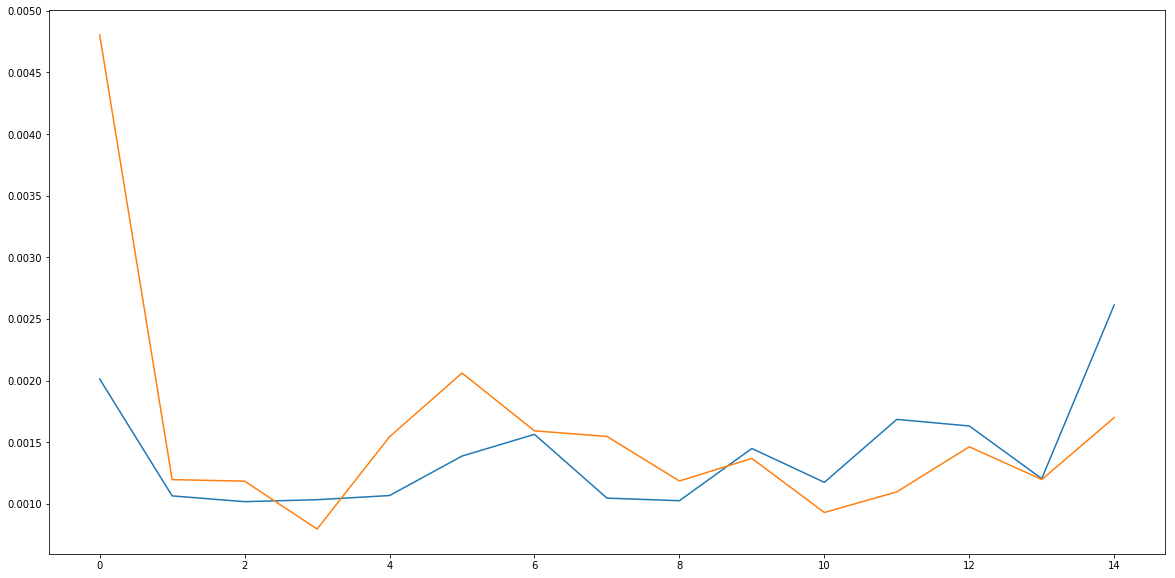

In [153]:
plt.figure(figsize=(20, 10))
plt.plot(val_main_loss)
plt.plot(test_main_loss)

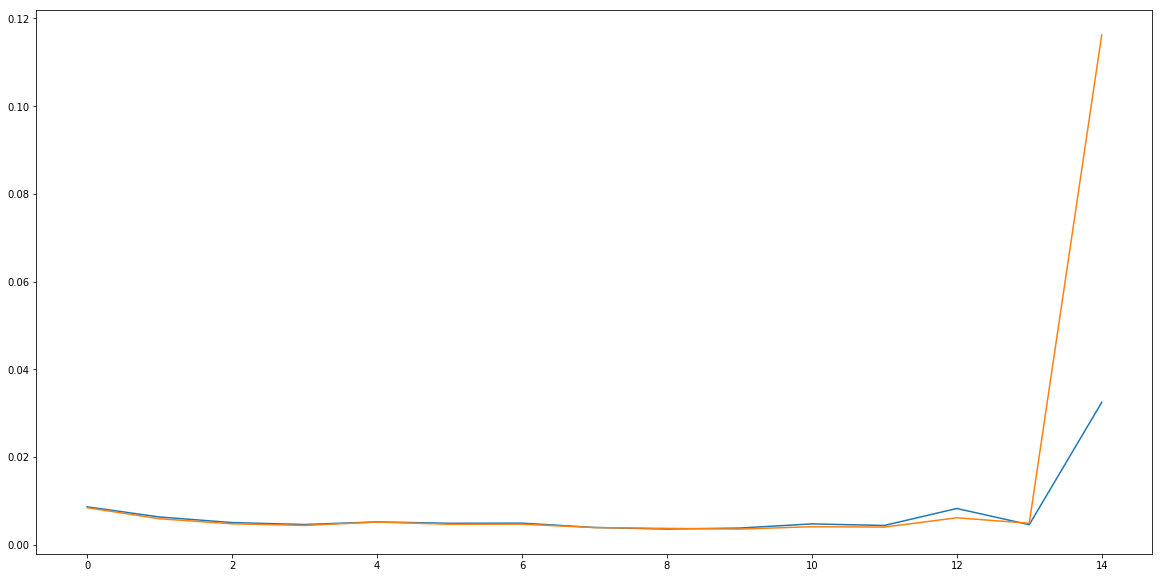

In [155]:
plt.figure(figsize=(20, 10))
plt.plot(val_aux_loss)
plt.plot(test_aux_loss)

In [156]:
min(val_main_loss), min(test_main_loss)

(0.0010187304149078915, 0.0007962565798878414)

#### Test with imf features and without multitask learning

In [166]:

X = np.zeros((len(data), depth, len(cols) + len(imf_cols)))
for j, name in enumerate(cols + imf_cols):
    for k in range(depth):
        X[:, k, j] = data[name].shift(depth - k - 1).fillna(method='bfill')

X_train = X[:train_length]
X_val = X[train_length:train_length+val_length]
X_test = X[-val_length:]

y_train = y[:train_length]
y_val = y[train_length:train_length+val_length]
y_test = y[-val_length:]

X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)
y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)

y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=64)

model = SelfBoostedNet(X_train_t.shape[2], i, 32, 3, 32).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()
val_loss = 99999
for e in range(100):
    train_main_loss, train_aux_loss = 0, 0
    for batch_x, batch_y in tqdm_notebook(train_loader):
        opt.zero_grad()
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        main_output, _ = model(batch_x)
        main_loss = loss(main_output, batch_y)
        total_loss = main_loss #+ alpha*aux_loss
        total_loss.backward()
        opt.step()
        train_main_loss += main_loss.item()*batch_x.shape[0]
        
    with torch.no_grad():
        val_main_loss, val_aux_loss = 0, 0
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            main_output, _ = model(batch_x)
            main_loss = loss(main_output, batch_y)
            val_main_loss += main_loss.item()*batch_x.shape[0]
            
        train_main_loss /= X_train_t.shape[0]
        
        val_main_loss /= X_val_t.shape[0]
        
        if val_loss > val_main_loss:
            val_loss = val_main_loss
            torch.save(model.state_dict(), 'self_boost_air_quality.pt')

    print("Iter: ", e,
          "train main loss: ", train_main_loss, 
          "val main loss: ", val_main_loss)

model.load_state_dict(torch.load('self_boost_air_quality.pt'))

with torch.no_grad():
    val_main_loss = 0
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        main_output, _= model(batch_x)
        main_loss = loss(main_output, batch_y)

        val_main_loss += main_loss.item()*batch_x.shape[0]

    test_main_loss = 0
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

        main_output, _ = model(batch_x)
        main_loss = loss(main_output, batch_y)

        test_main_loss += main_loss.item()*batch_x.shape[0]

    val_main_loss = val_main_loss/len(X_val_t)
    test_main_loss = test_main_loss/len(X_test_t)



Iter:  0 train main loss:  0.1773052663423989 val main loss:  0.039769611261399516



Iter:  1 train main loss:  0.0470669709207652 val main loss:  0.025892448872170452



Iter:  2 train main loss:  0.030286026339675077 val main loss:  0.021503390720725813



Iter:  3 train main loss:  0.021888098273975712 val main loss:  0.01839592027130764



Iter:  4 train main loss:  0.020923355528714372 val main loss:  0.01698856028200077



Iter:  5 train main loss:  0.018343166632080153 val main loss:  0.014703285425051716



Iter:  6 train main loss:  0.016637455647767366 val main loss:  0.01195262862642816



Iter:  7 train main loss:  0.0132834533228159 val main loss:  0.012894680032185982



Iter:  8 train main loss:  0.010683182689247523 val main loss:  0.009260475314925439



Iter:  9 train main loss:  0.008303815545866627 val main loss:  0.00682210691820008



Iter:  10 train main loss:  0.007616828560936686 val main loss:  0.0077713542532297725



Iter:  11 train main loss:  0.006272659740049821 val main loss:  0.009450865309555655



Iter:  12 train main loss:  0.00493914201404586 val main loss:  0.007009944792958852



Iter:  13 train main loss:  0.004637071659735383 val main loss:  0.006651351068054799



Iter:  14 train main loss:  0.0034653904898775973 val main loss:  0.011269759815559971



Iter:  15 train main loss:  0.0038370642901946676 val main loss:  0.004546319914405424



Iter:  16 train main loss:  0.003259747059896473 val main loss:  0.0038949197102652777



Iter:  17 train main loss:  0.0026135109123222814 val main loss:  0.0032848320491297256



Iter:  18 train main loss:  0.0025590162491139034 val main loss:  0.003932304823930437



Iter:  19 train main loss:  0.001487512393883734 val main loss:  0.005426448247658036



Iter:  20 train main loss:  0.001281419130161356 val main loss:  0.006216559050665675



Iter:  21 train main loss:  0.0013940761671249126 val main loss:  0.0033164420922374336



Iter:  22 train main loss:  0.0014582603401283182 val main loss:  0.002875106219387168



Iter:  23 train main loss:  0.0009679787436166066 val main loss:  0.003237822624252875



Iter:  24 train main loss:  0.0012050247466182144 val main loss:  0.005302774645643822



Iter:  25 train main loss:  0.0009605839778202042 val main loss:  0.00981195055591503



Iter:  26 train main loss:  0.0004974391500679308 val main loss:  0.009715993838028741



Iter:  27 train main loss:  0.0006065436172077935 val main loss:  0.009788241005800625



Iter:  28 train main loss:  0.00030541229663732757 val main loss:  0.00792103847657176



Iter:  29 train main loss:  0.0002869974023701784 val main loss:  0.007817932041194742



Iter:  30 train main loss:  0.0018021979041500259 val main loss:  0.004844750995367152



Iter:  31 train main loss:  0.000430429400503787 val main loss:  0.006715168388473871



Iter:  32 train main loss:  0.0015752523712331064 val main loss:  0.004036260603798245



Iter:  33 train main loss:  0.0004181064070558581 val main loss:  0.002910214432892847



Iter:  34 train main loss:  0.0004359790550588949 val main loss:  0.003317377742462513



Iter:  35 train main loss:  0.00037116571146111286 val main loss:  0.00580590670051126



Iter:  36 train main loss:  0.00031025076775047147 val main loss:  0.00333261570916339



Iter:  37 train main loss:  0.00043595378230439915 val main loss:  0.004733355012461701



Iter:  38 train main loss:  0.00017424436852064498 val main loss:  0.0031030273455644563



Iter:  39 train main loss:  0.00025504119583544136 val main loss:  0.0033138652576513218



Iter:  40 train main loss:  0.000471891080355915 val main loss:  0.004431171904523574



Iter:  41 train main loss:  7.895137699748629e-05 val main loss:  0.005302409683241103



Iter:  42 train main loss:  5.6326117602722613e-05 val main loss:  0.005286713859873776



Iter:  43 train main loss:  5.548717767753845e-05 val main loss:  0.004757903403257843



Iter:  44 train main loss:  4.636902452441767e-05 val main loss:  0.005960865531273092



Iter:  45 train main loss:  4.5537908118757155e-05 val main loss:  0.005914574491087281



Iter:  46 train main loss:  4.664641847870338e-05 val main loss:  0.005662463391750437



Iter:  47 train main loss:  4.0594725641047444e-05 val main loss:  0.00586019884480248



Iter:  48 train main loss:  3.774104786836031e-05 val main loss:  0.006608662872421314



Iter:  49 train main loss:  3.920103122201837e-05 val main loss:  0.005322073650454911



Iter:  50 train main loss:  3.719119538064779e-05 val main loss:  0.006360088443455366



Iter:  51 train main loss:  3.497401034858054e-05 val main loss:  0.006522914357426839



Iter:  52 train main loss:  3.4436530633193574e-05 val main loss:  0.006252666537090841



Iter:  53 train main loss:  3.5988126114036296e-05 val main loss:  0.006075355393832713



Iter:  54 train main loss:  3.213085065578616e-05 val main loss:  0.006059140097271207



Iter:  55 train main loss:  3.324087116109559e-05 val main loss:  0.005926294112012553



Iter:  56 train main loss:  3.2740059707827666e-05 val main loss:  0.005285551145066996



Iter:  57 train main loss:  3.368614402107644e-05 val main loss:  0.005991724358110392



Iter:  58 train main loss:  3.1331472795495824e-05 val main loss:  0.005709949562632417



Iter:  59 train main loss:  3.348084979348188e-05 val main loss:  0.006064878173202961



Iter:  60 train main loss:  3.000923236768201e-05 val main loss:  0.006549639175567332



Iter:  61 train main loss:  3.206327055561122e-05 val main loss:  0.005906933863276524



Iter:  62 train main loss:  3.1420173650308414e-05 val main loss:  0.006064935695586988



Iter:  63 train main loss:  3.1116993913525096e-05 val main loss:  0.0055780720793388375



Iter:  64 train main loss:  3.076935807507885e-05 val main loss:  0.006070090409854099



Iter:  65 train main loss:  3.384558984507505e-05 val main loss:  0.006629454041683679



Iter:  66 train main loss:  3.114964366694293e-05 val main loss:  0.006611787892620884



Iter:  67 train main loss:  2.930704766413888e-05 val main loss:  0.0063634459993879705



Iter:  68 train main loss:  3.0327233208996723e-05 val main loss:  0.005868905774143612



Iter:  69 train main loss:  2.936929822716337e-05 val main loss:  0.006284638445486572



Iter:  70 train main loss:  3.384865102208617e-05 val main loss:  0.006035030856846567



Iter:  71 train main loss:  2.8035887191422458e-05 val main loss:  0.006567403968360173



Iter:  72 train main loss:  2.847635811081681e-05 val main loss:  0.005985115531958844



Iter:  73 train main loss:  3.0489615738245465e-05 val main loss:  0.0068328651710715315



Iter:  74 train main loss:  2.7903575026511735e-05 val main loss:  0.00676381729217197



Iter:  75 train main loss:  2.661424739744753e-05 val main loss:  0.0066174087720680215



Iter:  76 train main loss:  2.6751793778317424e-05 val main loss:  0.0062443906037626664



Iter:  77 train main loss:  2.8448974854817753e-05 val main loss:  0.0061164282633821695



Iter:  78 train main loss:  2.950438420493436e-05 val main loss:  0.005989586014680194



Iter:  79 train main loss:  2.842143701481179e-05 val main loss:  0.006155899453993273



Iter:  80 train main loss:  2.840169485437972e-05 val main loss:  0.00556787674697834



Iter:  81 train main loss:  3.3437196243261284e-05 val main loss:  0.006644147886981187



Iter:  82 train main loss:  3.4724763064332046e-05 val main loss:  0.005942994729237613



Iter:  83 train main loss:  2.8551884558078994e-05 val main loss:  0.0060328621545869465



Iter:  84 train main loss:  2.796570867929049e-05 val main loss:  0.0066613221266665894



Iter:  85 train main loss:  2.425081653547346e-05 val main loss:  0.006097104267815645



Iter:  86 train main loss:  2.8626632936625454e-05 val main loss:  0.006357033425251685



Iter:  87 train main loss:  2.7670753924068738e-05 val main loss:  0.00452811467948585



Iter:  88 train main loss:  0.004391022036670383 val main loss:  0.0056778519732018085



Iter:  89 train main loss:  0.0011192648001390536 val main loss:  0.002895333775424388



Iter:  90 train main loss:  0.0008395797456035875 val main loss:  0.0021740876632637355



Iter:  91 train main loss:  0.00034045631612842167 val main loss:  0.0016688515082810078



Iter:  92 train main loss:  0.0003038053743227604 val main loss:  0.002335008480384505



Iter:  93 train main loss:  0.00028151667900435924 val main loss:  0.0017760320036886447



Iter:  94 train main loss:  0.0004596149598536821 val main loss:  0.002030626452358788



Iter:  95 train main loss:  0.0001129556476051231 val main loss:  0.005597467942619666



Iter:  96 train main loss:  4.417085027370239e-05 val main loss:  0.004366143950009905



Iter:  97 train main loss:  3.2086036648590105e-05 val main loss:  0.00429332678504003



Iter:  98 train main loss:  3.0371787030919315e-05 val main loss:  0.0044917025719646364



Iter:  99 train main loss:  2.950180944047984e-05 val main loss:  0.004292122772973475


In [168]:
val_main_loss, test_main_loss

(0.0016688515082810078, 0.0020053917072504887)

#### Test without imf features and without multitask learning

In [162]:

X = np.zeros((len(data), depth, len(cols)))
for j, name in enumerate(cols):
    for k in range(depth):
        X[:, k, j] = data[name].shift(depth - k - 1).fillna(method='bfill')

X_train = X[:train_length]
X_val = X[train_length:train_length+val_length]
X_test = X[-val_length:]

y_train = y[:train_length]
y_val = y[train_length:train_length+val_length]
y_test = y[-val_length:]

X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)
y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)

y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=64)

model = SelfBoostedNet(X_train_t.shape[2], i, 32, 3, 32).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()
val_loss = 99999
for e in range(100):
    train_main_loss, train_aux_loss = 0, 0
    for batch_x, batch_y in tqdm_notebook(train_loader):
        opt.zero_grad()
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        main_output, _ = model(batch_x)
        main_loss = loss(main_output, batch_y)
        total_loss = main_loss #+ alpha*aux_loss
        total_loss.backward()
        opt.step()
        train_main_loss += main_loss.item()*batch_x.shape[0]
        
    with torch.no_grad():
        val_main_loss, val_aux_loss = 0, 0
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            main_output, _ = model(batch_x)
            main_loss = loss(main_output, batch_y)
            val_main_loss += main_loss.item()*batch_x.shape[0]
            
        train_main_loss /= X_train_t.shape[0]
        
        val_main_loss /= X_val_t.shape[0]
        
        if val_loss > val_main_loss:
            val_loss = val_main_loss
            torch.save(model.state_dict(), 'self_boost_air_quality.pt')

    print("Iter: ", e,
          "train main loss: ", train_main_loss, 
          "val main loss: ", val_main_loss)

model.load_state_dict(torch.load('self_boost_air_quality.pt'))

with torch.no_grad():
    val_main_loss = 0
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        main_output, _= model(batch_x)
        main_loss = loss(main_output, batch_y)

        val_main_loss += main_loss.item()*batch_x.shape[0]

    test_main_loss = 0
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

        main_output, aux_output = model(batch_x)
        main_loss = loss(main_output, batch_y)

        test_main_loss += main_loss.item()*batch_x.shape[0]

val_main_loss = val_main_loss/len(X_val_t)
test_main_loss = test_main_loss/len(X_test_t)



Iter:  0 train main loss:  0.1313329017532623 val main loss:  0.03458454945334159



Iter:  1 train main loss:  0.044608280756332136 val main loss:  0.025697011819233236



Iter:  2 train main loss:  0.035564780233979264 val main loss:  0.02414380250756315



Iter:  3 train main loss:  0.03173091689025376 val main loss:  0.022318786283543897



Iter:  4 train main loss:  0.028698914956769572 val main loss:  0.021098287500256187



Iter:  5 train main loss:  0.02695596282492008 val main loss:  0.0200137455260269



Iter:  6 train main loss:  0.024763175722018842 val main loss:  0.019559703098065213



Iter:  7 train main loss:  0.022850861263470263 val main loss:  0.01881728611626872



Iter:  8 train main loss:  0.020904593520123475 val main loss:  0.019617621984073172



Iter:  9 train main loss:  0.02035565935360482 val main loss:  0.01995818633212459



Iter:  10 train main loss:  0.01946800488723584 val main loss:  0.019816677084088387



Iter:  11 train main loss:  0.01909194387225398 val main loss:  0.01975246942444747



Iter:  12 train main loss:  0.01896969501831592 val main loss:  0.02101887895508326



Iter:  13 train main loss:  0.018678737890181176 val main loss:  0.019208221994301083



Iter:  14 train main loss:  0.018535997063762043 val main loss:  0.020338130198269612



Iter:  15 train main loss:  0.01809273082507261 val main loss:  0.021765259960951498



Iter:  16 train main loss:  0.018542473368669262 val main loss:  0.01937054666305018



Iter:  17 train main loss:  0.018236183360761864 val main loss:  0.0207975982632311



Iter:  18 train main loss:  0.018145677131698696 val main loss:  0.019472057946122702



Iter:  19 train main loss:  0.017936920251668455 val main loss:  0.02136982050689907



Iter:  20 train main loss:  0.017375986940505763 val main loss:  0.023635245010663913



Iter:  21 train main loss:  0.01734932429796109 val main loss:  0.018924142716898962



Iter:  22 train main loss:  0.01732898363335447 val main loss:  0.02285535807043723



Iter:  23 train main loss:  0.017858704512388784 val main loss:  0.019648989108110824



Iter:  24 train main loss:  0.017347247849209695 val main loss:  0.018685613720507657



Iter:  25 train main loss:  0.01759156016791905 val main loss:  0.022085089096848667



Iter:  26 train main loss:  0.017588681022943756 val main loss:  0.01932446742794204



Iter:  27 train main loss:  0.01690915189237609 val main loss:  0.02207938890113498



Iter:  28 train main loss:  0.017344716953068436 val main loss:  0.02129896525234582



Iter:  29 train main loss:  0.017030534952227748 val main loss:  0.021398707779779355



Iter:  30 train main loss:  0.016941299882941328 val main loss:  0.023924486027143445



Iter:  31 train main loss:  0.016754326474515538 val main loss:  0.023470036742014862



Iter:  32 train main loss:  0.017340563370759995 val main loss:  0.024552204721649557



Iter:  33 train main loss:  0.016899735774334804 val main loss:  0.022412629866895857



Iter:  34 train main loss:  0.016854714247208274 val main loss:  0.022462016209535137



Iter:  35 train main loss:  0.017157252550135612 val main loss:  0.02029176872251152



Iter:  36 train main loss:  0.016753904086782536 val main loss:  0.020440014553233715



Iter:  37 train main loss:  0.01653494532339718 val main loss:  0.019760251845013833



Iter:  38 train main loss:  0.0164176291362925 val main loss:  0.020825979599794087



Iter:  39 train main loss:  0.016742037095533357 val main loss:  0.02247122656494977



Iter:  40 train main loss:  0.016918066719869444 val main loss:  0.023848897855189937



Iter:  41 train main loss:  0.016416787818291895 val main loss:  0.024461110128402522



Iter:  42 train main loss:  0.016137096900489627 val main loss:  0.0205193755414569



Iter:  43 train main loss:  0.015969608361373528 val main loss:  0.025463909626699425



Iter:  44 train main loss:  0.0164668945925404 val main loss:  0.021905539980219182



Iter:  45 train main loss:  0.01617160683238157 val main loss:  0.021940268785618992



Iter:  46 train main loss:  0.01613573426787572 val main loss:  0.02217249554525884



Iter:  47 train main loss:  0.016055410513467497 val main loss:  0.02414879199892377



Iter:  48 train main loss:  0.01594583200115746 val main loss:  0.022612048940459678



Iter:  49 train main loss:  0.015811262056965803 val main loss:  0.02432216715496407



Iter:  50 train main loss:  0.01541612816948951 val main loss:  0.023273020487085943



Iter:  51 train main loss:  0.01603839429149805 val main loss:  0.024760048856138552



Iter:  52 train main loss:  0.01685120302210839 val main loss:  0.02478907137534875



Iter:  53 train main loss:  0.01543355848809356 val main loss:  0.023627589912072155



Iter:  54 train main loss:  0.01555480674418612 val main loss:  0.02180199182681826



Iter:  55 train main loss:  0.015896112600224083 val main loss:  0.020327755162510095



Iter:  56 train main loss:  0.015313953595922388 val main loss:  0.025587368049435594



Iter:  57 train main loss:  0.015095108920699776 val main loss:  0.01882927552644466



Iter:  58 train main loss:  0.015370323705765267 val main loss:  0.02733958279861505



Iter:  59 train main loss:  0.015305750602079357 val main loss:  0.024249090812116892



Iter:  60 train main loss:  0.015247491260794468 val main loss:  0.0193071476761114



Iter:  61 train main loss:  0.014667921016949652 val main loss:  0.027987581369916515



Iter:  62 train main loss:  0.015466809318332405 val main loss:  0.02246739568214356



Iter:  63 train main loss:  0.014622484452810057 val main loss:  0.025458642365184733



Iter:  64 train main loss:  0.014895813296016651 val main loss:  0.02399743566291511



Iter:  65 train main loss:  0.01483829451455423 val main loss:  0.023837523439499807



Iter:  66 train main loss:  0.01496305621021933 val main loss:  0.022718484006987328



Iter:  67 train main loss:  0.014652410310334783 val main loss:  0.027590687546993134



Iter:  68 train main loss:  0.01441012224132003 val main loss:  0.027006297422437254



Iter:  69 train main loss:  0.014372219789520153 val main loss:  0.02752565828603402



Iter:  70 train main loss:  0.01431889456638785 val main loss:  0.022952883916394638



Iter:  71 train main loss:  0.014719574553554366 val main loss:  0.023152286639199087



Iter:  72 train main loss:  0.014726628930973717 val main loss:  0.023396501332371956



Iter:  73 train main loss:  0.014047785628677485 val main loss:  0.023995328334641054



Iter:  74 train main loss:  0.014013760148022102 val main loss:  0.023432644047708482



Iter:  75 train main loss:  0.01429556432878025 val main loss:  0.024354638229886417



Iter:  76 train main loss:  0.01368096799369074 val main loss:  0.021449883615965892



Iter:  77 train main loss:  0.014327879259162849 val main loss:  0.02738149468162527



Iter:  78 train main loss:  0.014612648255509396 val main loss:  0.02156965522864615



Iter:  79 train main loss:  0.014049908688473394 val main loss:  0.02855450548148009



Iter:  80 train main loss:  0.014048115792528544 val main loss:  0.02780922343649576



Iter:  81 train main loss:  0.013466913935907685 val main loss:  0.023555862330836504



Iter:  82 train main loss:  0.013474993286106901 val main loss:  0.022904971341082263



Iter:  83 train main loss:  0.013644942734570795 val main loss:  0.023004213462110682



Iter:  84 train main loss:  0.01362361221625714 val main loss:  0.028469864611436222



Iter:  85 train main loss:  0.014457968825822521 val main loss:  0.023342690646939508



Iter:  86 train main loss:  0.014127157071660398 val main loss:  0.022991263166998357



Iter:  87 train main loss:  0.013555047663000164 val main loss:  0.023451094107123125



Iter:  88 train main loss:  0.012949282649625192 val main loss:  0.025665911680644075



Iter:  89 train main loss:  0.013534630214928563 val main loss:  0.022619727987170598



Iter:  90 train main loss:  0.01282359534446432 val main loss:  0.023147990655669314



Iter:  91 train main loss:  0.013627566823411132 val main loss:  0.02586035215450252



Iter:  92 train main loss:  0.01332208187304095 val main loss:  0.024389624922145886



Iter:  93 train main loss:  0.013091707069279914 val main loss:  0.02175445448796028



Iter:  94 train main loss:  0.012579569489318472 val main loss:  0.023428046874261393



Iter:  95 train main loss:  0.012451745805445965 val main loss:  0.024390181281786792



Iter:  96 train main loss:  0.013228827573481164 val main loss:  0.02149056930315249



Iter:  97 train main loss:  0.012902943610738364 val main loss:  0.022740608159897195



Iter:  98 train main loss:  0.01315934212490869 val main loss:  0.022246722001169335



Iter:  99 train main loss:  0.013543229343230937 val main loss:  0.021162284824332377


In [163]:
val_main_loss, test_main_loss

(0.018685613720507657, 0.021029350843081468)